In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy import stats

In [ ]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [2]:
df=pd.read_csv('ProjectData.csv')

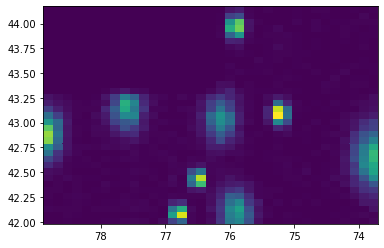

In [3]:
#correct orientation
min_lat = min(df['Lat'])
max_lat = max(df['Lat'])
min_lon = min(df['Lon'])
max_lon = max(df['Lon'])

prob = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[0];
x_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[1];
y_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[2];
plt.axis([max_lon, min_lon, min_lat, max_lat])
x_bin_width = (x_bins[1] - x_bins[0])
y_bin_width = (y_bins[1] - y_bins[0])
bin_area = x_bin_width * y_bin_width
prob *= bin_area

marginal_prob_x_axis = np.cumsum(np.sum(prob, axis=1))
marginal_prob_y_axis = [np.cumsum(prob[i,:] / np.sum(prob[i,:])) for i in range(len(x_bins)-1)]
                                 
def generate_location():
    x_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_x_axis)
    x_coord = x_bins[x_bin_coord_ind]
    
    y_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_y_axis[x_bin_coord_ind])
    y_coord = y_bins[y_bin_coord_ind]

    x_coord += np.random.uniform() * x_bin_width
    y_coord += np.random.uniform() * y_bin_width

    return [x_coord, y_coord]

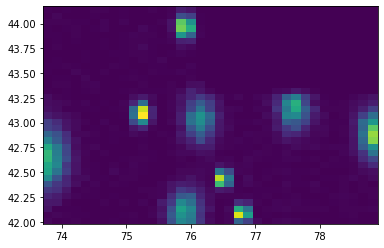

In [4]:
#old version, did not delete just in case lol
prob = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[0];
x_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[1];
y_bins = plt.hist2d(df['Lon'],df['Lat'],bins=35,density=True)[2];
x_bin_width = (x_bins[1] - x_bins[0])
y_bin_width = (y_bins[1] - y_bins[0])
bin_area = x_bin_width * y_bin_width
prob *= bin_area

marginal_prob_x_axis = np.cumsum(np.sum(prob, axis=1))
marginal_prob_y_axis = [np.cumsum(prob[i,:] / np.sum(prob[i,:])) for i in range(len(x_bins)-1)]
                                 
def generate_location():
    x_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_x_axis)
    x_coord = x_bins[x_bin_coord_ind]
    
    y_bin_coord_ind = np.sum(np.random.uniform() > marginal_prob_y_axis[x_bin_coord_ind])
    y_coord = y_bins[y_bin_coord_ind]

    x_coord += np.random.uniform() * x_bin_width
    y_coord += np.random.uniform() * y_bin_width

    return [x_coord, y_coord]

In [5]:
#Fit lambda rates to nonhomo PP
time = df['Time']
days = np.ceil(time/24)
counts = np.zeros(24)
for i in range(df.shape[0]):
    interval = int(time[i]) % 24
    counts[interval] += 1

lambda_rates = counts/(max(days))

In [6]:
def initialize_event_list(lambda_rates, days):
    event_list = []
    lambda_max = np.max(lambda_rates)
    
    t = 0
    i = 0

    while t <= 24 * days:
        t += np.random.exponential(1/lambda_max)
        if np.random.uniform() * lambda_max <= lambda_rates[int(np.floor(t%24))]:
            location = generate_location()
            event_list.append([t,'call', i, location])
            i += 1
    
    return event_list

In [7]:
#Hospital and major trauma center (MTC) locations
hosp_locs = [ [76.5019, 42.4440], [76.8077, 42.0898], [76.5155, 41.9790], [75.2327, 43.1009], 
            [75.9108, 43.9748], [75.9180, 42.0987], [78.8784, 42.8864], [77.6088, 43.1566], 
            [73.7562, 42.6526], [76.1474, 43.0481] ]

mtc_indices = [2,7,8,9]
mtc_locs = [hosp_locs[i] for i in mtc_indices]

In [8]:
def making_decision_HD(t, call_ind):
    return [t + np.random.triangular(5/60,7/60,10/60), 'HD decision', call_ind]

In [9]:
from haversine import haversine

def heli_avaliable(call_location, heli_states, heli_locs):
    n = len(heli_states)
    dists = [haversine((-call_location[0], call_location[1]), (-heli_locs[i][0], heli_locs[i][1])) 
             if heli_states[i] == 1 else np.inf for i in range(n)  ]
    if np.min(dists) > range_heli:
        return -1
    else:
        return np.argmin(dists)

In [10]:
def made_decision_HD(t, call_ref, event, heli_states, heli_locs): #HD event
    call_ind = event[2]
    call_location = call_ref[call_ind][3]
    
    if np.random.uniform() < p_not_safe:
            return 'unsafe'
        
    best_heli = heli_avaliable(call_location, heli_states, heli_locs)
    if best_heli == -1 or heli_states[best_heli] == 0:
        return 'unavaliable'
    
    heli_states[best_heli] = 0
    best_heli_loc = heli_locs[best_heli]
    takeoff_time = np.random.triangular(5/60,7.5/60,10/60)
    travel_time = haversine((-call_location[0], call_location[1]), (-best_heli_loc[0], best_heli_loc[1])) / heli_speed
    total_time = takeoff_time + travel_time
    
    CT = np.random.exponential(1/0.205) #0.205 rate for cancellation time
    if CT < takeoff_time:
        cancelled = 1
        return [t + CT, 'Arrived at Base', best_heli, cancelled]
    elif CT < 0.5: #scenario where call is cancelled with heli en-route to scene of call
        cancelled = 1
        return [t + takeoff_time + 2 * (CT - takeoff_time), 'Arrived at Base', best_heli, cancelled]
    else:
        return [t + total_time, 'Arrived at Scene', call_ind, best_heli]

In [11]:
def making_decision_at_site(t, event, call_ind, heli_ind):
    return [t + np.random.gamma(2.95,0.12), 'Decision made at Scene', call_ind, heli_ind]

In [12]:
def made_decision_at_site(call_ref, t, event, call_ind, heli_ind):
    
    call_location = call_ref[call_ind][3]
    hosp_dists = [haversine((-call_location[0], call_location[1]), (-hosp_loc[0], hosp_loc[1])) for hosp_loc in hosp_locs]
    best_hosp = np.argmin(hosp_dists)
    best_hosp_loc = hosp_locs[best_hosp]
    
    if best_hosp in mtc_indices:
        travel_time = haversine((-call_location[0], call_location[1]), (-best_hosp_loc[0], best_hosp_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', call_ind, best_hosp, heli_ind]
    
    elif np.random.uniform() < 1-h: #require special treatment
        mtc_dists = [haversine((-call_location[0], call_location[1]), (-mtc_loc[0], mtc_loc[1])) for mtc_loc in mtc_locs]
        best_mtc = mtc_indices[np.argmin(mtc_dists)]
        best_mtc_loc = hosp_locs[best_mtc]
        travel_time = haversine((-call_location[0], call_location[1]), (-best_mtc_loc[0], best_mtc_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', call_ind, best_mtc, heli_ind]
    
    else:
        travel_time = haversine((-call_location[0], call_location[1]), (-best_hosp_loc[0], best_hosp_loc[1])) / heli_speed
        return [t + travel_time, 'Arrived at Hospital', call_ind, best_hosp, heli_ind]

In [13]:
def making_decision_at_hosp(t, event, hosp_ind, heli_ind, heli_locs):
    hosp_loc = hosp_locs[hosp_ind]
    heli_loc = heli_locs[heli_ind]
    unloading_time = np.random.gamma(2.91,0.17)
    
    if hosp_loc == heli_loc:
        total_time = unloading_time
        return [t + total_time, 'Arrived at Base', heli_ind, 0] #Last index: this call was not cancelled
    else: 
        travel_time = haversine((-hosp_loc[0], hosp_loc[1]), (-heli_loc[0], heli_loc[1])) / heli_speed
        total_time = unloading_time + travel_time
        return [t + total_time, 'Arrived at Base', heli_ind, 0] #Last index: this call was not cancelled

In [14]:
import bisect 
#Hyperparameters given/estimated from dataset
heli_speed = 160
p_not_safe = 0.101 # Assumed to be 0.101 w/ 95% conﬁdence interval of [0.096,0.106]
h = 0.807 #Percent of call whose closest hospital != MTC, yet still go to closest hospital (as opposed to requiring an MTC)
range_heli = 180 #Range of helicopter's reach

In [178]:
# previous one
def replication(days, n, heli_ind_locs):
    #Initialize
    assert len(heli_ind_locs) == n
    heli_locs = [hosp_locs[i] for i in heli_ind_locs]
    heli_states = [1] * n
    
    #Initialize the event list with calls and make a copy for reference
    event_list = initialize_event_list(lambda_rates, days)
    call_ref = event_list.copy()
    
    # Performance metrics
    total_calls = len(call_ref)
    unsafe_calls = []
    unavaliable_calls = []
    cancelled_calls = []

    response_time = []
    arrived_at_scene = []

    care_time = []
    arrived_at_hosp = []
    
    #Main iteration
    t = 0
    while True:
        if (t > 24 * days) or (len(event_list) == 0):
            return total_calls, unsafe_calls, unavaliable_calls, cancelled_calls, response_time, arrived_at_scene, care_time, arrived_at_hosp

        event = event_list.pop(0)
        t = event[0]
        event_type = event[1]

        if event_type == 'call':
            gen_event = making_decision_HD(t, event[2])
            bisect.insort(event_list, gen_event)

        if event_type == 'HD decision': 
            gen_event = made_decision_HD(t, call_ref, event, heli_states, heli_locs)
            if gen_event == 'unsafe': 
                unsafe_calls.append(t)
            elif gen_event == 'unavaliable':
                unavaliable_calls.append(t)
            else:
                bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Scene':
            arrived_at_scene.append(t)
            response_time.append(t - call_ref[event[2]][0])

            gen_event = making_decision_at_site(t, event, event[2], event[3]) #call id & associated helicopter id: redundant? yes
            bisect.insort(event_list, gen_event)

        if event_type == 'Decision made at Scene':
            gen_event = made_decision_at_site(call_ref, t, event, event[2], event[3])
            bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Hospital':
            arrived_at_hosp.append(t)
            care_time.append(t - call_ref[event[2]][0])

            gen_event = making_decision_at_hosp(t, event, event[3], event[4], heli_locs)
            bisect.insort(event_list, gen_event)

        if event_type == 'Arrived at Base':
            if event[3] == 1:
                cancelled_calls.append(t)
            
            heli_states[event[2]] = 1

In [241]:
# later one, use this
def replication(days, n, heli_ind_locs):
    #Initialize
    assert len(heli_ind_locs) == n
    heli_locs = [hosp_locs[i] for i in heli_ind_locs]
    heli_states = [1] * n
    #Initialize the event list with calls and make a copy for reference
    event_list = initialize_event_list(lambda_rates, days)
    call_ref = event_list.copy()
    # Performance metrics
    unsafe_calls = []
    unavaliable_calls = []
    cancelled_calls = []
    response_time = []
    care_time = []
    #Main iteration
    t = 0
    while True:
        if (t > 24 * days) or (len(event_list) == 0):
            return unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time
            
        event = event_list.pop(0)
        t = event[0]
        event_type = event[1]
        
        if event_type == 'call':
            gen_event = making_decision_HD(t, event[2])
            bisect.insort(event_list, gen_event)
            
        if event_type == 'HD decision':
            gen_event = made_decision_HD(t, call_ref, event, heli_states, heli_locs)
            if gen_event == 'unsafe':
                unsafe_calls.append(t)
            elif gen_event == 'unavaliable':
                unavaliable_calls.append(t)
            else:
                bisect.insort(event_list, gen_event)
            
        if event_type == 'Arrived at Scene':
            #response_time.append([t,t - call_ref[event[2]][0]])
            response_time.append(t - call_ref[event[2]][0])
            gen_event = making_decision_at_site(t, event, event[2], event[3])
            bisect.insort(event_list, gen_event)
            
        if event_type == 'Decision made at Scene':
            gen_event = made_decision_at_site(call_ref, t, event, event[2], event[3])
            bisect.insort(event_list, gen_event)
            
        if event_type == 'Arrived at Hospital':
            care_time.append([t,t - call_ref[event[2]][0]])
            gen_event = making_decision_at_hosp(t, event, event[3], event[4], heli_locs)
            bisect.insort(event_list, gen_event)
            
        if event_type == 'Arrived at Base':
            if event[3] == 1:
                cancelled_calls.append(t)
                
            heli_states[event[2]] = 1

Note: total number of calls = len(call_ref) should be equal to 
unsafe_calls + unavaliable_calls + cancelled_calls + arrived_at_scene 

where arrived_at_scene should be equal to arrived_at_hosp

response_time, care_time give back lists so distributions and other statistics can be collected

In [247]:
unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time = replication(28,1,[8])


In [249]:
from statistics import mean
total_calls=len(unsafe_calls)+len(unavaliable_calls)+len(cancelled_calls)+len(care_time)
print('Number of calls: \t', len(unsafe_calls)+len(unavaliable_calls)+len(cancelled_calls)+len(care_time))
print('Number of calls that were deemed unsafe:\t', len(unsafe_calls))
print('Number of calls that could not be answered (but were safe):\t', len(unavaliable_calls))
print('Number of calls that were cancelled (but were safe and avaliable):\t', len(cancelled_calls))
print('Number of calls that were answered (and transported to hospital):\t', len(response_time))


print('Percentage of calls dispatched:\t', (len(cancelled_calls)+len(care_time))/total_calls)
print('Average response time:\t', mean(response_time))
print('Response fraction:\t', len(response_time)/total_calls)
print('Number of transportation:\t', len(response_time))

Number of calls: 	 1299
Number of calls that were deemed unsafe:	 117
Number of calls that could not be answered (but were safe):	 1028
Number of calls that were cancelled (but were safe and avaliable):	 13
Number of calls that were answered (and transported to hospital):	 141
Percentage of calls dispatched:	 0.11855273287143957
Average response time:	 0.6460524807362069
Response fraction:	 0.10854503464203233
Number of transportation:	 141


In [327]:
import numpy as np
import scipy.stats as st
per_dispatched = []
avg_resp_time = []
resp_fraction = []
num_trsp = []
for i in range(0,100):
    unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time = replication(28,12,[6,7,9,0,5,6,9,5,7,0,5,6])
    total_calls=len(unsafe_calls)+len(unavaliable_calls)+len(cancelled_calls)+len(care_time)
    
    per_dispatched.append((len(cancelled_calls)+len(care_time))/total_calls)
    avg_resp_time.append(mean(response_time))
    resp_fraction.append(len(response_time)/total_calls)
    num_trsp.append(len(response_time)/28/12) # last number = number of helicopters
    
print(st.t.interval(alpha=0.95, df=len(per_dispatched)-1, loc=np.mean(per_dispatched), scale=st.sem(per_dispatched)))
print(st.t.interval(alpha=0.95, df=len(avg_resp_time)-1, loc=np.mean(avg_resp_time), scale=st.sem(avg_resp_time)))
print(st.t.interval(alpha=0.95, df=len(resp_fraction)-1, loc=np.mean(resp_fraction), scale=st.sem(resp_fraction)))
print(st.t.interval(alpha=0.95, df=len(num_trsp)-1, loc=np.mean(num_trsp), scale=st.sem(num_trsp)))
print(mean(per_dispatched), mean(avg_resp_time), mean(resp_fraction), mean(num_trsp))

(0.7210946718817266, 0.7248425830183778)
(0.4378536803589798, 0.4411484032267781)
(0.6498330392314613, 0.6539897175341054)
(2.529054760260332, 2.5616595254539534)
0.722968627450052 0.4395010417928789 0.6519113783827832 2.545357142857143


In [269]:
from itertools import combinations_with_replacement

def test(n):
    items = [0,1,2,3,4,5,6,7,8,9]
    locs = []
    for c in combinations_with_replacement(items, n): # one city may have multiple helicopters
        locs.append(c)

    for l in locs:
        avg_response_time = 0
        for i in range(0,100):
            unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time = replication(28,n,l)
            avg_response_time = avg_response_time + mean(response_time)
        models.append(avg_response_time/100)
        print(l, avg_response_time/100)
            
    min_value = min(models)
    min_index = models.index(min_value)
    print('The optimal solution for ' +str(n)+ ' helicopters position is '+ str(locs[min_index]))

In [270]:
from itertools import combinations_with_replacement

def test2(n):
    items = [0,1,2,3,4,5,6,7,8,9]
    locs = []
    for c in combinations_with_replacement(items, n): # one city may have multiple helicopters
        locs.append(c)

    for l in locs:
        unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time = replication(28,n,l)
        models.append(mean(response_time))
        print(l, mean(response_time))
            
    min_value = min(models)
    min_index = models.index(min_value)
    print('The optimal solution for ' +str(n)+ ' helicopters position is '+ str(locs[min_index]))

In [271]:
models = []
test(1)

(0,) 0.7420657735575675
(1,) 0.8024400282912895
(2,) 0.7564795714245603
(3,) 0.9019715701606987
(4,) 0.6578579562950881
(5,) 0.6328651523696441
(6,) 0.7365182692131478
(7,) 0.898628113775137
(8,) 0.6274877931420151
(9,) 0.6736611014208582
The optimal solution for 1 helicopters position is (8,)


In [273]:
models = []
test(2)

(0, 0) 0.7412007559823625
(0, 1) 0.7411044950742613
(0, 2) 0.7313780302112813
(0, 3) 0.775895326859877
(0, 4) 0.6620397041406371
(0, 5) 0.6534359583718529
(0, 6) 0.6970734349548405
(0, 7) 0.7716055316870593
(0, 8) 0.664803504867834
(0, 9) 0.6703459469431707
(1, 1) 0.7918035740940262
(1, 2) 0.7451218924360362
(1, 3) 0.8083284733679506
(1, 4) 0.683955974061645
(1, 5) 0.6687748748062953
(1, 6) 0.7432825272867658
(1, 7) 0.810677655116281
(1, 8) 0.7057182878708333
(1, 9) 0.6688645030604323
(2, 2) 0.7480349482621129
(2, 3) 0.8025345132588655
(2, 4) 0.6759392122713562
(2, 5) 0.669444411033863
(2, 6) 0.7122522220541716
(2, 7) 0.780790548016205
(2, 8) 0.6751405372720998
(2, 9) 0.6794555222609548
(3, 3) 0.9023833282726075
(3, 4) 0.7596912789635375
(3, 5) 0.7549439595924221
(3, 6) 0.8207178317640373
(3, 7) 0.8636210412553519
(3, 8) 0.7086549246196657
(3, 9) 0.7680848851678179
(4, 4) 0.661729663633813
(4, 5) 0.6345316004587116
(4, 6) 0.6814388302633609
(4, 7) 0.7266417909628985
(4, 8) 0.6207660202

In [274]:
models = []
test(3)

(0, 0, 0) 0.7231197212849623
(0, 0, 1) 0.7167542917709788
(0, 0, 2) 0.7370134557589234
(0, 0, 3) 0.7613572878588079
(0, 0, 4) 0.668264548752531
(0, 0, 5) 0.6615265685710272
(0, 0, 6) 0.697045283794023
(0, 0, 7) 0.7218771987116905
(0, 0, 8) 0.6716241112616789
(0, 0, 9) 0.6636154777636307
(0, 1, 1) 0.7386239312229537
(0, 1, 2) 0.7275222974155782
(0, 1, 3) 0.7531171100211657
(0, 1, 4) 0.6614917413036516
(0, 1, 5) 0.6523248236191272
(0, 1, 6) 0.697384014270461
(0, 1, 7) 0.7404130517495076
(0, 1, 8) 0.6750595350395661
(0, 1, 9) 0.6569971770820524
(0, 2, 2) 0.7464160044426058
(0, 2, 3) 0.7606156757512975
(0, 2, 4) 0.6646136871958153
(0, 2, 5) 0.6661274020690457
(0, 2, 6) 0.6956359098822925
(0, 2, 7) 0.741608209281394
(0, 2, 8) 0.6795451247291961
(0, 2, 9) 0.6717235196978666
(0, 3, 3) 0.8067103366713855
(0, 3, 4) 0.7235427170706249
(0, 3, 5) 0.7120582594891446
(0, 3, 6) 0.7467381236183469
(0, 3, 7) 0.7727661087340998
(0, 3, 8) 0.6809363084033335
(0, 3, 9) 0.709630622484456
(0, 4, 4) 0.6506023

In [99]:
models = []
test(4)

(0, 0, 0, 0) 0.7419507620064643
(0, 0, 0, 1) 0.7116206423378224
(0, 0, 0, 2) 0.734530059081382
(0, 0, 0, 3) 0.7446057775679396
(0, 0, 0, 4) 0.6666608035902398
(0, 0, 0, 5) 0.6663691562070913
(0, 0, 0, 6) 0.6817293305425948
(0, 0, 0, 7) 0.7134193084616096
(0, 0, 0, 8) 0.6675950680832337
(0, 0, 0, 9) 0.6720990719607091
(0, 0, 1, 1) 0.7189391509311703
(0, 0, 1, 2) 0.7191091418956235
(0, 0, 1, 3) 0.7310719580535349
(0, 0, 1, 4) 0.6541888289685398
(0, 0, 1, 5) 0.6459402004790105
(0, 0, 1, 6) 0.6712775395685462
(0, 0, 1, 7) 0.7147866043449114
(0, 0, 1, 8) 0.6720719785969801
(0, 0, 1, 9) 0.6562481031598248
(0, 0, 2, 2) 0.7374849681729445
(0, 0, 2, 3) 0.7508871130587547
(0, 0, 2, 4) 0.6745926575942403
(0, 0, 2, 5) 0.6638296367953496
(0, 0, 2, 6) 0.6860307293395334
(0, 0, 2, 7) 0.7123240949044702
(0, 0, 2, 8) 0.6803101595951317
(0, 0, 2, 9) 0.6776874509559521
(0, 0, 3, 3) 0.7787452166415189
(0, 0, 3, 4) 0.7059989733586863
(0, 0, 3, 5) 0.6906834250251399
(0, 0, 3, 6) 0.7202437305155123
(0, 0, 3,

(1, 1, 6, 8) 0.7066825598221821
(1, 1, 6, 9) 0.6462442835769788
(1, 1, 7, 7) 0.7970418723757381
(1, 1, 7, 8) 0.7428614049210608
(1, 1, 7, 9) 0.6874037766771479
(1, 1, 8, 8) 0.7112993045775574
(1, 1, 8, 9) 0.6471515438816631
(1, 1, 9, 9) 0.6348317918915909
(1, 2, 2, 2) 0.731511589585974
(1, 2, 2, 3) 0.7457150439380221
(1, 2, 2, 4) 0.6572428329308487
(1, 2, 2, 5) 0.6627038456534298
(1, 2, 2, 6) 0.6932200642513392
(1, 2, 2, 7) 0.7312830213346898
(1, 2, 2, 8) 0.6818980975054465
(1, 2, 2, 9) 0.6601167009669443
(1, 2, 3, 3) 0.7734419725981325
(1, 2, 3, 4) 0.69673957704328
(1, 2, 3, 5) 0.6970859376539605
(1, 2, 3, 6) 0.7280031999297434
(1, 2, 3, 7) 0.7605241700159031
(1, 2, 3, 8) 0.6761935925336882
(1, 2, 3, 9) 0.6969932850065488
(1, 2, 4, 4) 0.6407487541395336
(1, 2, 4, 5) 0.6175739441496118
(1, 2, 4, 6) 0.6368085346517265
(1, 2, 4, 7) 0.6699502821195871
(1, 2, 4, 8) 0.6318682053970319
(1, 2, 4, 9) 0.6261960660281093
(1, 2, 5, 5) 0.6282827353252912
(1, 2, 5, 6) 0.6353519891208276
(1, 2, 5, 7

(3, 3, 4, 7) 0.7817100700583355
(3, 3, 4, 8) 0.6795604341543283
(3, 3, 4, 9) 0.7493625742757866
(3, 3, 5, 5) 0.7478553188920389
(3, 3, 5, 6) 0.7665598355285849
(3, 3, 5, 7) 0.7666761192483096
(3, 3, 5, 8) 0.6579412694973625
(3, 3, 5, 9) 0.7442317372896413
(3, 3, 6, 6) 0.8353279317662295
(3, 3, 6, 7) 0.8033750769675819
(3, 3, 6, 8) 0.7350483425197127
(3, 3, 6, 9) 0.7604996823720971
(3, 3, 7, 7) 0.8439037776108039
(3, 3, 7, 8) 0.7457729757389016
(3, 3, 7, 9) 0.7686321617381856
(3, 3, 8, 8) 0.6952337205279455
(3, 3, 8, 9) 0.6809118243561219
(3, 3, 9, 9) 0.7520697827613849
(3, 4, 4, 4) 0.7219355718515719
(3, 4, 4, 5) 0.6997785508297991
(3, 4, 4, 6) 0.7217045342687005
(3, 4, 4, 7) 0.7323974560091334
(3, 4, 4, 8) 0.6300285717847774
(3, 4, 4, 9) 0.7076299145274347
(3, 4, 5, 5) 0.6839911099109142
(3, 4, 5, 6) 0.6955059337158331
(3, 4, 5, 7) 0.6963317957979471
(3, 4, 5, 8) 0.604771483060708
(3, 4, 5, 9) 0.6864783978141533
(3, 4, 6, 6) 0.7411061936555112
(3, 4, 6, 7) 0.7148319270154823
(3, 4, 6,

In [100]:
models = []
test(5)

(0, 0, 0, 0, 0) 0.7274524628954453
(0, 0, 0, 0, 1) 0.7121743962463768
(0, 0, 0, 0, 2) 0.7266580161970345
(0, 0, 0, 0, 3) 0.7287830287852414
(0, 0, 0, 0, 4) 0.6806969892153076
(0, 0, 0, 0, 5) 0.668554952085004
(0, 0, 0, 0, 6) 0.6785080705996192
(0, 0, 0, 0, 7) 0.7040175474859359
(0, 0, 0, 0, 8) 0.6795615169240469
(0, 0, 0, 0, 9) 0.6703368370734918
(0, 0, 0, 1, 1) 0.7106283551801258
(0, 0, 0, 1, 2) 0.7144811589381668
(0, 0, 0, 1, 3) 0.7256571388152008
(0, 0, 0, 1, 4) 0.6478796045563265
(0, 0, 0, 1, 5) 0.6444502434118877
(0, 0, 0, 1, 6) 0.6700831807684662
(0, 0, 0, 1, 7) 0.6939033215231245
(0, 0, 0, 1, 8) 0.6649498886001248
(0, 0, 0, 1, 9) 0.6539327807749923
(0, 0, 0, 2, 2) 0.7335094257986969
(0, 0, 0, 2, 3) 0.7436481012580969
(0, 0, 0, 2, 4) 0.6751907912754226
(0, 0, 0, 2, 5) 0.6668917907650493
(0, 0, 0, 2, 6) 0.6894746298910059
(0, 0, 0, 2, 7) 0.706715357438753
(0, 0, 0, 2, 8) 0.6741488717965318
(0, 0, 0, 2, 9) 0.6731464565918852
(0, 0, 0, 3, 3) 0.7517546537031026
(0, 0, 0, 3, 4) 0.6973

(0, 1, 1, 2, 8) 0.6737156399875502
(0, 1, 1, 2, 9) 0.6484021708409792
(0, 1, 1, 3, 3) 0.7526046411884681
(0, 1, 1, 3, 4) 0.6816295581115452
(0, 1, 1, 3, 5) 0.6727716302386919
(0, 1, 1, 3, 6) 0.708185645959049
(0, 1, 1, 3, 7) 0.7336806383334376
(0, 1, 1, 3, 8) 0.6585938579071866
(0, 1, 1, 3, 9) 0.6792078969567396
(0, 1, 1, 4, 4) 0.6198312143213986
(0, 1, 1, 4, 5) 0.6046407690167954
(0, 1, 1, 4, 6) 0.6242651853193517
(0, 1, 1, 4, 7) 0.6576039807803145
(0, 1, 1, 4, 8) 0.6209775269692623
(0, 1, 1, 4, 9) 0.6101138704461675
(0, 1, 1, 5, 5) 0.6141470531302451
(0, 1, 1, 5, 6) 0.6252519889345141
(0, 1, 1, 5, 7) 0.6553865876098856
(0, 1, 1, 5, 8) 0.6153294729763925
(0, 1, 1, 5, 9) 0.6069631651912748
(0, 1, 1, 6, 6) 0.6785055305923056
(0, 1, 1, 6, 7) 0.6667617674085928
(0, 1, 1, 6, 8) 0.6661527499785894
(0, 1, 1, 6, 9) 0.6205493414169728
(0, 1, 1, 7, 7) 0.7315839903694519
(0, 1, 1, 7, 8) 0.6948516733951683
(0, 1, 1, 7, 9) 0.6586401026292513
(0, 1, 1, 8, 8) 0.6711153311699649
(0, 1, 1, 8, 9) 0.622

(0, 2, 5, 5, 6) 0.6103025299319402
(0, 2, 5, 5, 7) 0.6250632830388998
(0, 2, 5, 5, 8) 0.59058728324431
(0, 2, 5, 5, 9) 0.6130954955247645
(0, 2, 5, 6, 6) 0.629908726340852
(0, 2, 5, 6, 7) 0.5914159385531416
(0, 2, 5, 6, 8) 0.6019132317378494
(0, 2, 5, 6, 9) 0.6106181615089513
(0, 2, 5, 7, 7) 0.661179876269979
(0, 2, 5, 7, 8) 0.6187089173009073
(0, 2, 5, 7, 9) 0.621466091805974
(0, 2, 5, 8, 8) 0.601204861925702
(0, 2, 5, 8, 9) 0.5900029185754271
(0, 2, 5, 9, 9) 0.624013481001868
(0, 2, 6, 6, 6) 0.6833397242244501
(0, 2, 6, 6, 7) 0.6403800975327163
(0, 2, 6, 6, 8) 0.6465683017472381
(0, 2, 6, 6, 9) 0.6274413495863848
(0, 2, 6, 7, 7) 0.6580200118903702
(0, 2, 6, 7, 8) 0.6320255813234996
(0, 2, 6, 7, 9) 0.6039532884763229
(0, 2, 6, 8, 8) 0.6420470207237343
(0, 2, 6, 8, 9) 0.6132143210988391
(0, 2, 6, 9, 9) 0.6136469957702824
(0, 2, 7, 7, 7) 0.7426973183692959
(0, 2, 7, 7, 8) 0.7004554006941374
(0, 2, 7, 7, 9) 0.663761148136629
(0, 2, 7, 8, 8) 0.6682740429838814
(0, 2, 7, 8, 9) 0.6298095541

(0, 7, 8, 8, 9) 0.6238808271299917
(0, 7, 8, 9, 9) 0.6015078218725229
(0, 7, 9, 9, 9) 0.6272046778843279
(0, 8, 8, 8, 8) 0.6398680731353035
(0, 8, 8, 8, 9) 0.6102754795273728
(0, 8, 8, 9, 9) 0.6037725754764947
(0, 8, 9, 9, 9) 0.5998442486613735
(0, 9, 9, 9, 9) 0.6467046418269707
(1, 1, 1, 1, 1) 0.7946079823208663
(1, 1, 1, 1, 2) 0.7531854266271338
(1, 1, 1, 1, 3) 0.7877671138407679
(1, 1, 1, 1, 4) 0.6950001927454466
(1, 1, 1, 1, 5) 0.6927746868063724
(1, 1, 1, 1, 6) 0.7372112545628429
(1, 1, 1, 1, 7) 0.7788504364092248
(1, 1, 1, 1, 8) 0.7383398338882852
(1, 1, 1, 1, 9) 0.6928151315233083
(1, 1, 1, 2, 2) 0.7358926674962858
(1, 1, 1, 2, 3) 0.7418505644910679
(1, 1, 1, 2, 4) 0.6633958246157302
(1, 1, 1, 2, 5) 0.6721762499773521
(1, 1, 1, 2, 6) 0.7053880686602225
(1, 1, 1, 2, 7) 0.740925568491754
(1, 1, 1, 2, 8) 0.7065132582794644
(1, 1, 1, 2, 9) 0.6724622745613787
(1, 1, 1, 3, 3) 0.779735446363191
(1, 1, 1, 3, 4) 0.7111157917888034
(1, 1, 1, 3, 5) 0.7082566075030802
(1, 1, 1, 3, 6) 0.7384

(1, 2, 3, 8, 9) 0.6057707917336899
(1, 2, 3, 9, 9) 0.6667122623842225
(1, 2, 4, 4, 4) 0.6221919082342333
(1, 2, 4, 4, 5) 0.5978809962250359
(1, 2, 4, 4, 6) 0.6078697009421292
(1, 2, 4, 4, 7) 0.6326591408746552
(1, 2, 4, 4, 8) 0.5964805808752682
(1, 2, 4, 4, 9) 0.6031250961640848
(1, 2, 4, 5, 5) 0.5894105988842273
(1, 2, 4, 5, 6) 0.5963261382870663
(1, 2, 4, 5, 7) 0.6138068307039509
(1, 2, 4, 5, 8) 0.5750554432654714
(1, 2, 4, 5, 9) 0.5851709557029908
(1, 2, 4, 6, 6) 0.6369482305189615
(1, 2, 4, 6, 7) 0.6002767786436075
(1, 2, 4, 6, 8) 0.6063604642973097
(1, 2, 4, 6, 9) 0.5998697354623083
(1, 2, 4, 7, 7) 0.6743234800896627
(1, 2, 4, 7, 8) 0.6256358195031024
(1, 2, 4, 7, 9) 0.6132855571566191
(1, 2, 4, 8, 8) 0.6087644843570927
(1, 2, 4, 8, 9) 0.5784523395064475
(1, 2, 4, 9, 9) 0.6000923726676879
(1, 2, 5, 5, 5) 0.6038593958270837
(1, 2, 5, 5, 6) 0.600964349163561
(1, 2, 5, 5, 7) 0.6195659789224452
(1, 2, 5, 5, 8) 0.5927375972557837
(1, 2, 5, 5, 9) 0.592354786629212
(1, 2, 5, 6, 6) 0.6346

(1, 6, 6, 6, 8) 0.6919240352212019
(1, 6, 6, 6, 9) 0.643294222619968
(1, 6, 6, 7, 7) 0.709173888396237
(1, 6, 6, 7, 8) 0.6845638681581839
(1, 6, 6, 7, 9) 0.6057696809280659
(1, 6, 6, 8, 8) 0.6780477765768407
(1, 6, 6, 8, 9) 0.6179587024242088
(1, 6, 6, 9, 9) 0.6091452495608105
(1, 6, 7, 7, 7) 0.7416621902548937
(1, 6, 7, 7, 8) 0.700018472466215
(1, 6, 7, 7, 9) 0.6253894918792059
(1, 6, 7, 8, 8) 0.6796310428966305
(1, 6, 7, 8, 9) 0.597300510654114
(1, 6, 7, 9, 9) 0.5851479063654669
(1, 6, 8, 8, 8) 0.6758614750736678
(1, 6, 8, 8, 9) 0.6181731787613811
(1, 6, 8, 9, 9) 0.5828132452682574
(1, 6, 9, 9, 9) 0.6021508285601606
(1, 7, 7, 7, 7) 0.8363553648317634
(1, 7, 7, 7, 8) 0.7772528856831371
(1, 7, 7, 7, 9) 0.713484033485192
(1, 7, 7, 8, 8) 0.7420359000775709
(1, 7, 7, 8, 9) 0.6642568808132328
(1, 7, 7, 9, 9) 0.6420982626287217
(1, 7, 8, 8, 8) 0.7193975814496024
(1, 7, 8, 8, 9) 0.6361663602294266
(1, 7, 8, 9, 9) 0.6132866011048843
(1, 7, 9, 9, 9) 0.6237027395369297
(1, 8, 8, 8, 8) 0.6780608

(2, 3, 9, 9, 9) 0.6870203449385915
(2, 4, 4, 4, 4) 0.640378148103211
(2, 4, 4, 4, 5) 0.6166257800318504
(2, 4, 4, 4, 6) 0.6215686491002749
(2, 4, 4, 4, 7) 0.6287970279427664
(2, 4, 4, 4, 8) 0.6005358908365931
(2, 4, 4, 4, 9) 0.6307964662816612
(2, 4, 4, 5, 5) 0.6094200974447892
(2, 4, 4, 5, 6) 0.6062054512598838
(2, 4, 4, 5, 7) 0.6075753006519294
(2, 4, 4, 5, 8) 0.582683432770539
(2, 4, 4, 5, 9) 0.6045665649354562
(2, 4, 4, 6, 6) 0.6357252229714516
(2, 4, 4, 6, 7) 0.6008876943107999
(2, 4, 4, 6, 8) 0.6013164723898105
(2, 4, 4, 6, 9) 0.6086094217573621
(2, 4, 4, 7, 7) 0.6513461026380721
(2, 4, 4, 7, 8) 0.6131392912281572
(2, 4, 4, 7, 9) 0.6209225779542018
(2, 4, 4, 8, 8) 0.5951956645550818
(2, 4, 4, 8, 9) 0.5848149055593753
(2, 4, 4, 9, 9) 0.6200993594676083
(2, 4, 5, 5, 5) 0.6104085356769002
(2, 4, 5, 5, 6) 0.5927655022888035
(2, 4, 5, 5, 7) 0.6140019276495561
(2, 4, 5, 5, 8) 0.5740833034425309
(2, 4, 5, 5, 9) 0.603838636811508
(2, 4, 5, 6, 6) 0.6219799397040274
(2, 4, 5, 6, 7) 0.57329

(3, 4, 5, 5, 9) 0.6767276671100646
(3, 4, 5, 6, 6) 0.6969807021433683
(3, 4, 5, 6, 7) 0.6556661921952175
(3, 4, 5, 6, 8) 0.6186154156607888
(3, 4, 5, 6, 9) 0.6646818109649901
(3, 4, 5, 7, 7) 0.704341288134686
(3, 4, 5, 7, 8) 0.6110465715254852
(3, 4, 5, 7, 9) 0.6636299447341198
(3, 4, 5, 8, 8) 0.5773407507867677
(3, 4, 5, 8, 9) 0.5962074278978584
(3, 4, 5, 9, 9) 0.6781147973846787
(3, 4, 6, 6, 6) 0.7419750416712415
(3, 4, 6, 6, 7) 0.691118117706319
(3, 4, 6, 6, 8) 0.6625466018792603
(3, 4, 6, 6, 9) 0.6774317076954943
(3, 4, 6, 7, 7) 0.6951290982197806
(3, 4, 6, 7, 8) 0.6353035187239591
(3, 4, 6, 7, 9) 0.6394468261070271
(3, 4, 6, 8, 8) 0.6351468024919624
(3, 4, 6, 8, 9) 0.6165082609622107
(3, 4, 6, 9, 9) 0.6715402878681093
(3, 4, 7, 7, 7) 0.7676179208745447
(3, 4, 7, 7, 8) 0.6869421012209398
(3, 4, 7, 7, 9) 0.6945629035952136
(3, 4, 7, 8, 8) 0.639742764766402
(3, 4, 7, 8, 9) 0.6200194962559277
(3, 4, 7, 9, 9) 0.6764043645831894
(3, 4, 8, 8, 8) 0.6108880645614768
(3, 4, 8, 8, 9) 0.59937

(5, 5, 5, 6, 9) 0.6271042614037831
(5, 5, 5, 7, 7) 0.6596977285924631
(5, 5, 5, 7, 8) 0.6076508459525457
(5, 5, 5, 7, 9) 0.6257658006374675
(5, 5, 5, 8, 8) 0.5769220608098703
(5, 5, 5, 8, 9) 0.5952380375312684
(5, 5, 5, 9, 9) 0.6401197188235903
(5, 5, 6, 6, 6) 0.6523348674206889
(5, 5, 6, 6, 7) 0.6080407404116436
(5, 5, 6, 6, 8) 0.6232374695530731
(5, 5, 6, 6, 9) 0.6304453845327999
(5, 5, 6, 7, 7) 0.6116080003001463
(5, 5, 6, 7, 8) 0.5921213026262568
(5, 5, 6, 7, 9) 0.581158530438042
(5, 5, 6, 8, 8) 0.6062646884684002
(5, 5, 6, 8, 9) 0.59455833060833
(5, 5, 6, 9, 9) 0.6207994561909458
(5, 5, 7, 7, 7) 0.6854148610367004
(5, 5, 7, 7, 8) 0.6380129867039397
(5, 5, 7, 7, 9) 0.6343178846827524
(5, 5, 7, 8, 8) 0.6132687464179918
(5, 5, 7, 8, 9) 0.5950354669616211
(5, 5, 7, 9, 9) 0.6142509560813443
(5, 5, 8, 8, 8) 0.5820712668271999
(5, 5, 8, 8, 9) 0.5773815001909013
(5, 5, 8, 9, 9) 0.5946619323105339
(5, 5, 9, 9, 9) 0.6453032684202832
(5, 6, 6, 6, 6) 0.6788619157845972
(5, 6, 6, 6, 7) 0.64451

In [316]:
models = []
test(6)

(0, 0, 0, 0, 0, 0) 0.7293001349401692
(0, 0, 0, 0, 0, 1) 0.7009005008154355
(0, 0, 0, 0, 0, 2) 0.7307035956971843
(0, 0, 0, 0, 0, 3) 0.7316846598421176
(0, 0, 0, 0, 0, 4) 0.6657258116293865
(0, 0, 0, 0, 0, 5) 0.6692601509984115
(0, 0, 0, 0, 0, 6) 0.6855041934661833
(0, 0, 0, 0, 0, 7) 0.7050476253314306
(0, 0, 0, 0, 0, 8) 0.6763627423932176
(0, 0, 0, 0, 0, 9) 0.6750431515452326
(0, 0, 0, 0, 1, 1) 0.6991829801156981
(0, 0, 0, 0, 1, 2) 0.7048232340652738
(0, 0, 0, 0, 1, 3) 0.7207599563650685
(0, 0, 0, 0, 1, 4) 0.6571663289301524
(0, 0, 0, 0, 1, 5) 0.64869372758799
(0, 0, 0, 0, 1, 6) 0.6686284131995212
(0, 0, 0, 0, 1, 7) 0.6876867311836055
(0, 0, 0, 0, 1, 8) 0.6545958774303188
(0, 0, 0, 0, 1, 9) 0.6510026398435893
(0, 0, 0, 0, 2, 2) 0.7388597617581657
(0, 0, 0, 0, 2, 3) 0.7413463318400206
(0, 0, 0, 0, 2, 4) 0.6683960190484517
(0, 0, 0, 0, 2, 5) 0.6693518266186685
(0, 0, 0, 0, 2, 6) 0.682084672193317
(0, 0, 0, 0, 2, 7) 0.701139526756123
(0, 0, 0, 0, 2, 8) 0.6815722397406427
(0, 0, 0, 0, 2, 

(0, 0, 0, 8, 8, 9) 0.6176388800369074
(0, 0, 0, 8, 9, 9) 0.6057832861757759
(0, 0, 0, 9, 9, 9) 0.6353913473118391
(0, 0, 1, 1, 1, 1) 0.7265197191830912
(0, 0, 1, 1, 1, 2) 0.7080726594317743
(0, 0, 1, 1, 1, 3) 0.7192142841582566
(0, 0, 1, 1, 1, 4) 0.6462520140008096
(0, 0, 1, 1, 1, 5) 0.6489875623829044
(0, 0, 1, 1, 1, 6) 0.6801645366417526
(0, 0, 1, 1, 1, 7) 0.7033065412748261
(0, 0, 1, 1, 1, 8) 0.6719882736606675
(0, 0, 1, 1, 1, 9) 0.649921002229678
(0, 0, 1, 1, 2, 2) 0.7043106194204543
(0, 0, 1, 1, 2, 3) 0.7166376839451747
(0, 0, 1, 1, 2, 4) 0.6447858102127075
(0, 0, 1, 1, 2, 5) 0.6429903163224043
(0, 0, 1, 1, 2, 6) 0.6698464251130805
(0, 0, 1, 1, 2, 7) 0.7007074045748569
(0, 0, 1, 1, 2, 8) 0.6620591742290498
(0, 0, 1, 1, 2, 9) 0.6432199577437022
(0, 0, 1, 1, 3, 3) 0.7240937589898644
(0, 0, 1, 1, 3, 4) 0.6703843810815953
(0, 0, 1, 1, 3, 5) 0.6690210031003863
(0, 0, 1, 1, 3, 6) 0.684361561138114
(0, 0, 1, 1, 3, 7) 0.718772057878902
(0, 0, 1, 1, 3, 8) 0.6353644097817013
(0, 0, 1, 1, 3,

(0, 0, 2, 3, 5, 5) 0.669699009037553
(0, 0, 2, 3, 5, 6) 0.6645733345123755
(0, 0, 2, 3, 5, 7) 0.6719107120622763
(0, 0, 2, 3, 5, 8) 0.6102947989634042
(0, 0, 2, 3, 5, 9) 0.6654728441963064
(0, 0, 2, 3, 6, 6) 0.695430329725015
(0, 0, 2, 3, 6, 7) 0.6627670271797925
(0, 0, 2, 3, 6, 8) 0.6313762757823227
(0, 0, 2, 3, 6, 9) 0.6608977331545908
(0, 0, 2, 3, 7, 7) 0.7155406249345124
(0, 0, 2, 3, 7, 8) 0.6453815739974363
(0, 0, 2, 3, 7, 9) 0.6777630064938338
(0, 0, 2, 3, 8, 8) 0.6219089093438656
(0, 0, 2, 3, 8, 9) 0.6079396135913642
(0, 0, 2, 3, 9, 9) 0.6754091240893875
(0, 0, 2, 4, 4, 4) 0.6274818879650701
(0, 0, 2, 4, 4, 5) 0.6039033322010423
(0, 0, 2, 4, 4, 6) 0.6098720837002526
(0, 0, 2, 4, 4, 7) 0.624957205037586
(0, 0, 2, 4, 4, 8) 0.6046629895736488
(0, 0, 2, 4, 4, 9) 0.6052768267731304
(0, 0, 2, 4, 5, 5) 0.6047340991658612
(0, 0, 2, 4, 5, 6) 0.5887445280166089
(0, 0, 2, 4, 5, 7) 0.6075979966297997
(0, 0, 2, 4, 5, 8) 0.5846699823140533
(0, 0, 2, 4, 5, 9) 0.594010441571734
(0, 0, 2, 4, 6, 

(0, 0, 5, 5, 6, 7) 0.5618283505213906
(0, 0, 5, 5, 6, 8) 0.5714053989913447
(0, 0, 5, 5, 6, 9) 0.585465414010077
(0, 0, 5, 5, 7, 7) 0.6145502967539238
(0, 0, 5, 5, 7, 8) 0.593882223304342
(0, 0, 5, 5, 7, 9) 0.5904605477601471
(0, 0, 5, 5, 8, 8) 0.5828322129479359
(0, 0, 5, 5, 8, 9) 0.5708523128220855
(0, 0, 5, 5, 9, 9) 0.6053754649708395
(0, 0, 5, 6, 6, 6) 0.6231439542103925
(0, 0, 5, 6, 6, 7) 0.5776779427874805
(0, 0, 5, 6, 6, 8) 0.5966055574478281
(0, 0, 5, 6, 6, 9) 0.5964042770356448
(0, 0, 5, 6, 7, 7) 0.5790872085736358
(0, 0, 5, 6, 7, 8) 0.561684804597205
(0, 0, 5, 6, 7, 9) 0.5422658069625592
(0, 0, 5, 6, 8, 8) 0.5869564145700072
(0, 0, 5, 6, 8, 9) 0.5652408180415683
(0, 0, 5, 6, 9, 9) 0.5857667834881697
(0, 0, 5, 7, 7, 7) 0.6541139583099546
(0, 0, 5, 7, 7, 8) 0.6216317132011654
(0, 0, 5, 7, 7, 9) 0.6096416240591
(0, 0, 5, 7, 8, 8) 0.605672187266754
(0, 0, 5, 7, 8, 9) 0.5811313352697551
(0, 0, 5, 7, 9, 9) 0.5875029859800251
(0, 0, 5, 8, 8, 8) 0.6025794905730026
(0, 0, 5, 8, 8, 9) 

(0, 1, 1, 6, 8, 9) 0.5960836685126109
(0, 1, 1, 6, 9, 9) 0.5923499396188958
(0, 1, 1, 7, 7, 7) 0.743105609357432
(0, 1, 1, 7, 7, 8) 0.6968277661599861
(0, 1, 1, 7, 7, 9) 0.6545909310022506
(0, 1, 1, 7, 8, 8) 0.6756247862938973
(0, 1, 1, 7, 8, 9) 0.612634892819014
(0, 1, 1, 7, 9, 9) 0.6133328782782618
(0, 1, 1, 8, 8, 8) 0.6668825772863205
(0, 1, 1, 8, 8, 9) 0.6117093679700549
(0, 1, 1, 8, 9, 9) 0.5805654465994239
(0, 1, 1, 9, 9, 9) 0.5945717098204099
(0, 1, 2, 2, 2, 2) 0.7176876126254239
(0, 1, 2, 2, 2, 3) 0.7246469306782238
(0, 1, 2, 2, 2, 4) 0.6589364903219149
(0, 1, 2, 2, 2, 5) 0.656319885690043
(0, 1, 2, 2, 2, 6) 0.6769867144118364
(0, 1, 2, 2, 2, 7) 0.7057814660993122
(0, 1, 2, 2, 2, 8) 0.6648554286587167
(0, 1, 2, 2, 2, 9) 0.6639149983719067
(0, 1, 2, 2, 3, 3) 0.7329026817754157
(0, 1, 2, 2, 3, 4) 0.6707119505013662
(0, 1, 2, 2, 3, 5) 0.6765347481274427
(0, 1, 2, 2, 3, 6) 0.6927192059464196
(0, 1, 2, 2, 3, 7) 0.7057532341006741
(0, 1, 2, 2, 3, 8) 0.6421775737410818
(0, 1, 2, 2, 3,

(0, 1, 4, 4, 4, 5) 0.5841787585150628
(0, 1, 4, 4, 4, 6) 0.59150636270659
(0, 1, 4, 4, 4, 7) 0.598760078022907
(0, 1, 4, 4, 4, 8) 0.5730217424294695
(0, 1, 4, 4, 4, 9) 0.5923132788812187
(0, 1, 4, 4, 5, 5) 0.5695276227514231
(0, 1, 4, 4, 5, 6) 0.5693825328622846
(0, 1, 4, 4, 5, 7) 0.5803858873389827
(0, 1, 4, 4, 5, 8) 0.5574168680527715
(0, 1, 4, 4, 5, 9) 0.5723700490550153
(0, 1, 4, 4, 6, 6) 0.5976952177598897
(0, 1, 4, 4, 6, 7) 0.5717434451044804
(0, 1, 4, 4, 6, 8) 0.5701253283524339
(0, 1, 4, 4, 6, 9) 0.5677037705224268
(0, 1, 4, 4, 7, 7) 0.6163436797775284
(0, 1, 4, 4, 7, 8) 0.5807047336543831
(0, 1, 4, 4, 7, 9) 0.5852985086974833
(0, 1, 4, 4, 8, 8) 0.57416836480468
(0, 1, 4, 4, 8, 9) 0.5656406972009032
(0, 1, 4, 4, 9, 9) 0.5798870662886096
(0, 1, 4, 5, 5, 5) 0.5764224590499337
(0, 1, 4, 5, 5, 6) 0.567461375069797
(0, 1, 4, 5, 5, 7) 0.5775361847323136
(0, 1, 4, 5, 5, 8) 0.5491732709997059
(0, 1, 4, 5, 5, 9) 0.5648876056771005
(0, 1, 4, 5, 6, 6) 0.5810636344162621
(0, 1, 4, 5, 6, 7)

(0, 2, 2, 5, 6, 8) 0.6029980494079943
(0, 2, 2, 5, 6, 9) 0.6044024805214065
(0, 2, 2, 5, 7, 7) 0.6456719895918482
(0, 2, 2, 5, 7, 8) 0.6173968094281439
(0, 2, 2, 5, 7, 9) 0.616278477415925
(0, 2, 2, 5, 8, 8) 0.6132646877682467
(0, 2, 2, 5, 8, 9) 0.5894277147124638
(0, 2, 2, 5, 9, 9) 0.6196567965316951
(0, 2, 2, 6, 6, 6) 0.6795357310930853
(0, 2, 2, 6, 6, 7) 0.6293902269357903
(0, 2, 2, 6, 6, 8) 0.6510318047887014
(0, 2, 2, 6, 6, 9) 0.6302521766750451
(0, 2, 2, 6, 7, 7) 0.6387157782105376
(0, 2, 2, 6, 7, 8) 0.6228528213718344
(0, 2, 2, 6, 7, 9) 0.5900950547030669
(0, 2, 2, 6, 8, 8) 0.6383772595833548
(0, 2, 2, 6, 8, 9) 0.6061568319975498
(0, 2, 2, 6, 9, 9) 0.6142408801177706
(0, 2, 2, 7, 7, 7) 0.716694717883563
(0, 2, 2, 7, 7, 8) 0.6782125507338608
(0, 2, 2, 7, 7, 9) 0.6594805235125054
(0, 2, 2, 7, 8, 8) 0.6561846814511539
(0, 2, 2, 7, 8, 9) 0.6197891907850817
(0, 2, 2, 7, 9, 9) 0.6218432784039163
(0, 2, 2, 8, 8, 8) 0.6516959519756325
(0, 2, 2, 8, 8, 9) 0.6147153952544506
(0, 2, 2, 8, 9

(0, 2, 6, 7, 8, 9) 0.5705739208835837
(0, 2, 6, 7, 9, 9) 0.5609489912349677
(0, 2, 6, 8, 8, 8) 0.6378714211698069
(0, 2, 6, 8, 8, 9) 0.5968340607482377
(0, 2, 6, 8, 9, 9) 0.5814219175991502
(0, 2, 6, 9, 9, 9) 0.6029786326772959
(0, 2, 7, 7, 7, 7) 0.7417521698002636
(0, 2, 7, 7, 7, 8) 0.7007070464303232
(0, 2, 7, 7, 7, 9) 0.6633614079505297
(0, 2, 7, 7, 8, 8) 0.6716391586932527
(0, 2, 7, 7, 8, 9) 0.6254984002673296
(0, 2, 7, 7, 9, 9) 0.6241405621880746
(0, 2, 7, 8, 8, 8) 0.6637333357066043
(0, 2, 7, 8, 8, 9) 0.6148490991778667
(0, 2, 7, 8, 9, 9) 0.5991364576615141
(0, 2, 7, 9, 9, 9) 0.6231775603974176
(0, 2, 8, 8, 8, 8) 0.6418539784448158
(0, 2, 8, 8, 8, 9) 0.6095320065720825
(0, 2, 8, 8, 9, 9) 0.5916547768725884
(0, 2, 8, 9, 9, 9) 0.5934538919451208
(0, 2, 9, 9, 9, 9) 0.6312568143611311
(0, 3, 3, 3, 3, 3) 0.8297355700337328
(0, 3, 3, 3, 3, 4) 0.77293554766418
(0, 3, 3, 3, 3, 5) 0.7688875117949244
(0, 3, 3, 3, 3, 6) 0.7929258027166032
(0, 3, 3, 3, 3, 7) 0.7867852699206668
(0, 3, 3, 3, 3

(0, 3, 7, 7, 7, 7) 0.7776498736899542
(0, 3, 7, 7, 7, 8) 0.7063551527558647
(0, 3, 7, 7, 7, 9) 0.6954414650760973
(0, 3, 7, 7, 8, 8) 0.6673282405852939
(0, 3, 7, 7, 8, 9) 0.6269420806721944
(0, 3, 7, 7, 9, 9) 0.6627363914800165
(0, 3, 7, 8, 8, 8) 0.6400338442017629
(0, 3, 7, 8, 8, 9) 0.5938061175130165
(0, 3, 7, 8, 9, 9) 0.5885902585833518
(0, 3, 7, 9, 9, 9) 0.649280543939487
(0, 3, 8, 8, 8, 8) 0.630359851774146
(0, 3, 8, 8, 8, 9) 0.588408114080431
(0, 3, 8, 8, 9, 9) 0.5729509328541554
(0, 3, 8, 9, 9, 9) 0.5957818891673357
(0, 3, 9, 9, 9, 9) 0.6753882071811177
(0, 4, 4, 4, 4, 4) 0.6377365139536231
(0, 4, 4, 4, 4, 5) 0.6160566610208811
(0, 4, 4, 4, 4, 6) 0.6250727807709473
(0, 4, 4, 4, 4, 7) 0.6184531515953352
(0, 4, 4, 4, 4, 8) 0.5926164902856436
(0, 4, 4, 4, 4, 9) 0.6252289121376264
(0, 4, 4, 4, 5, 5) 0.6015452565781886
(0, 4, 4, 4, 5, 6) 0.6004200621654635
(0, 4, 4, 4, 5, 7) 0.5929416039603291
(0, 4, 4, 4, 5, 8) 0.5720076164547605
(0, 4, 4, 4, 5, 9) 0.6008564099345837
(0, 4, 4, 4, 6,

(0, 6, 6, 6, 7, 9) 0.5939676102186336
(0, 6, 6, 6, 8, 8) 0.6568308194899737
(0, 6, 6, 6, 8, 9) 0.6074940707397815
(0, 6, 6, 6, 9, 9) 0.6156839750528247
(0, 6, 6, 7, 7, 7) 0.6680130610357702
(0, 6, 6, 7, 7, 8) 0.6455676777123248
(0, 6, 6, 7, 7, 9) 0.5806525307070579
(0, 6, 6, 7, 8, 8) 0.6394509696203903
(0, 6, 6, 7, 8, 9) 0.5687440437888182
(0, 6, 6, 7, 9, 9) 0.5625592206450961
(0, 6, 6, 8, 8, 8) 0.6461898146114798
(0, 6, 6, 8, 8, 9) 0.5965197112559038
(0, 6, 6, 8, 9, 9) 0.5845994204551541
(0, 6, 6, 9, 9, 9) 0.5949274076577297
(0, 6, 7, 7, 7, 7) 0.7049495700536875
(0, 6, 7, 7, 7, 8) 0.6708637733180943
(0, 6, 7, 7, 7, 9) 0.6048560121970681
(0, 6, 7, 7, 8, 8) 0.6586461307300356
(0, 6, 7, 7, 8, 9) 0.5794470429194654
(0, 6, 7, 7, 9, 9) 0.5685124641669049
(0, 6, 7, 8, 8, 8) 0.6441681501291614
(0, 6, 7, 8, 8, 9) 0.5872843886781476
(0, 6, 7, 8, 9, 9) 0.5532850927144356
(0, 6, 7, 9, 9, 9) 0.5565408963896061
(0, 6, 8, 8, 8, 8) 0.6446113317547705
(0, 6, 8, 8, 8, 9) 0.6021749573980222
(0, 6, 8, 8,

(1, 1, 2, 2, 2, 4) 0.6537351041507338
(1, 1, 2, 2, 2, 5) 0.6523989234880196
(1, 1, 2, 2, 2, 6) 0.675605384679237
(1, 1, 2, 2, 2, 7) 0.706956572891013
(1, 1, 2, 2, 2, 8) 0.6756163027038661
(1, 1, 2, 2, 2, 9) 0.6605072525417326
(1, 1, 2, 2, 3, 3) 0.7425476479305377
(1, 1, 2, 2, 3, 4) 0.6768511042727577
(1, 1, 2, 2, 3, 5) 0.6738354750245223
(1, 1, 2, 2, 3, 6) 0.6968171402705365
(1, 1, 2, 2, 3, 7) 0.7202275077098409
(1, 1, 2, 2, 3, 8) 0.6514517455369704
(1, 1, 2, 2, 3, 9) 0.6751238249819187
(1, 1, 2, 2, 4, 4) 0.6192295195273155
(1, 1, 2, 2, 4, 5) 0.6064116482961095
(1, 1, 2, 2, 4, 6) 0.6237991798406862
(1, 1, 2, 2, 4, 7) 0.6500156147499274
(1, 1, 2, 2, 4, 8) 0.6194450961208731
(1, 1, 2, 2, 4, 9) 0.6064602238164445
(1, 1, 2, 2, 5, 5) 0.6142044702099058
(1, 1, 2, 2, 5, 6) 0.6174162660550929
(1, 1, 2, 2, 5, 7) 0.6461281363437453
(1, 1, 2, 2, 5, 8) 0.6138942235791033
(1, 1, 2, 2, 5, 9) 0.603089024630446
(1, 1, 2, 2, 6, 6) 0.6728084821042065
(1, 1, 2, 2, 6, 7) 0.6451993208383124
(1, 1, 2, 2, 6,

(1, 1, 4, 4, 7, 7) 0.644816640727988
(1, 1, 4, 4, 7, 8) 0.6118963320239448
(1, 1, 4, 4, 7, 9) 0.5951387597877043
(1, 1, 4, 4, 8, 8) 0.589324410512343
(1, 1, 4, 4, 8, 9) 0.560319890818928
(1, 1, 4, 4, 9, 9) 0.5857210645690375
(1, 1, 4, 5, 5, 5) 0.5811232745235481
(1, 1, 4, 5, 5, 6) 0.5648891956624712
(1, 1, 4, 5, 5, 7) 0.5950580901161288
(1, 1, 4, 5, 5, 8) 0.5580436790818846
(1, 1, 4, 5, 5, 9) 0.5603115659824532
(1, 1, 4, 5, 6, 6) 0.5927435410835118
(1, 1, 4, 5, 6, 7) 0.5615492604903489
(1, 1, 4, 5, 6, 8) 0.5740252745597336
(1, 1, 4, 5, 6, 9) 0.5655128226131121
(1, 1, 4, 5, 7, 7) 0.630048103592933
(1, 1, 4, 5, 7, 8) 0.5959344815443874
(1, 1, 4, 5, 7, 9) 0.583015766980279
(1, 1, 4, 5, 8, 8) 0.5703867070744887
(1, 1, 4, 5, 8, 9) 0.5511742832405444
(1, 1, 4, 5, 9, 9) 0.5665762922167442
(1, 1, 4, 6, 6, 6) 0.6468107203845135
(1, 1, 4, 6, 6, 7) 0.6077499328439766
(1, 1, 4, 6, 6, 8) 0.6168017362868037
(1, 1, 4, 6, 6, 9) 0.5911481124027169
(1, 1, 4, 6, 7, 7) 0.6188793941910836
(1, 1, 4, 6, 7, 8

(1, 2, 2, 6, 7, 9) 0.5855099734770144
(1, 2, 2, 6, 8, 8) 0.6362477987443551
(1, 2, 2, 6, 8, 9) 0.5936114654007989
(1, 2, 2, 6, 9, 9) 0.595267593000685
(1, 2, 2, 7, 7, 7) 0.724686917757534
(1, 2, 2, 7, 7, 8) 0.685055348470764
(1, 2, 2, 7, 7, 9) 0.6568146740853303
(1, 2, 2, 7, 8, 8) 0.6637746914077061
(1, 2, 2, 7, 8, 9) 0.6199263626787201
(1, 2, 2, 7, 9, 9) 0.6137194285722113
(1, 2, 2, 8, 8, 8) 0.6517973035828083
(1, 2, 2, 8, 8, 9) 0.6081116299101541
(1, 2, 2, 8, 9, 9) 0.5917004783303474
(1, 2, 2, 9, 9, 9) 0.6090759464917952
(1, 2, 3, 3, 3, 3) 0.7847947022869416
(1, 2, 3, 3, 3, 4) 0.7249839883322282
(1, 2, 3, 3, 3, 5) 0.7186779537225972
(1, 2, 3, 3, 3, 6) 0.7442752891403661
(1, 2, 3, 3, 3, 7) 0.7626637219903103
(1, 2, 3, 3, 3, 8) 0.6614702639805959
(1, 2, 3, 3, 3, 9) 0.7207792994364807
(1, 2, 3, 3, 4, 4) 0.6886850728230728
(1, 2, 3, 3, 4, 5) 0.6751098269435793
(1, 2, 3, 3, 4, 6) 0.681002119750648
(1, 2, 3, 3, 4, 7) 0.6999376249492559
(1, 2, 3, 3, 4, 8) 0.613255120221739
(1, 2, 3, 3, 4, 9

(1, 2, 7, 8, 9, 9) 0.5862430953097362
(1, 2, 7, 9, 9, 9) 0.6108029565785478
(1, 2, 8, 8, 8, 8) 0.6620183822671196
(1, 2, 8, 8, 8, 9) 0.6038874582124263
(1, 2, 8, 8, 9, 9) 0.581412089587665
(1, 2, 8, 9, 9, 9) 0.5786521759336061
(1, 2, 9, 9, 9, 9) 0.6021153131902192
(1, 3, 3, 3, 3, 3) 0.8331894613958907
(1, 3, 3, 3, 3, 4) 0.7658627977101128
(1, 3, 3, 3, 3, 5) 0.7577345080685376
(1, 3, 3, 3, 3, 6) 0.7962714477412711
(1, 3, 3, 3, 3, 7) 0.8069871472754278
(1, 3, 3, 3, 3, 8) 0.7052599908776422
(1, 3, 3, 3, 3, 9) 0.754878263064686
(1, 3, 3, 3, 4, 4) 0.7256778238833153
(1, 3, 3, 3, 4, 5) 0.7069111132190258
(1, 3, 3, 3, 4, 6) 0.734915064315788
(1, 3, 3, 3, 4, 7) 0.736458538573834
(1, 3, 3, 3, 4, 8) 0.6467646135644813
(1, 3, 3, 3, 4, 9) 0.7137458384278149
(1, 3, 3, 3, 5, 5) 0.7144802955733901
(1, 3, 3, 3, 5, 6) 0.7329046000870129
(1, 3, 3, 3, 5, 7) 0.7395424865486182
(1, 3, 3, 3, 5, 8) 0.6394022788213196
(1, 3, 3, 3, 5, 9) 0.7031571322610131
(1, 3, 3, 3, 6, 6) 0.7820031723120332
(1, 3, 3, 3, 6, 

(1, 4, 4, 4, 4, 4) 0.626406049185898
(1, 4, 4, 4, 4, 5) 0.5971707164398075
(1, 4, 4, 4, 4, 6) 0.6116837840409597
(1, 4, 4, 4, 4, 7) 0.6149424437977364
(1, 4, 4, 4, 4, 8) 0.5845147253198962
(1, 4, 4, 4, 4, 9) 0.6053339557481241
(1, 4, 4, 4, 5, 5) 0.5821296828965842
(1, 4, 4, 4, 5, 6) 0.5912128042115732
(1, 4, 4, 4, 5, 7) 0.5954073425921468
(1, 4, 4, 4, 5, 8) 0.5608475263411851
(1, 4, 4, 4, 5, 9) 0.5834741792474426
(1, 4, 4, 4, 6, 6) 0.615971723419834
(1, 4, 4, 4, 6, 7) 0.5738359447809265
(1, 4, 4, 4, 6, 8) 0.5811213006025598
(1, 4, 4, 4, 6, 9) 0.5872010397607474
(1, 4, 4, 4, 7, 7) 0.6301427158045667
(1, 4, 4, 4, 7, 8) 0.5962541943915807
(1, 4, 4, 4, 7, 9) 0.5952797431457553
(1, 4, 4, 4, 8, 8) 0.5764843071378145
(1, 4, 4, 4, 8, 9) 0.5712115473855863
(1, 4, 4, 4, 9, 9) 0.5994643219882845
(1, 4, 4, 5, 5, 5) 0.5843236527980866
(1, 4, 4, 5, 5, 6) 0.5817012588105738
(1, 4, 4, 5, 5, 7) 0.5901033501947484
(1, 4, 4, 5, 5, 8) 0.5530817636969074
(1, 4, 4, 5, 5, 9) 0.5704572035991495
(1, 4, 4, 5, 6

(1, 6, 7, 7, 7, 8) 0.7056300578320724
(1, 6, 7, 7, 7, 9) 0.6212652241885963
(1, 6, 7, 7, 8, 8) 0.6838499050434105
(1, 6, 7, 7, 8, 9) 0.6086728191518527
(1, 6, 7, 7, 9, 9) 0.5683400800821867
(1, 6, 7, 8, 8, 8) 0.6809945888606872
(1, 6, 7, 8, 8, 9) 0.5926515303171296
(1, 6, 7, 8, 9, 9) 0.5594079799665729
(1, 6, 7, 9, 9, 9) 0.5484384609434253
(1, 6, 8, 8, 8, 8) 0.6677863919001219
(1, 6, 8, 8, 8, 9) 0.6078474529716396
(1, 6, 8, 8, 9, 9) 0.5794039775152184
(1, 6, 8, 9, 9, 9) 0.5693339159792777
(1, 6, 9, 9, 9, 9) 0.5913325340309622
(1, 7, 7, 7, 7, 7) 0.8354544721280124
(1, 7, 7, 7, 7, 8) 0.7830821520302116
(1, 7, 7, 7, 7, 9) 0.7075544834735166
(1, 7, 7, 7, 8, 8) 0.7577286620850991
(1, 7, 7, 7, 8, 9) 0.6691280311873555
(1, 7, 7, 7, 9, 9) 0.6485765090125073
(1, 7, 7, 8, 8, 8) 0.7361854684176213
(1, 7, 7, 8, 8, 9) 0.6542890545893091
(1, 7, 7, 8, 9, 9) 0.6169380660147782
(1, 7, 7, 9, 9, 9) 0.6111801765501973
(1, 7, 8, 8, 8, 8) 0.7212870017221864
(1, 7, 8, 8, 8, 9) 0.6334183363540059
(1, 7, 8, 8,

(2, 2, 3, 5, 8, 9) 0.5830176064634335
(2, 2, 3, 5, 9, 9) 0.6518342625122964
(2, 2, 3, 6, 6, 6) 0.7103708240428988
(2, 2, 3, 6, 6, 7) 0.6753577549190007
(2, 2, 3, 6, 6, 8) 0.6500271920255964
(2, 2, 3, 6, 6, 9) 0.664897257766162
(2, 2, 3, 6, 7, 7) 0.6689225193216976
(2, 2, 3, 6, 7, 8) 0.6189479566970457
(2, 2, 3, 6, 7, 9) 0.6204926338810206
(2, 2, 3, 6, 8, 8) 0.6269199613198447
(2, 2, 3, 6, 8, 9) 0.596203657779315
(2, 2, 3, 6, 9, 9) 0.6442521070240576
(2, 2, 3, 7, 7, 7) 0.7393024111916555
(2, 2, 3, 7, 7, 8) 0.6657708701375358
(2, 2, 3, 7, 7, 9) 0.6822345973190881
(2, 2, 3, 7, 8, 8) 0.6349038491304779
(2, 2, 3, 7, 8, 9) 0.6174945811132033
(2, 2, 3, 7, 9, 9) 0.6646621645201529
(2, 2, 3, 8, 8, 8) 0.6263886942044052
(2, 2, 3, 8, 8, 9) 0.6005588261852298
(2, 2, 3, 8, 9, 9) 0.5990141429000703
(2, 2, 3, 9, 9, 9) 0.6718645135353692
(2, 2, 4, 4, 4, 4) 0.6351805123844351
(2, 2, 4, 4, 4, 5) 0.6062568199496721
(2, 2, 4, 4, 4, 6) 0.6134934288577951
(2, 2, 4, 4, 4, 7) 0.6258053796795164
(2, 2, 4, 4, 4

(2, 3, 3, 6, 7, 8) 0.6421990909013234
(2, 3, 3, 6, 7, 9) 0.6628702827074245
(2, 3, 3, 6, 8, 8) 0.6453477737077721
(2, 3, 3, 6, 8, 9) 0.6171394867823712
(2, 3, 3, 6, 9, 9) 0.6854483800109966
(2, 3, 3, 7, 7, 7) 0.7776355200805527
(2, 3, 3, 7, 7, 8) 0.6845652185066482
(2, 3, 3, 7, 7, 9) 0.7138840080554785
(2, 3, 3, 7, 8, 8) 0.6490719451715996
(2, 3, 3, 7, 8, 9) 0.6250612901063346
(2, 3, 3, 7, 9, 9) 0.6905739175969049
(2, 3, 3, 8, 8, 8) 0.6321602623139122
(2, 3, 3, 8, 8, 9) 0.5925755955263763
(2, 3, 3, 8, 9, 9) 0.6161423511794506
(2, 3, 3, 9, 9, 9) 0.6947531263083422
(2, 3, 4, 4, 4, 4) 0.6842911163519503
(2, 3, 4, 4, 4, 5) 0.6631433249245053
(2, 3, 4, 4, 4, 6) 0.6685912044369805
(2, 3, 4, 4, 4, 7) 0.6716181389415713
(2, 3, 4, 4, 4, 8) 0.6031413751049394
(2, 3, 4, 4, 4, 9) 0.6667794358542254
(2, 3, 4, 4, 5, 5) 0.6522718209957976
(2, 3, 4, 4, 5, 6) 0.653054460403936
(2, 3, 4, 4, 5, 7) 0.6374687474011409
(2, 3, 4, 4, 5, 8) 0.5795407511897087
(2, 3, 4, 4, 5, 9) 0.6486000891281226
(2, 3, 4, 4, 

(2, 4, 5, 6, 7, 8) 0.5517123708015268
(2, 4, 5, 6, 7, 9) 0.5397045479377004
(2, 4, 5, 6, 8, 8) 0.5751802978232834
(2, 4, 5, 6, 8, 9) 0.562450783207329
(2, 4, 5, 6, 9, 9) 0.5867302102408299
(2, 4, 5, 7, 7, 7) 0.6380730069049536
(2, 4, 5, 7, 7, 8) 0.5951145923665189
(2, 4, 5, 7, 7, 9) 0.5985010493182642
(2, 4, 5, 7, 8, 8) 0.5809193236049817
(2, 4, 5, 7, 8, 9) 0.5576895764445949
(2, 4, 5, 7, 9, 9) 0.5856082693507217
(2, 4, 5, 8, 8, 8) 0.5748498904320026
(2, 4, 5, 8, 8, 9) 0.5530912509286742
(2, 4, 5, 8, 9, 9) 0.563616659088616
(2, 4, 5, 9, 9, 9) 0.6078843368417142
(2, 4, 6, 6, 6, 6) 0.65744704661022
(2, 4, 6, 6, 6, 7) 0.6073652825144943
(2, 4, 6, 6, 6, 8) 0.6229012416865186
(2, 4, 6, 6, 6, 9) 0.6091173282040198
(2, 4, 6, 6, 7, 7) 0.596494548615789
(2, 4, 6, 6, 7, 8) 0.5963660781494895
(2, 4, 6, 6, 7, 9) 0.5557081151796223
(2, 4, 6, 6, 8, 8) 0.6193903212394469
(2, 4, 6, 6, 8, 9) 0.5819316516436789
(2, 4, 6, 6, 9, 9) 0.5902576230964882
(2, 4, 6, 7, 7, 7) 0.6179139172126151
(2, 4, 6, 7, 7, 8

(3, 3, 3, 4, 6, 8) 0.6909151227407061
(3, 3, 3, 4, 6, 9) 0.7365684985824161
(3, 3, 3, 4, 7, 7) 0.7814548664835701
(3, 3, 3, 4, 7, 8) 0.6706994445416548
(3, 3, 3, 4, 7, 9) 0.7348264523887952
(3, 3, 3, 4, 8, 8) 0.6311771210015024
(3, 3, 3, 4, 8, 9) 0.6390102874187826
(3, 3, 3, 4, 9, 9) 0.7334429410761105
(3, 3, 3, 5, 5, 5) 0.7299932139990062
(3, 3, 3, 5, 5, 6) 0.7335523596559981
(3, 3, 3, 5, 5, 7) 0.7388263739829164
(3, 3, 3, 5, 5, 8) 0.6397104661204581
(3, 3, 3, 5, 5, 9) 0.7317217560318162
(3, 3, 3, 5, 6, 6) 0.7789023022800207
(3, 3, 3, 5, 6, 7) 0.726440832752321
(3, 3, 3, 5, 6, 8) 0.6805425992726418
(3, 3, 3, 5, 6, 9) 0.7323328112239449
(3, 3, 3, 5, 7, 7) 0.7697117030017152
(3, 3, 3, 5, 7, 8) 0.6680853601559458
(3, 3, 3, 5, 7, 9) 0.727715297063615
(3, 3, 3, 5, 8, 8) 0.6216298533259494
(3, 3, 3, 5, 8, 9) 0.6351230498935456
(3, 3, 3, 5, 9, 9) 0.7340060156106165
(3, 3, 3, 6, 6, 6) 0.8357118365240975
(3, 3, 3, 6, 6, 7) 0.7917711031600498
(3, 3, 3, 6, 6, 8) 0.7404634268266637
(3, 3, 3, 6, 6

(3, 4, 4, 7, 7, 9) 0.6673458636019447
(3, 4, 4, 7, 8, 8) 0.6071419103124336
(3, 4, 4, 7, 8, 9) 0.5963781816203264
(3, 4, 4, 7, 9, 9) 0.6595737427148596
(3, 4, 4, 8, 8, 8) 0.5842708192642735
(3, 4, 4, 8, 8, 9) 0.5792548910051497
(3, 4, 4, 8, 9, 9) 0.5961136580036708
(3, 4, 4, 9, 9, 9) 0.6795969898335322
(3, 4, 5, 5, 5, 5) 0.6636945558649836
(3, 4, 5, 5, 5, 6) 0.6614983533110876
(3, 4, 5, 5, 5, 7) 0.6650085867856066
(3, 4, 5, 5, 5, 8) 0.5776510831567504
(3, 4, 5, 5, 5, 9) 0.6663829769032796
(3, 4, 5, 5, 6, 6) 0.6753436267481054
(3, 4, 5, 5, 6, 7) 0.6297132774541441
(3, 4, 5, 5, 6, 8) 0.5929650737583463
(3, 4, 5, 5, 6, 9) 0.6501044826467064
(3, 4, 5, 5, 7, 7) 0.6647729562610171
(3, 4, 5, 5, 7, 8) 0.5910919480250387
(3, 4, 5, 5, 7, 9) 0.6422359665601984
(3, 4, 5, 5, 8, 8) 0.5594683931772045
(3, 4, 5, 5, 8, 9) 0.5771825570977354
(3, 4, 5, 5, 9, 9) 0.6571609831450751
(3, 4, 5, 6, 6, 6) 0.6942996304384378
(3, 4, 5, 6, 6, 7) 0.6397048209692264
(3, 4, 5, 6, 6, 8) 0.6289245605858174
(3, 4, 5, 6,

(4, 4, 4, 4, 6, 8) 0.616597680515391
(4, 4, 4, 4, 6, 9) 0.6375087994199762
(4, 4, 4, 4, 7, 7) 0.6588483561644927
(4, 4, 4, 4, 7, 8) 0.6152932009451644
(4, 4, 4, 4, 7, 9) 0.6353894125469679
(4, 4, 4, 4, 8, 8) 0.5959290736361982
(4, 4, 4, 4, 8, 9) 0.6043361083867207
(4, 4, 4, 4, 9, 9) 0.6451606049626879
(4, 4, 4, 5, 5, 5) 0.6114222136213929
(4, 4, 4, 5, 5, 6) 0.6239710705496802
(4, 4, 4, 5, 5, 7) 0.6121982047793558
(4, 4, 4, 5, 5, 8) 0.5735748261614433
(4, 4, 4, 5, 5, 9) 0.6260752664041639
(4, 4, 4, 5, 6, 6) 0.636908731094539
(4, 4, 4, 5, 6, 7) 0.585424014650835
(4, 4, 4, 5, 6, 8) 0.5981207751731421
(4, 4, 4, 5, 6, 9) 0.6159054071848356
(4, 4, 4, 5, 7, 7) 0.6262390556123306
(4, 4, 4, 5, 7, 8) 0.5928303703567579
(4, 4, 4, 5, 7, 9) 0.6048416115213041
(4, 4, 4, 5, 8, 8) 0.5798137888291909
(4, 4, 4, 5, 8, 9) 0.5812880260110458
(4, 4, 4, 5, 9, 9) 0.623833472905271
(4, 4, 4, 6, 6, 6) 0.6636600867910187
(4, 4, 4, 6, 6, 7) 0.6103554658643747
(4, 4, 4, 6, 6, 8) 0.6272413098541496
(4, 4, 4, 6, 6, 

(4, 6, 9, 9, 9, 9) 0.6202799974280934
(4, 7, 7, 7, 7, 7) 0.7685431902915142
(4, 7, 7, 7, 7, 8) 0.7171334548746644
(4, 7, 7, 7, 7, 9) 0.6833202834465375
(4, 7, 7, 7, 8, 8) 0.6918829488843544
(4, 7, 7, 7, 8, 9) 0.6441406181324156
(4, 7, 7, 7, 9, 9) 0.6296517043137783
(4, 7, 7, 8, 8, 8) 0.6711659186314127
(4, 7, 7, 8, 8, 9) 0.6246705899945193
(4, 7, 7, 8, 9, 9) 0.5971720700165074
(4, 7, 7, 9, 9, 9) 0.6157844346069365
(4, 7, 8, 8, 8, 8) 0.6527846955275501
(4, 7, 8, 8, 8, 9) 0.6077854831760935
(4, 7, 8, 8, 9, 9) 0.5936345583868603
(4, 7, 8, 9, 9, 9) 0.5861407004413343
(4, 7, 9, 9, 9, 9) 0.6216516038315097
(4, 8, 8, 8, 8, 8) 0.6061999455289834
(4, 8, 8, 8, 8, 9) 0.5903425698967026
(4, 8, 8, 8, 9, 9) 0.5919617332096664
(4, 8, 8, 9, 9, 9) 0.5864419052161574
(4, 8, 9, 9, 9, 9) 0.603059455283012
(4, 9, 9, 9, 9, 9) 0.642534917401015
(5, 5, 5, 5, 5, 5) 0.6364529737378505
(5, 5, 5, 5, 5, 6) 0.6434366245175005
(5, 5, 5, 5, 5, 7) 0.6364484975483735
(5, 5, 5, 5, 5, 8) 0.5896955630920627
(5, 5, 5, 5, 5

(7, 7, 8, 9, 9, 9) 0.6153768745162951
(7, 7, 9, 9, 9, 9) 0.6259136232137622
(7, 8, 8, 8, 8, 8) 0.7270205306559221
(7, 8, 8, 8, 8, 9) 0.654092127198793
(7, 8, 8, 8, 9, 9) 0.6191489736565465
(7, 8, 8, 9, 9, 9) 0.6039849592286186
(7, 8, 9, 9, 9, 9) 0.6099724947811214
(7, 9, 9, 9, 9, 9) 0.6346195025660051
(8, 8, 8, 8, 8, 8) 0.6287451632380446
(8, 8, 8, 8, 8, 9) 0.6217939889365045
(8, 8, 8, 8, 9, 9) 0.6159488270869717
(8, 8, 8, 9, 9, 9) 0.6086806705718537
(8, 8, 9, 9, 9, 9) 0.6065684952782991
(8, 9, 9, 9, 9, 9) 0.624423619790021
(9, 9, 9, 9, 9, 9) 0.6695720387129892
The optimal solution for 6 helicopters position is (0, 4, 5, 6, 7, 9)


In [317]:
models = []
test(7)

(0, 0, 0, 0, 0, 0, 0) 0.7329203584688491
(0, 0, 0, 0, 0, 0, 1) 0.7028097918702199
(0, 0, 0, 0, 0, 0, 2) 0.7349935615258141
(0, 0, 0, 0, 0, 0, 3) 0.732030295081503
(0, 0, 0, 0, 0, 0, 4) 0.6709259237693421
(0, 0, 0, 0, 0, 0, 5) 0.674618029990949
(0, 0, 0, 0, 0, 0, 6) 0.680804540959111
(0, 0, 0, 0, 0, 0, 7) 0.7000825325785675
(0, 0, 0, 0, 0, 0, 8) 0.6766647743984444
(0, 0, 0, 0, 0, 0, 9) 0.6737934557183454
(0, 0, 0, 0, 0, 1, 1) 0.6924776647449606
(0, 0, 0, 0, 0, 1, 2) 0.7019164702315223
(0, 0, 0, 0, 0, 1, 3) 0.7101711448506467
(0, 0, 0, 0, 0, 1, 4) 0.6489777340698994
(0, 0, 0, 0, 0, 1, 5) 0.6465859027186975
(0, 0, 0, 0, 0, 1, 6) 0.6598072352942379
(0, 0, 0, 0, 0, 1, 7) 0.6856636357595061
(0, 0, 0, 0, 0, 1, 8) 0.6609978119561136
(0, 0, 0, 0, 0, 1, 9) 0.6574319282306835
(0, 0, 0, 0, 0, 2, 2) 0.7313593502686505
(0, 0, 0, 0, 0, 2, 3) 0.7298641677734612
(0, 0, 0, 0, 0, 2, 4) 0.6732776449916384
(0, 0, 0, 0, 0, 2, 5) 0.6754360092871989
(0, 0, 0, 0, 0, 2, 6) 0.6849678163294838
(0, 0, 0, 0, 0, 2, 

(0, 0, 0, 0, 6, 6, 7) 0.6130643067892707
(0, 0, 0, 0, 6, 6, 8) 0.6361379864530197
(0, 0, 0, 0, 6, 6, 9) 0.6287914185794763
(0, 0, 0, 0, 6, 7, 7) 0.6135554286832298
(0, 0, 0, 0, 6, 7, 8) 0.6027235821251304
(0, 0, 0, 0, 6, 7, 9) 0.5833633283063799
(0, 0, 0, 0, 6, 8, 8) 0.6302658982704805
(0, 0, 0, 0, 6, 8, 9) 0.5974356211886361
(0, 0, 0, 0, 6, 9, 9) 0.6064789265095698
(0, 0, 0, 0, 7, 7, 7) 0.6823903489057245
(0, 0, 0, 0, 7, 7, 8) 0.6566754602433627
(0, 0, 0, 0, 7, 7, 9) 0.6425166676625375
(0, 0, 0, 0, 7, 8, 8) 0.6447280948544529
(0, 0, 0, 0, 7, 8, 9) 0.6148681205854525
(0, 0, 0, 0, 7, 9, 9) 0.6251440171547956
(0, 0, 0, 0, 8, 8, 8) 0.6528584873214085
(0, 0, 0, 0, 8, 8, 9) 0.6115199964484438
(0, 0, 0, 0, 8, 9, 9) 0.5993774452506777
(0, 0, 0, 0, 9, 9, 9) 0.6258094716700473
(0, 0, 0, 1, 1, 1, 1) 0.7048862726980308
(0, 0, 0, 1, 1, 1, 2) 0.7022929957052705
(0, 0, 0, 1, 1, 1, 3) 0.7053220082232938
(0, 0, 0, 1, 1, 1, 4) 0.6282077771062198
(0, 0, 0, 1, 1, 1, 5) 0.6385041192711254
(0, 0, 0, 1, 1, 

(0, 0, 0, 2, 2, 4, 6) 0.6373424072852705
(0, 0, 0, 2, 2, 4, 7) 0.6450185927987335
(0, 0, 0, 2, 2, 4, 8) 0.6308693937352301
(0, 0, 0, 2, 2, 4, 9) 0.6282170203910485
(0, 0, 0, 2, 2, 5, 5) 0.6311547437347445
(0, 0, 0, 2, 2, 5, 6) 0.6336694974789243
(0, 0, 0, 2, 2, 5, 7) 0.6439786599961788
(0, 0, 0, 2, 2, 5, 8) 0.6298454281295396
(0, 0, 0, 2, 2, 5, 9) 0.6348145863201685
(0, 0, 0, 2, 2, 6, 6) 0.6721789392136339
(0, 0, 0, 2, 2, 6, 7) 0.6296086148851028
(0, 0, 0, 2, 2, 6, 8) 0.641909813609149
(0, 0, 0, 2, 2, 6, 9) 0.639937775856599
(0, 0, 0, 2, 2, 7, 7) 0.6970909511999628
(0, 0, 0, 2, 2, 7, 8) 0.6624615292657866
(0, 0, 0, 2, 2, 7, 9) 0.6534879154272175
(0, 0, 0, 2, 2, 8, 8) 0.6630325396266035
(0, 0, 0, 2, 2, 8, 9) 0.6300276664988219
(0, 0, 0, 2, 2, 9, 9) 0.6378882657847502
(0, 0, 0, 2, 3, 3, 3) 0.7472128720935111
(0, 0, 0, 2, 3, 3, 4) 0.7013449776819006
(0, 0, 0, 2, 3, 3, 5) 0.7013106451144964
(0, 0, 0, 2, 3, 3, 6) 0.7062858047218802
(0, 0, 0, 2, 3, 3, 7) 0.7181908640395385
(0, 0, 0, 2, 3, 3,

(0, 0, 0, 4, 4, 6, 9) 0.5861370134796204
(0, 0, 0, 4, 4, 7, 7) 0.603887117416566
(0, 0, 0, 4, 4, 7, 8) 0.5874172768142497
(0, 0, 0, 4, 4, 7, 9) 0.586851474965419
(0, 0, 0, 4, 4, 8, 8) 0.5832359097822333
(0, 0, 0, 4, 4, 8, 9) 0.5687434324539289
(0, 0, 0, 4, 4, 9, 9) 0.594097544278368
(0, 0, 0, 4, 5, 5, 5) 0.585666893988327
(0, 0, 0, 4, 5, 5, 6) 0.577698196538357
(0, 0, 0, 4, 5, 5, 7) 0.582285495231519
(0, 0, 0, 4, 5, 5, 8) 0.5627643374473847
(0, 0, 0, 4, 5, 5, 9) 0.5798099383668736
(0, 0, 0, 4, 5, 6, 6) 0.5832215460441325
(0, 0, 0, 4, 5, 6, 7) 0.5454330250917997
(0, 0, 0, 4, 5, 6, 8) 0.5623383627080047
(0, 0, 0, 4, 5, 6, 9) 0.5630327217585529
(0, 0, 0, 4, 5, 7, 7) 0.5994466236781644
(0, 0, 0, 4, 5, 7, 8) 0.5732956840036932
(0, 0, 0, 4, 5, 7, 9) 0.5765582836627631
(0, 0, 0, 4, 5, 8, 8) 0.5642572833022619
(0, 0, 0, 4, 5, 8, 9) 0.5583767085761431
(0, 0, 0, 4, 5, 9, 9) 0.5795797219771629
(0, 0, 0, 4, 6, 6, 6) 0.6232264677004504
(0, 0, 0, 4, 6, 6, 7) 0.5621244451944463
(0, 0, 0, 4, 6, 6, 8) 

(0, 0, 1, 1, 3, 4, 5) 0.6258110283448286
(0, 0, 1, 1, 3, 4, 6) 0.6327844165560584
(0, 0, 1, 1, 3, 4, 7) 0.655704778016484
(0, 0, 1, 1, 3, 4, 8) 0.5791217766428747
(0, 0, 1, 1, 3, 4, 9) 0.6239923339240445
(0, 0, 1, 1, 3, 5, 5) 0.6292846114526259
(0, 0, 1, 1, 3, 5, 6) 0.6266784555945473
(0, 0, 1, 1, 3, 5, 7) 0.658283743120047
(0, 0, 1, 1, 3, 5, 8) 0.5815626176059713
(0, 0, 1, 1, 3, 5, 9) 0.6283391936576551
(0, 0, 1, 1, 3, 6, 6) 0.6738996041325712
(0, 0, 1, 1, 3, 6, 7) 0.644597025958746
(0, 0, 1, 1, 3, 6, 8) 0.6100243785968955
(0, 0, 1, 1, 3, 6, 9) 0.6353251226828224
(0, 0, 1, 1, 3, 7, 7) 0.7047935364745229
(0, 0, 1, 1, 3, 7, 8) 0.6339319219920795
(0, 0, 1, 1, 3, 7, 9) 0.6553305607546618
(0, 0, 1, 1, 3, 8, 8) 0.6067830248675331
(0, 0, 1, 1, 3, 8, 9) 0.5849274292890185
(0, 0, 1, 1, 3, 9, 9) 0.635368023062666
(0, 0, 1, 1, 4, 4, 4) 0.5884681446189071
(0, 0, 1, 1, 4, 4, 5) 0.564700447251064
(0, 0, 1, 1, 4, 4, 6) 0.5754697807429212
(0, 0, 1, 1, 4, 4, 7) 0.6025206492239892
(0, 0, 1, 1, 4, 4, 8)

(0, 0, 1, 3, 3, 3, 8) 0.6310404786407651
(0, 0, 1, 3, 3, 3, 9) 0.6997132567898646
(0, 0, 1, 3, 3, 4, 4) 0.662436131016389
(0, 0, 1, 3, 3, 4, 5) 0.6503353680241759
(0, 0, 1, 3, 3, 4, 6) 0.6531719435171974
(0, 0, 1, 3, 3, 4, 7) 0.672685871671687
(0, 0, 1, 3, 3, 4, 8) 0.5880563651975702
(0, 0, 1, 3, 3, 4, 9) 0.6625509952590068
(0, 0, 1, 3, 3, 5, 5) 0.6587046515950512
(0, 0, 1, 3, 3, 5, 6) 0.6550788033071708
(0, 0, 1, 3, 3, 5, 7) 0.6711661448096802
(0, 0, 1, 3, 3, 5, 8) 0.5906665339856777
(0, 0, 1, 3, 3, 5, 9) 0.6523206816170803
(0, 0, 1, 3, 3, 6, 6) 0.6932979556653194
(0, 0, 1, 3, 3, 6, 7) 0.6662498673761175
(0, 0, 1, 3, 3, 6, 8) 0.6152733691992746
(0, 0, 1, 3, 3, 6, 9) 0.6567495670383914
(0, 0, 1, 3, 3, 7, 7) 0.7097836375982278
(0, 0, 1, 3, 3, 7, 8) 0.6289509896110168
(0, 0, 1, 3, 3, 7, 9) 0.6704281731261972
(0, 0, 1, 3, 3, 8, 8) 0.5964764521006173
(0, 0, 1, 3, 3, 8, 9) 0.5884336481480638
(0, 0, 1, 3, 3, 9, 9) 0.6602482959834826
(0, 0, 1, 3, 4, 4, 4) 0.6392950141489517
(0, 0, 1, 3, 4, 4,

(0, 0, 1, 8, 8, 8, 9) 0.5908733023290125
(0, 0, 1, 8, 8, 9, 9) 0.5729132680303991
(0, 0, 1, 8, 9, 9, 9) 0.5727632095893568
(0, 0, 1, 9, 9, 9, 9) 0.5944823961058289
(0, 0, 2, 2, 2, 2, 2) 0.7384219201491765
(0, 0, 2, 2, 2, 2, 3) 0.7450317120785037
(0, 0, 2, 2, 2, 2, 4) 0.6773257812588644
(0, 0, 2, 2, 2, 2, 5) 0.6763755506564224
(0, 0, 2, 2, 2, 2, 6) 0.6946440980329103
(0, 0, 2, 2, 2, 2, 7) 0.7124112384838417
(0, 0, 2, 2, 2, 2, 8) 0.6913931033101343
(0, 0, 2, 2, 2, 2, 9) 0.6796325913702612
(0, 0, 2, 2, 2, 3, 3) 0.7473437729200274
(0, 0, 2, 2, 2, 3, 4) 0.690271339423395
(0, 0, 2, 2, 2, 3, 5) 0.6959107962672398
(0, 0, 2, 2, 2, 3, 6) 0.7026130872204149
(0, 0, 2, 2, 2, 3, 7) 0.7072124433007689
(0, 0, 2, 2, 2, 3, 8) 0.6547872190908486
(0, 0, 2, 2, 2, 3, 9) 0.6946080452513586
(0, 0, 2, 2, 2, 4, 4) 0.6426239596110397
(0, 0, 2, 2, 2, 4, 5) 0.6350683278896985
(0, 0, 2, 2, 2, 4, 6) 0.6397127586930679
(0, 0, 2, 2, 2, 4, 7) 0.6502311073366278
(0, 0, 2, 2, 2, 4, 8) 0.6297355225428534
(0, 0, 2, 2, 2, 4

(0, 0, 2, 3, 7, 8, 8) 0.6134418612160601
(0, 0, 2, 3, 7, 8, 9) 0.5962984555723747
(0, 0, 2, 3, 7, 9, 9) 0.6426324129505123
(0, 0, 2, 3, 8, 8, 8) 0.6124716757389528
(0, 0, 2, 3, 8, 8, 9) 0.5821411303528372
(0, 0, 2, 3, 8, 9, 9) 0.5857321764496961
(0, 0, 2, 3, 9, 9, 9) 0.6552182332330945
(0, 0, 2, 4, 4, 4, 4) 0.6181112529746533
(0, 0, 2, 4, 4, 4, 5) 0.5931998031566739
(0, 0, 2, 4, 4, 4, 6) 0.5962933976812399
(0, 0, 2, 4, 4, 4, 7) 0.6042491666415439
(0, 0, 2, 4, 4, 4, 8) 0.584272804927254
(0, 0, 2, 4, 4, 4, 9) 0.6021547882143262
(0, 0, 2, 4, 4, 5, 5) 0.5860366458751635
(0, 0, 2, 4, 4, 5, 6) 0.5793107797334518
(0, 0, 2, 4, 4, 5, 7) 0.5854026529076297
(0, 0, 2, 4, 4, 5, 8) 0.5635427800277736
(0, 0, 2, 4, 4, 5, 9) 0.584295418104398
(0, 0, 2, 4, 4, 6, 6) 0.5977927098163344
(0, 0, 2, 4, 4, 6, 7) 0.5548033938717285
(0, 0, 2, 4, 4, 6, 8) 0.5734853421409547
(0, 0, 2, 4, 4, 6, 9) 0.5829869160902417
(0, 0, 2, 4, 4, 7, 7) 0.6130809093401798
(0, 0, 2, 4, 4, 7, 8) 0.5848846813318713
(0, 0, 2, 4, 4, 7,

(0, 0, 3, 3, 6, 7, 7) 0.6741977763626761
(0, 0, 3, 3, 6, 7, 8) 0.6000117023186645
(0, 0, 3, 3, 6, 7, 9) 0.6389413291931343
(0, 0, 3, 3, 6, 8, 8) 0.6065746257551222
(0, 0, 3, 3, 6, 8, 9) 0.593382854907301
(0, 0, 3, 3, 6, 9, 9) 0.6588987747984895
(0, 0, 3, 3, 7, 7, 7) 0.734436644515708
(0, 0, 3, 3, 7, 7, 8) 0.6394149951725502
(0, 0, 3, 3, 7, 7, 9) 0.6862655087955363
(0, 0, 3, 3, 7, 8, 8) 0.6122807541471534
(0, 0, 3, 3, 7, 8, 9) 0.6010355052079599
(0, 0, 3, 3, 7, 9, 9) 0.6651350349767634
(0, 0, 3, 3, 8, 8, 8) 0.6046736936324628
(0, 0, 3, 3, 8, 8, 9) 0.5786474782308063
(0, 0, 3, 3, 8, 9, 9) 0.596389095633745
(0, 0, 3, 3, 9, 9, 9) 0.6829902566867502
(0, 0, 3, 4, 4, 4, 4) 0.6610429131323594
(0, 0, 3, 4, 4, 4, 5) 0.6434315296270091
(0, 0, 3, 4, 4, 4, 6) 0.6368356875110904
(0, 0, 3, 4, 4, 4, 7) 0.6460297219204377
(0, 0, 3, 4, 4, 4, 8) 0.5850977161364667
(0, 0, 3, 4, 4, 4, 9) 0.6480984014063274
(0, 0, 3, 4, 4, 5, 5) 0.6323228500439987
(0, 0, 3, 4, 4, 5, 6) 0.6223637476023467
(0, 0, 3, 4, 4, 5, 

(0, 0, 4, 5, 5, 5, 8) 0.5552833586073739
(0, 0, 4, 5, 5, 5, 9) 0.5832489129241505
(0, 0, 4, 5, 5, 6, 6) 0.5751336670504001
(0, 0, 4, 5, 5, 6, 7) 0.5333281855716494
(0, 0, 4, 5, 5, 6, 8) 0.5513504908208365
(0, 0, 4, 5, 5, 6, 9) 0.5645083279560218
(0, 0, 4, 5, 5, 7, 7) 0.5792778920143172
(0, 0, 4, 5, 5, 7, 8) 0.5486410627484484
(0, 0, 4, 5, 5, 7, 9) 0.563328180883399
(0, 0, 4, 5, 5, 8, 8) 0.5525045615839519
(0, 0, 4, 5, 5, 8, 9) 0.5478332014739117
(0, 0, 4, 5, 5, 9, 9) 0.5820661734911106
(0, 0, 4, 5, 6, 6, 6) 0.5926584405862407
(0, 0, 4, 5, 6, 6, 7) 0.5288443869765366
(0, 0, 4, 5, 6, 6, 8) 0.5653285643507264
(0, 0, 4, 5, 6, 6, 9) 0.5688893226586743
(0, 0, 4, 5, 6, 7, 7) 0.5362283462702655
(0, 0, 4, 5, 6, 7, 8) 0.5270068306673676
(0, 0, 4, 5, 6, 7, 9) 0.5108446207064183
(0, 0, 4, 5, 6, 8, 8) 0.5509741112797043
(0, 0, 4, 5, 6, 8, 9) 0.5425089273116633
(0, 0, 4, 5, 6, 9, 9) 0.5610522392674173
(0, 0, 4, 5, 7, 7, 7) 0.6047146832085986
(0, 0, 4, 5, 7, 7, 8) 0.5733925703607221
(0, 0, 4, 5, 7, 7

(0, 1, 1, 1, 1, 1, 9) 0.6693652149291832
(0, 1, 1, 1, 1, 2, 2) 0.7109574007009766
(0, 1, 1, 1, 1, 2, 3) 0.720841658435588
(0, 1, 1, 1, 1, 2, 4) 0.6451888543119614
(0, 1, 1, 1, 1, 2, 5) 0.6514670081307645
(0, 1, 1, 1, 1, 2, 6) 0.6787447958434185
(0, 1, 1, 1, 1, 2, 7) 0.7091934710675515
(0, 1, 1, 1, 1, 2, 8) 0.6786434897258324
(0, 1, 1, 1, 1, 2, 9) 0.6453135194849585
(0, 1, 1, 1, 1, 3, 3) 0.7433743334768049
(0, 1, 1, 1, 1, 3, 4) 0.6836521149455732
(0, 1, 1, 1, 1, 3, 5) 0.6730462479830468
(0, 1, 1, 1, 1, 3, 6) 0.7062622907931789
(0, 1, 1, 1, 1, 3, 7) 0.7294968014335553
(0, 1, 1, 1, 1, 3, 8) 0.6645068961133404
(0, 1, 1, 1, 1, 3, 9) 0.6722585214978078
(0, 1, 1, 1, 1, 4, 4) 0.6183113910583423
(0, 1, 1, 1, 1, 4, 5) 0.5998650695502067
(0, 1, 1, 1, 1, 4, 6) 0.6275109339675033
(0, 1, 1, 1, 1, 4, 7) 0.6525979669689059
(0, 1, 1, 1, 1, 4, 8) 0.6296687791636758
(0, 1, 1, 1, 1, 4, 9) 0.6089394376066499
(0, 1, 1, 1, 1, 5, 5) 0.6117586689361769
(0, 1, 1, 1, 1, 5, 6) 0.6212877349834226
(0, 1, 1, 1, 1, 5

(0, 1, 1, 2, 3, 4, 5) 0.6283260237501521
(0, 1, 1, 2, 3, 4, 6) 0.6407589288307258
(0, 1, 1, 2, 3, 4, 7) 0.6577507987780055
(0, 1, 1, 2, 3, 4, 8) 0.5889510826627034
(0, 1, 1, 2, 3, 4, 9) 0.6298329991279946
(0, 1, 1, 2, 3, 5, 5) 0.6314082901781768
(0, 1, 1, 2, 3, 5, 6) 0.630989038143625
(0, 1, 1, 2, 3, 5, 7) 0.6499918742486226
(0, 1, 1, 2, 3, 5, 8) 0.5805532340151495
(0, 1, 1, 2, 3, 5, 9) 0.6257887711409511
(0, 1, 1, 2, 3, 6, 6) 0.6747368097487355
(0, 1, 1, 2, 3, 6, 7) 0.6497697638656471
(0, 1, 1, 2, 3, 6, 8) 0.6149704276657184
(0, 1, 1, 2, 3, 6, 9) 0.629894123982605
(0, 1, 1, 2, 3, 7, 7) 0.7095587219181625
(0, 1, 1, 2, 3, 7, 8) 0.6377379905876422
(0, 1, 1, 2, 3, 7, 9) 0.6573095593950832
(0, 1, 1, 2, 3, 8, 8) 0.6085227469178526
(0, 1, 1, 2, 3, 8, 9) 0.5919091965927534
(0, 1, 1, 2, 3, 9, 9) 0.6381796622241522
(0, 1, 1, 2, 4, 4, 4) 0.5939888257292973
(0, 1, 1, 2, 4, 4, 5) 0.5740195081757944
(0, 1, 1, 2, 4, 4, 6) 0.580196701647665
(0, 1, 1, 2, 4, 4, 7) 0.6056533850490387
(0, 1, 1, 2, 4, 4, 

(0, 1, 1, 4, 6, 7, 8) 0.5678644909642687
(0, 1, 1, 4, 6, 7, 9) 0.53580254072564
(0, 1, 1, 4, 6, 8, 8) 0.5843920207596928
(0, 1, 1, 4, 6, 8, 9) 0.5439414933662812
(0, 1, 1, 4, 6, 9, 9) 0.5528633033912078
(0, 1, 1, 4, 7, 7, 7) 0.6637427545630048
(0, 1, 1, 4, 7, 7, 8) 0.6235361067609565
(0, 1, 1, 4, 7, 7, 9) 0.6031974293796379
(0, 1, 1, 4, 7, 8, 8) 0.6104827245413467
(0, 1, 1, 4, 7, 8, 9) 0.5715626290840102
(0, 1, 1, 4, 7, 9, 9) 0.5736404550632204
(0, 1, 1, 4, 8, 8, 8) 0.595853285118231
(0, 1, 1, 4, 8, 8, 9) 0.5608716090329329
(0, 1, 1, 4, 8, 9, 9) 0.5487125896038785
(0, 1, 1, 4, 9, 9, 9) 0.5642358799311867
(0, 1, 1, 5, 5, 5, 5) 0.576301524620273
(0, 1, 1, 5, 5, 5, 6) 0.5684186280118693
(0, 1, 1, 5, 5, 5, 7) 0.5842028288442869
(0, 1, 1, 5, 5, 5, 8) 0.5534263042306783
(0, 1, 1, 5, 5, 5, 9) 0.5568765881832193
(0, 1, 1, 5, 5, 6, 6) 0.5716295409576531
(0, 1, 1, 5, 5, 6, 7) 0.542605465250233
(0, 1, 1, 5, 5, 6, 8) 0.5522165179915642
(0, 1, 1, 5, 5, 6, 9) 0.5468696950929426
(0, 1, 1, 5, 5, 7, 7)

(0, 1, 2, 2, 8, 8, 8) 0.6501419215705783
(0, 1, 2, 2, 8, 8, 9) 0.6010983193693057
(0, 1, 2, 2, 8, 9, 9) 0.5860399026723921
(0, 1, 2, 2, 9, 9, 9) 0.5996568265217227
(0, 1, 2, 3, 3, 3, 3) 0.7472984634085706
(0, 1, 2, 3, 3, 3, 4) 0.7015177084846821
(0, 1, 2, 3, 3, 3, 5) 0.6941417074326319
(0, 1, 2, 3, 3, 3, 6) 0.7083641283279639
(0, 1, 2, 3, 3, 3, 7) 0.727915887298527
(0, 1, 2, 3, 3, 3, 8) 0.6388794800476377
(0, 1, 2, 3, 3, 3, 9) 0.6958883854164526
(0, 1, 2, 3, 3, 4, 4) 0.6763963974511364
(0, 1, 2, 3, 3, 4, 5) 0.6499919274299376
(0, 1, 2, 3, 3, 4, 6) 0.6627641684209046
(0, 1, 2, 3, 3, 4, 7) 0.6746707249953592
(0, 1, 2, 3, 3, 4, 8) 0.5892250783622168
(0, 1, 2, 3, 3, 4, 9) 0.6561191736851365
(0, 1, 2, 3, 3, 5, 5) 0.6688742772089991
(0, 1, 2, 3, 3, 5, 6) 0.6588241606774445
(0, 1, 2, 3, 3, 5, 7) 0.6733008552041463
(0, 1, 2, 3, 3, 5, 8) 0.5954318434691986
(0, 1, 2, 3, 3, 5, 9) 0.6517217130407558
(0, 1, 2, 3, 3, 6, 6) 0.7011590800903622
(0, 1, 2, 3, 3, 6, 7) 0.6620628772072215
(0, 1, 2, 3, 3, 6

(0, 1, 2, 7, 7, 7, 9) 0.6504327558653135
(0, 1, 2, 7, 7, 8, 8) 0.6623506221260687
(0, 1, 2, 7, 7, 8, 9) 0.6135843063903004
(0, 1, 2, 7, 7, 9, 9) 0.6090576278566922
(0, 1, 2, 7, 8, 8, 8) 0.6527432531337455
(0, 1, 2, 7, 8, 8, 9) 0.6040976458475321
(0, 1, 2, 7, 8, 9, 9) 0.581823576286714
(0, 1, 2, 7, 9, 9, 9) 0.5918412323527823
(0, 1, 2, 8, 8, 8, 8) 0.6447376019755537
(0, 1, 2, 8, 8, 8, 9) 0.6005364573063826
(0, 1, 2, 8, 8, 9, 9) 0.5714244211351265
(0, 1, 2, 8, 9, 9, 9) 0.5703027024904286
(0, 1, 2, 9, 9, 9, 9) 0.5945076258725276
(0, 1, 3, 3, 3, 3, 3) 0.7795436557650233
(0, 1, 3, 3, 3, 3, 4) 0.7261506145429757
(0, 1, 3, 3, 3, 3, 5) 0.7196344337700196
(0, 1, 3, 3, 3, 3, 6) 0.7488629424107984
(0, 1, 3, 3, 3, 3, 7) 0.7489639293194787
(0, 1, 3, 3, 3, 3, 8) 0.6574288773992988
(0, 1, 3, 3, 3, 3, 9) 0.7178524743456574
(0, 1, 3, 3, 3, 4, 4) 0.6993743237521148
(0, 1, 3, 3, 3, 4, 5) 0.6708016374355326
(0, 1, 3, 3, 3, 4, 6) 0.6942976618188353
(0, 1, 3, 3, 3, 4, 7) 0.7065410715944695
(0, 1, 3, 3, 3, 4

(0, 1, 3, 6, 7, 8, 8) 0.5896796763852465
(0, 1, 3, 6, 7, 8, 9) 0.5561098928371924
(0, 1, 3, 6, 7, 9, 9) 0.5752990715087851
(0, 1, 3, 6, 8, 8, 8) 0.6074703822348608
(0, 1, 3, 6, 8, 8, 9) 0.5739257943463961
(0, 1, 3, 6, 8, 9, 9) 0.5583868263215617
(0, 1, 3, 6, 9, 9, 9) 0.6100658092574621
(0, 1, 3, 7, 7, 7, 7) 0.7455760730817198
(0, 1, 3, 7, 7, 7, 8) 0.6727041575990531
(0, 1, 3, 7, 7, 7, 9) 0.6727701221092589
(0, 1, 3, 7, 7, 8, 8) 0.6443094362911423
(0, 1, 3, 7, 7, 8, 9) 0.6028902671147244
(0, 1, 3, 7, 7, 9, 9) 0.6416157846930569
(0, 1, 3, 7, 8, 8, 8) 0.6248883562942148
(0, 1, 3, 7, 8, 8, 9) 0.574763628801324
(0, 1, 3, 7, 8, 9, 9) 0.5705402895530337
(0, 1, 3, 7, 9, 9, 9) 0.6270664129354657
(0, 1, 3, 8, 8, 8, 8) 0.6141587174021281
(0, 1, 3, 8, 8, 8, 9) 0.5658458160849003
(0, 1, 3, 8, 8, 9, 9) 0.5508340272226705
(0, 1, 3, 8, 9, 9, 9) 0.5615062124473283
(0, 1, 3, 9, 9, 9, 9) 0.6345288235355631
(0, 1, 4, 4, 4, 4, 4) 0.5996877916463748
(0, 1, 4, 4, 4, 4, 5) 0.5749804799004741
(0, 1, 4, 4, 4, 4

(0, 1, 5, 6, 8, 9, 9) 0.5338578493945045
(0, 1, 5, 6, 9, 9, 9) 0.5613924290080047
(0, 1, 5, 7, 7, 7, 7) 0.6721114966941875
(0, 1, 5, 7, 7, 7, 8) 0.630404682857076
(0, 1, 5, 7, 7, 7, 9) 0.6045741342403107
(0, 1, 5, 7, 7, 8, 8) 0.6084350232024547
(0, 1, 5, 7, 7, 8, 9) 0.5685369052667381
(0, 1, 5, 7, 7, 9, 9) 0.575553577773062
(0, 1, 5, 7, 8, 8, 8) 0.6033040622181067
(0, 1, 5, 7, 8, 8, 9) 0.5621954730594516
(0, 1, 5, 7, 8, 9, 9) 0.5436913648197961
(0, 1, 5, 7, 9, 9, 9) 0.5665320845180435
(0, 1, 5, 8, 8, 8, 8) 0.594301209492936
(0, 1, 5, 8, 8, 8, 9) 0.5585259349374878
(0, 1, 5, 8, 8, 9, 9) 0.5432868072834796
(0, 1, 5, 8, 9, 9, 9) 0.5509103940831589
(0, 1, 5, 9, 9, 9, 9) 0.5819575806245008
(0, 1, 6, 6, 6, 6, 6) 0.6830195106061763
(0, 1, 6, 6, 6, 6, 7) 0.6428197773913793
(0, 1, 6, 6, 6, 6, 8) 0.6489859570942292
(0, 1, 6, 6, 6, 6, 9) 0.6192474251270821
(0, 1, 6, 6, 6, 7, 7) 0.6357748042797877
(0, 1, 6, 6, 6, 7, 8) 0.6217336570691032
(0, 1, 6, 6, 6, 7, 9) 0.5708157922406978
(0, 1, 6, 6, 6, 8, 

(0, 2, 2, 3, 3, 4, 5) 0.6749589376747572
(0, 2, 2, 3, 3, 4, 6) 0.6806314585122744
(0, 2, 2, 3, 3, 4, 7) 0.686233914222375
(0, 2, 2, 3, 3, 4, 8) 0.6147886453514811
(0, 2, 2, 3, 3, 4, 9) 0.6784528730815598
(0, 2, 2, 3, 3, 5, 5) 0.6903696895190223
(0, 2, 2, 3, 3, 5, 6) 0.6784070453751777
(0, 2, 2, 3, 3, 5, 7) 0.6836137661374934
(0, 2, 2, 3, 3, 5, 8) 0.6099562076376613
(0, 2, 2, 3, 3, 5, 9) 0.6816090366242273
(0, 2, 2, 3, 3, 6, 6) 0.7108393279646311
(0, 2, 2, 3, 3, 6, 7) 0.6669198350078058
(0, 2, 2, 3, 3, 6, 8) 0.6368678666624786
(0, 2, 2, 3, 3, 6, 9) 0.6772262573169825
(0, 2, 2, 3, 3, 7, 7) 0.721196644519033
(0, 2, 2, 3, 3, 7, 8) 0.6377782668707447
(0, 2, 2, 3, 3, 7, 9) 0.6913866388495264
(0, 2, 2, 3, 3, 8, 8) 0.6126824946440854
(0, 2, 2, 3, 3, 8, 9) 0.6057339778740993
(0, 2, 2, 3, 3, 9, 9) 0.6939180375337962
(0, 2, 2, 3, 4, 4, 4) 0.6691058950139999
(0, 2, 2, 3, 4, 4, 5) 0.6376059436625093
(0, 2, 2, 3, 4, 4, 6) 0.6435147758662642
(0, 2, 2, 3, 4, 4, 7) 0.6505735597843108
(0, 2, 2, 3, 4, 4,

(0, 2, 2, 9, 9, 9, 9) 0.6295147108882186
(0, 2, 3, 3, 3, 3, 3) 0.7996444845534627
(0, 2, 3, 3, 3, 3, 4) 0.7410306454463134
(0, 2, 3, 3, 3, 3, 5) 0.7355310525609344
(0, 2, 3, 3, 3, 3, 6) 0.7598686456571662
(0, 2, 3, 3, 3, 3, 7) 0.7625479912301291
(0, 2, 3, 3, 3, 3, 8) 0.6692131249059915
(0, 2, 3, 3, 3, 3, 9) 0.7331574943556131
(0, 2, 3, 3, 3, 4, 4) 0.7145751667739868
(0, 2, 3, 3, 3, 4, 5) 0.6907644069830944
(0, 2, 3, 3, 3, 4, 6) 0.706639195051413
(0, 2, 3, 3, 3, 4, 7) 0.6987365354770227
(0, 2, 3, 3, 3, 4, 8) 0.6220827520674626
(0, 2, 3, 3, 3, 4, 9) 0.695545748742789
(0, 2, 3, 3, 3, 5, 5) 0.7021079533358257
(0, 2, 3, 3, 3, 5, 6) 0.6981000076500246
(0, 2, 3, 3, 3, 5, 7) 0.7004206869266952
(0, 2, 3, 3, 3, 5, 8) 0.6171251268025272
(0, 2, 3, 3, 3, 5, 9) 0.6924636076358882
(0, 2, 3, 3, 3, 6, 6) 0.7349888736563426
(0, 2, 3, 3, 3, 6, 7) 0.6961284351164047
(0, 2, 3, 3, 3, 6, 8) 0.6464824270799644
(0, 2, 3, 3, 3, 6, 9) 0.6984003288339875
(0, 2, 3, 3, 3, 7, 7) 0.7414959216709207
(0, 2, 3, 3, 3, 7,

(0, 2, 3, 7, 7, 9, 9) 0.6473847139470663
(0, 2, 3, 7, 8, 8, 8) 0.6176516229943342
(0, 2, 3, 7, 8, 8, 9) 0.5780340849226154
(0, 2, 3, 7, 8, 9, 9) 0.583308243675045
(0, 2, 3, 7, 9, 9, 9) 0.6333082819231841
(0, 2, 3, 8, 8, 8, 8) 0.6219242080795628
(0, 2, 3, 8, 8, 8, 9) 0.5750341880453751
(0, 2, 3, 8, 8, 9, 9) 0.5587099475711061
(0, 2, 3, 8, 9, 9, 9) 0.5814484621552306
(0, 2, 3, 9, 9, 9, 9) 0.6695813021352516
(0, 2, 4, 4, 4, 4, 4) 0.6260754376628156
(0, 2, 4, 4, 4, 4, 5) 0.6098301336661258
(0, 2, 4, 4, 4, 4, 6) 0.5988845724419105
(0, 2, 4, 4, 4, 4, 7) 0.6063911232893548
(0, 2, 4, 4, 4, 4, 8) 0.5811935840833766
(0, 2, 4, 4, 4, 4, 9) 0.6027063481620514
(0, 2, 4, 4, 4, 5, 5) 0.5804539494734757
(0, 2, 4, 4, 4, 5, 6) 0.5772027389234873
(0, 2, 4, 4, 4, 5, 7) 0.581805245885245
(0, 2, 4, 4, 4, 5, 8) 0.5665645757635845
(0, 2, 4, 4, 4, 5, 9) 0.580585052844705
(0, 2, 4, 4, 4, 6, 6) 0.6008206318328877
(0, 2, 4, 4, 4, 6, 7) 0.5545329358072342
(0, 2, 4, 4, 4, 6, 8) 0.5668910671832761
(0, 2, 4, 4, 4, 6, 

(0, 2, 5, 8, 8, 8, 8) 0.6050156447459445
(0, 2, 5, 8, 8, 8, 9) 0.5664375770513523
(0, 2, 5, 8, 8, 9, 9) 0.5639683142310203
(0, 2, 5, 8, 9, 9, 9) 0.5696945454123188
(0, 2, 5, 9, 9, 9, 9) 0.6043763873748751
(0, 2, 6, 6, 6, 6, 6) 0.6808077255880408
(0, 2, 6, 6, 6, 6, 7) 0.6428671393521538
(0, 2, 6, 6, 6, 6, 8) 0.6502301670134838
(0, 2, 6, 6, 6, 6, 9) 0.6268848054619243
(0, 2, 6, 6, 6, 7, 7) 0.6223281613968137
(0, 2, 6, 6, 6, 7, 8) 0.6171285792735279
(0, 2, 6, 6, 6, 7, 9) 0.5692717251502085
(0, 2, 6, 6, 6, 8, 8) 0.6400009316531434
(0, 2, 6, 6, 6, 8, 9) 0.600067780982181
(0, 2, 6, 6, 6, 9, 9) 0.6052511896552486
(0, 2, 6, 6, 7, 7, 7) 0.6285249483354903
(0, 2, 6, 6, 7, 7, 8) 0.606190368961417
(0, 2, 6, 6, 7, 7, 9) 0.565395307406675
(0, 2, 6, 6, 7, 8, 8) 0.6085141845856011
(0, 2, 6, 6, 7, 8, 9) 0.566312820652855
(0, 2, 6, 6, 7, 9, 9) 0.5365003963995576
(0, 2, 6, 6, 8, 8, 8) 0.6379373987686965
(0, 2, 6, 6, 8, 8, 9) 0.5924958183070965
(0, 2, 6, 6, 8, 9, 9) 0.5830307544961867
(0, 2, 6, 6, 9, 9, 9

(0, 3, 3, 5, 5, 5, 5) 0.6949085023461455
(0, 3, 3, 5, 5, 5, 6) 0.6703621023474429
(0, 3, 3, 5, 5, 5, 7) 0.6677586227580162
(0, 3, 3, 5, 5, 5, 8) 0.5842479613388567
(0, 3, 3, 5, 5, 5, 9) 0.6723145494003397
(0, 3, 3, 5, 5, 6, 6) 0.6782241518077834
(0, 3, 3, 5, 5, 6, 7) 0.6311512376863231
(0, 3, 3, 5, 5, 6, 8) 0.5909662769677754
(0, 3, 3, 5, 5, 6, 9) 0.6578456416119646
(0, 3, 3, 5, 5, 7, 7) 0.6724306826158942
(0, 3, 3, 5, 5, 7, 8) 0.5992678341784594
(0, 3, 3, 5, 5, 7, 9) 0.6609533193034657
(0, 3, 3, 5, 5, 8, 8) 0.5626858088020301
(0, 3, 3, 5, 5, 8, 9) 0.5787563899052539
(0, 3, 3, 5, 5, 9, 9) 0.6705710105961102
(0, 3, 3, 5, 6, 6, 6) 0.7017532507283464
(0, 3, 3, 5, 6, 6, 7) 0.6517588630415249
(0, 3, 3, 5, 6, 6, 8) 0.6196107798462871
(0, 3, 3, 5, 6, 6, 9) 0.6537905200984749
(0, 3, 3, 5, 6, 7, 7) 0.6426543292491841
(0, 3, 3, 5, 6, 7, 8) 0.5887641807198157
(0, 3, 3, 5, 6, 7, 9) 0.6196871937545781
(0, 3, 3, 5, 6, 8, 8) 0.5832369250950643
(0, 3, 3, 5, 6, 8, 9) 0.5831992499174895
(0, 3, 3, 5, 6, 

(0, 3, 5, 5, 5, 6, 6) 0.6363837435623045
(0, 3, 5, 5, 5, 6, 7) 0.5935522597494403
(0, 3, 5, 5, 5, 6, 8) 0.5745549024306341
(0, 3, 5, 5, 5, 6, 9) 0.6286529094481651
(0, 3, 5, 5, 5, 7, 7) 0.6408399892022211
(0, 3, 5, 5, 5, 7, 8) 0.5815245788493846
(0, 3, 5, 5, 5, 7, 9) 0.6231741386202565
(0, 3, 5, 5, 5, 8, 8) 0.5486194617823521
(0, 3, 5, 5, 5, 8, 9) 0.5676686836628999
(0, 3, 5, 5, 5, 9, 9) 0.655462951583751
(0, 3, 5, 5, 6, 6, 6) 0.6549795089579625
(0, 3, 5, 5, 6, 6, 7) 0.5936899815038215
(0, 3, 5, 5, 6, 6, 8) 0.5874757159666724
(0, 3, 5, 5, 6, 6, 9) 0.6277084153900232
(0, 3, 5, 5, 6, 7, 7) 0.5974014771774787
(0, 3, 5, 5, 6, 7, 8) 0.5499177864441075
(0, 3, 5, 5, 6, 7, 9) 0.5824307402987721
(0, 3, 5, 5, 6, 8, 8) 0.5606416811342612
(0, 3, 5, 5, 6, 8, 9) 0.5662422944599379
(0, 3, 5, 5, 6, 9, 9) 0.6264232229073414
(0, 3, 5, 5, 7, 7, 7) 0.656416163684017
(0, 3, 5, 5, 7, 7, 8) 0.5893055312897602
(0, 3, 5, 5, 7, 7, 9) 0.6245755354409317
(0, 3, 5, 5, 7, 8, 8) 0.5616305047518428
(0, 3, 5, 5, 7, 8,

(0, 4, 4, 5, 6, 9, 9) 0.569374869265219
(0, 4, 4, 5, 7, 7, 7) 0.5982713647591527
(0, 4, 4, 5, 7, 7, 8) 0.5703228825018098
(0, 4, 4, 5, 7, 7, 9) 0.5738749804232021
(0, 4, 4, 5, 7, 8, 8) 0.5555858080387794
(0, 4, 4, 5, 7, 8, 9) 0.5498036189954404
(0, 4, 4, 5, 7, 9, 9) 0.5730474680989548
(0, 4, 4, 5, 8, 8, 8) 0.5622318042366883
(0, 4, 4, 5, 8, 8, 9) 0.5493718626517127
(0, 4, 4, 5, 8, 9, 9) 0.5591471206664468
(0, 4, 4, 5, 9, 9, 9) 0.5938418117617906
(0, 4, 4, 6, 6, 6, 6) 0.625372934978596
(0, 4, 4, 6, 6, 6, 7) 0.5731120001931171
(0, 4, 4, 6, 6, 6, 8) 0.5913882250079275
(0, 4, 4, 6, 6, 6, 9) 0.5894483902653099
(0, 4, 4, 6, 6, 7, 7) 0.5580041903579158
(0, 4, 4, 6, 6, 7, 8) 0.5475464775506002
(0, 4, 4, 6, 6, 7, 9) 0.5222751987802974
(0, 4, 4, 6, 6, 8, 8) 0.5873883410041102
(0, 4, 4, 6, 6, 8, 9) 0.5615161067898431
(0, 4, 4, 6, 6, 9, 9) 0.5824040237268399
(0, 4, 4, 6, 7, 7, 7) 0.5705122881399627
(0, 4, 4, 6, 7, 7, 8) 0.5576408343347566
(0, 4, 4, 6, 7, 7, 9) 0.5296306470447145
(0, 4, 4, 6, 7, 8,

(0, 5, 5, 5, 7, 8, 9) 0.555278724526814
(0, 5, 5, 5, 7, 9, 9) 0.5871406844441538
(0, 5, 5, 5, 8, 8, 8) 0.5696000880413943
(0, 5, 5, 5, 8, 8, 9) 0.5609416252573876
(0, 5, 5, 5, 8, 9, 9) 0.5671468159523215
(0, 5, 5, 5, 9, 9, 9) 0.6002531629997105
(0, 5, 5, 6, 6, 6, 6) 0.6221544382022272
(0, 5, 5, 6, 6, 6, 7) 0.5581223770359175
(0, 5, 5, 6, 6, 6, 8) 0.5873328655521429
(0, 5, 5, 6, 6, 6, 9) 0.5891074382128683
(0, 5, 5, 6, 6, 7, 7) 0.5414339553356442
(0, 5, 5, 6, 6, 7, 8) 0.5392027299241817
(0, 5, 5, 6, 6, 7, 9) 0.5201630099909763
(0, 5, 5, 6, 6, 8, 8) 0.5809365849004406
(0, 5, 5, 6, 6, 8, 9) 0.5635545226947941
(0, 5, 5, 6, 6, 9, 9) 0.5829665267063928
(0, 5, 5, 6, 7, 7, 7) 0.5644594926188609
(0, 5, 5, 6, 7, 7, 8) 0.5413254034849738
(0, 5, 5, 6, 7, 7, 9) 0.5215925113035677
(0, 5, 5, 6, 7, 8, 8) 0.544575325008569
(0, 5, 5, 6, 7, 8, 9) 0.5226608168011863
(0, 5, 5, 6, 7, 9, 9) 0.5267389680858849
(0, 5, 5, 6, 8, 8, 8) 0.5759745867068562
(0, 5, 5, 6, 8, 8, 9) 0.5575858491969652
(0, 5, 5, 6, 8, 9,

(1, 1, 1, 1, 1, 3, 6) 0.7300977543908399
(1, 1, 1, 1, 1, 3, 7) 0.7606637671414631
(1, 1, 1, 1, 1, 3, 8) 0.7019933651088482
(1, 1, 1, 1, 1, 3, 9) 0.6974208023675293
(1, 1, 1, 1, 1, 4, 4) 0.6445663912149853
(1, 1, 1, 1, 1, 4, 5) 0.6297262037898442
(1, 1, 1, 1, 1, 4, 6) 0.6559697059834446
(1, 1, 1, 1, 1, 4, 7) 0.693691241005673
(1, 1, 1, 1, 1, 4, 8) 0.6600139371051975
(1, 1, 1, 1, 1, 4, 9) 0.6329060566462086
(1, 1, 1, 1, 1, 5, 5) 0.6390632409385127
(1, 1, 1, 1, 1, 5, 6) 0.6546816610452784
(1, 1, 1, 1, 1, 5, 7) 0.6770417007031918
(1, 1, 1, 1, 1, 5, 8) 0.64978512340829
(1, 1, 1, 1, 1, 5, 9) 0.6246702931430617
(1, 1, 1, 1, 1, 6, 6) 0.7212378904917779
(1, 1, 1, 1, 1, 6, 7) 0.6930046762315503
(1, 1, 1, 1, 1, 6, 8) 0.7034488114360666
(1, 1, 1, 1, 1, 6, 9) 0.6596039200480073
(1, 1, 1, 1, 1, 7, 7) 0.7662950483628979
(1, 1, 1, 1, 1, 7, 8) 0.7267413420892048
(1, 1, 1, 1, 1, 7, 9) 0.6821131707500206
(1, 1, 1, 1, 1, 8, 8) 0.723841956190235
(1, 1, 1, 1, 1, 8, 9) 0.6619203117965556
(1, 1, 1, 1, 1, 9, 9

(1, 1, 1, 2, 3, 6, 8) 0.6352108210245883
(1, 1, 1, 2, 3, 6, 9) 0.6477754087133178
(1, 1, 1, 2, 3, 7, 7) 0.7288022623870959
(1, 1, 1, 2, 3, 7, 8) 0.6590945790911573
(1, 1, 1, 2, 3, 7, 9) 0.6692113609555626
(1, 1, 1, 2, 3, 8, 8) 0.6338073813129105
(1, 1, 1, 2, 3, 8, 9) 0.6020168089215432
(1, 1, 1, 2, 3, 9, 9) 0.6415644266765204
(1, 1, 1, 2, 4, 4, 4) 0.5963063884629323
(1, 1, 1, 2, 4, 4, 5) 0.58047206491147
(1, 1, 1, 2, 4, 4, 6) 0.5880658256165443
(1, 1, 1, 2, 4, 4, 7) 0.6151769798155818
(1, 1, 1, 2, 4, 4, 8) 0.5853782073690023
(1, 1, 1, 2, 4, 4, 9) 0.5748766741316592
(1, 1, 1, 2, 4, 5, 5) 0.5823864791548032
(1, 1, 1, 2, 4, 5, 6) 0.5764773539831507
(1, 1, 1, 2, 4, 5, 7) 0.6045898751384178
(1, 1, 1, 2, 4, 5, 8) 0.5669389138238964
(1, 1, 1, 2, 4, 5, 9) 0.5633490422185636
(1, 1, 1, 2, 4, 6, 6) 0.6217931700544741
(1, 1, 1, 2, 4, 6, 7) 0.5972598641687392
(1, 1, 1, 2, 4, 6, 8) 0.6017064549266091
(1, 1, 1, 2, 4, 6, 9) 0.574304953965129
(1, 1, 1, 2, 4, 7, 7) 0.6592769248654106
(1, 1, 1, 2, 4, 7, 

(1, 1, 1, 4, 8, 8, 9) 0.578512025004101
(1, 1, 1, 4, 8, 9, 9) 0.5576928747319525
(1, 1, 1, 4, 9, 9, 9) 0.5742331134178559
(1, 1, 1, 5, 5, 5, 5) 0.5912382199409688
(1, 1, 1, 5, 5, 5, 6) 0.5788875646189618
(1, 1, 1, 5, 5, 5, 7) 0.6004388542133169
(1, 1, 1, 5, 5, 5, 8) 0.5675327376784388
(1, 1, 1, 5, 5, 5, 9) 0.5639839306660237
(1, 1, 1, 5, 5, 6, 6) 0.5951368722076965
(1, 1, 1, 5, 5, 6, 7) 0.5711980138525592
(1, 1, 1, 5, 5, 6, 8) 0.5767798315721926
(1, 1, 1, 5, 5, 6, 9) 0.5649366764251316
(1, 1, 1, 5, 5, 7, 7) 0.6252136503721784
(1, 1, 1, 5, 5, 7, 8) 0.5944662255852444
(1, 1, 1, 5, 5, 7, 9) 0.5807538695937069
(1, 1, 1, 5, 5, 8, 8) 0.5867660686950998
(1, 1, 1, 5, 5, 8, 9) 0.5555473420857299
(1, 1, 1, 5, 5, 9, 9) 0.5654464736338523
(1, 1, 1, 5, 6, 6, 6) 0.6378114242192315
(1, 1, 1, 5, 6, 6, 7) 0.5927658031634179
(1, 1, 1, 5, 6, 6, 8) 0.6108821760127612
(1, 1, 1, 5, 6, 6, 9) 0.5834780709530417
(1, 1, 1, 5, 6, 7, 7) 0.605841360271062
(1, 1, 1, 5, 6, 7, 8) 0.5930646479605362
(1, 1, 1, 5, 6, 7,

(1, 1, 2, 3, 3, 4, 5) 0.652428887944258
(1, 1, 2, 3, 3, 4, 6) 0.6716829487324653
(1, 1, 2, 3, 3, 4, 7) 0.6881053645087137
(1, 1, 2, 3, 3, 4, 8) 0.5978800033339174
(1, 1, 2, 3, 3, 4, 9) 0.6542836172892784
(1, 1, 2, 3, 3, 5, 5) 0.6639714210454061
(1, 1, 2, 3, 3, 5, 6) 0.6726867912713208
(1, 1, 2, 3, 3, 5, 7) 0.6829888733939982
(1, 1, 2, 3, 3, 5, 8) 0.6000450953799449
(1, 1, 2, 3, 3, 5, 9) 0.6574384763225705
(1, 1, 2, 3, 3, 6, 6) 0.7069189446447683
(1, 1, 2, 3, 3, 6, 7) 0.6813422656901393
(1, 1, 2, 3, 3, 6, 8) 0.6288581045087039
(1, 1, 2, 3, 3, 6, 9) 0.6572377299291532
(1, 1, 2, 3, 3, 7, 7) 0.7391998099687306
(1, 1, 2, 3, 3, 7, 8) 0.6441631137529511
(1, 1, 2, 3, 3, 7, 9) 0.6819833236211525
(1, 1, 2, 3, 3, 8, 8) 0.6131766825908032
(1, 1, 2, 3, 3, 8, 9) 0.5901894164253412
(1, 1, 2, 3, 3, 9, 9) 0.6611404648617313
(1, 1, 2, 3, 4, 4, 4) 0.6408686037389487
(1, 1, 2, 3, 4, 4, 5) 0.6144571697742588
(1, 1, 2, 3, 4, 4, 6) 0.6248593520772913
(1, 1, 2, 3, 4, 4, 7) 0.6470071827884623
(1, 1, 2, 3, 4, 4

(1, 1, 2, 9, 9, 9, 9) 0.5894799757031179
(1, 1, 3, 3, 3, 3, 3) 0.7909356509613196
(1, 1, 3, 3, 3, 3, 4) 0.7461053442925005
(1, 1, 3, 3, 3, 3, 5) 0.7338068626802252
(1, 1, 3, 3, 3, 3, 6) 0.7621135135381145
(1, 1, 3, 3, 3, 3, 7) 0.780428300734964
(1, 1, 3, 3, 3, 3, 8) 0.6769526003788011
(1, 1, 3, 3, 3, 3, 9) 0.7323181479792522
(1, 1, 3, 3, 3, 4, 4) 0.703179519911266
(1, 1, 3, 3, 3, 4, 5) 0.6797875378942544
(1, 1, 3, 3, 3, 4, 6) 0.7040579593219931
(1, 1, 3, 3, 3, 4, 7) 0.7186210141022655
(1, 1, 3, 3, 3, 4, 8) 0.6291906523469724
(1, 1, 3, 3, 3, 4, 9) 0.6882620341906694
(1, 1, 3, 3, 3, 5, 5) 0.6907974459453924
(1, 1, 3, 3, 3, 5, 6) 0.7029798711928859
(1, 1, 3, 3, 3, 5, 7) 0.7120881421479492
(1, 1, 3, 3, 3, 5, 8) 0.6217809625471282
(1, 1, 3, 3, 3, 5, 9) 0.6891990515307616
(1, 1, 3, 3, 3, 6, 6) 0.7472427384239088
(1, 1, 3, 3, 3, 6, 7) 0.7155595003664383
(1, 1, 3, 3, 3, 6, 8) 0.6532081392369566
(1, 1, 3, 3, 3, 6, 9) 0.6916021900943433
(1, 1, 3, 3, 3, 7, 7) 0.7706998081095126
(1, 1, 3, 3, 3, 7,

(1, 1, 3, 7, 7, 9, 9) 0.6489860852653611
(1, 1, 3, 7, 8, 8, 8) 0.6516547292422575
(1, 1, 3, 7, 8, 8, 9) 0.6007843774847736
(1, 1, 3, 7, 8, 9, 9) 0.581517863869483
(1, 1, 3, 7, 9, 9, 9) 0.6345869905467718
(1, 1, 3, 8, 8, 8, 8) 0.6468740690664345
(1, 1, 3, 8, 8, 8, 9) 0.5853503134771839
(1, 1, 3, 8, 8, 9, 9) 0.5570879841998522
(1, 1, 3, 8, 9, 9, 9) 0.5676314811573367
(1, 1, 3, 9, 9, 9, 9) 0.6356549701000958
(1, 1, 4, 4, 4, 4, 4) 0.608049790245653
(1, 1, 4, 4, 4, 4, 5) 0.5794825396412768
(1, 1, 4, 4, 4, 4, 6) 0.5898076497707931
(1, 1, 4, 4, 4, 4, 7) 0.5985093738168905
(1, 1, 4, 4, 4, 4, 8) 0.5695654511791574
(1, 1, 4, 4, 4, 4, 9) 0.5845946710468434
(1, 1, 4, 4, 4, 5, 5) 0.5665096197836534
(1, 1, 4, 4, 4, 5, 6) 0.560988624803962
(1, 1, 4, 4, 4, 5, 7) 0.5780391585021263
(1, 1, 4, 4, 4, 5, 8) 0.5552395901253318
(1, 1, 4, 4, 4, 5, 9) 0.5570127329091635
(1, 1, 4, 4, 4, 6, 6) 0.5933805010122414
(1, 1, 4, 4, 4, 6, 7) 0.5511025238870318
(1, 1, 4, 4, 4, 6, 8) 0.5700293837698245
(1, 1, 4, 4, 4, 6, 

(1, 1, 5, 8, 8, 8, 8) 0.6158826982883333
(1, 1, 5, 8, 8, 8, 9) 0.5736330333947257
(1, 1, 5, 8, 8, 9, 9) 0.551186349907326
(1, 1, 5, 8, 9, 9, 9) 0.5499245636343117
(1, 1, 5, 9, 9, 9, 9) 0.5804985796263362
(1, 1, 6, 6, 6, 6, 6) 0.7167139077189304
(1, 1, 6, 6, 6, 6, 7) 0.6880343606642518
(1, 1, 6, 6, 6, 6, 8) 0.6862092608519521
(1, 1, 6, 6, 6, 6, 9) 0.6328588450254211
(1, 1, 6, 6, 6, 7, 7) 0.6711022658463419
(1, 1, 6, 6, 6, 7, 8) 0.666460547524444
(1, 1, 6, 6, 6, 7, 9) 0.594717373404473
(1, 1, 6, 6, 6, 8, 8) 0.686656800264703
(1, 1, 6, 6, 6, 8, 9) 0.6106415730983787
(1, 1, 6, 6, 6, 9, 9) 0.5967094448685185
(1, 1, 6, 6, 7, 7, 7) 0.6811105156944179
(1, 1, 6, 6, 7, 7, 8) 0.650549340009858
(1, 1, 6, 6, 7, 7, 9) 0.5960665407704453
(1, 1, 6, 6, 7, 8, 8) 0.6556416544392956
(1, 1, 6, 6, 7, 8, 9) 0.5851400283016324
(1, 1, 6, 6, 7, 9, 9) 0.5525024228328114
(1, 1, 6, 6, 8, 8, 8) 0.6741600046469207
(1, 1, 6, 6, 8, 8, 9) 0.6087672813168558
(1, 1, 6, 6, 8, 9, 9) 0.5752364867894675
(1, 1, 6, 6, 9, 9, 9)

(1, 2, 2, 3, 3, 6, 8) 0.6227961319524992
(1, 2, 2, 3, 3, 6, 9) 0.6651683330689147
(1, 2, 2, 3, 3, 7, 7) 0.7268794264841665
(1, 2, 2, 3, 3, 7, 8) 0.6463369543953691
(1, 2, 2, 3, 3, 7, 9) 0.6853732214080177
(1, 2, 2, 3, 3, 8, 8) 0.6072776311816572
(1, 2, 2, 3, 3, 8, 9) 0.5950315980297731
(1, 2, 2, 3, 3, 9, 9) 0.6669717443076768
(1, 2, 2, 3, 4, 4, 4) 0.6498628554024016
(1, 2, 2, 3, 4, 4, 5) 0.6280012586391018
(1, 2, 2, 3, 4, 4, 6) 0.6271140928752189
(1, 2, 2, 3, 4, 4, 7) 0.6399502147565801
(1, 2, 2, 3, 4, 4, 8) 0.5782447707981836
(1, 2, 2, 3, 4, 4, 9) 0.6281575086653067
(1, 2, 2, 3, 4, 5, 5) 0.6223232931220487
(1, 2, 2, 3, 4, 5, 6) 0.6138162634286617
(1, 2, 2, 3, 4, 5, 7) 0.6280158354020707
(1, 2, 2, 3, 4, 5, 8) 0.5630149007939652
(1, 2, 2, 3, 4, 5, 9) 0.610742237823751
(1, 2, 2, 3, 4, 6, 6) 0.642962850452214
(1, 2, 2, 3, 4, 6, 7) 0.6109728343836969
(1, 2, 2, 3, 4, 6, 8) 0.5833549586105574
(1, 2, 2, 3, 4, 6, 9) 0.6172353253387713
(1, 2, 2, 3, 4, 7, 7) 0.6692355946866207
(1, 2, 2, 3, 4, 7,

(1, 2, 3, 3, 3, 4, 8) 0.6147778285989022
(1, 2, 3, 3, 3, 4, 9) 0.681765793006192
(1, 2, 3, 3, 3, 5, 5) 0.6928612665955546
(1, 2, 3, 3, 3, 5, 6) 0.6905177691787978
(1, 2, 3, 3, 3, 5, 7) 0.7037744355696222
(1, 2, 3, 3, 3, 5, 8) 0.6044465527002855
(1, 2, 3, 3, 3, 5, 9) 0.680331067235603
(1, 2, 3, 3, 3, 6, 6) 0.731540713197153
(1, 2, 3, 3, 3, 6, 7) 0.7007427330648102
(1, 2, 3, 3, 3, 6, 8) 0.6477646226793196
(1, 2, 3, 3, 3, 6, 9) 0.6851745955291241
(1, 2, 3, 3, 3, 7, 7) 0.7497957021173774
(1, 2, 3, 3, 3, 7, 8) 0.6476793779257948
(1, 2, 3, 3, 3, 7, 9) 0.6986642357565781
(1, 2, 3, 3, 3, 8, 8) 0.6155915227269234
(1, 2, 3, 3, 3, 8, 9) 0.6111360404573509
(1, 2, 3, 3, 3, 9, 9) 0.6935883857858895
(1, 2, 3, 3, 4, 4, 4) 0.6702259373718247
(1, 2, 3, 3, 4, 4, 5) 0.6529106276771948
(1, 2, 3, 3, 4, 4, 6) 0.6647505186146013
(1, 2, 3, 3, 4, 4, 7) 0.6686619888594161
(1, 2, 3, 3, 4, 4, 8) 0.5795815790999954
(1, 2, 3, 3, 4, 4, 9) 0.6571500992207199
(1, 2, 3, 3, 4, 5, 5) 0.6537865967594135
(1, 2, 3, 3, 4, 5, 

(1, 2, 4, 4, 4, 4, 6) 0.5859510605071414
(1, 2, 4, 4, 4, 4, 7) 0.5903152996866821
(1, 2, 4, 4, 4, 4, 8) 0.5699817360183077
(1, 2, 4, 4, 4, 4, 9) 0.584422699391701
(1, 2, 4, 4, 4, 5, 5) 0.5658857424227357
(1, 2, 4, 4, 4, 5, 6) 0.5664068732781273
(1, 2, 4, 4, 4, 5, 7) 0.5739242075031805
(1, 2, 4, 4, 4, 5, 8) 0.5509120715395509
(1, 2, 4, 4, 4, 5, 9) 0.5658080009637896
(1, 2, 4, 4, 4, 6, 6) 0.581117907100912
(1, 2, 4, 4, 4, 6, 7) 0.5482687830095616
(1, 2, 4, 4, 4, 6, 8) 0.5649562535721571
(1, 2, 4, 4, 4, 6, 9) 0.5596556768686105
(1, 2, 4, 4, 4, 7, 7) 0.5976576638816145
(1, 2, 4, 4, 4, 7, 8) 0.5721210235260141
(1, 2, 4, 4, 4, 7, 9) 0.575530870567823
(1, 2, 4, 4, 4, 8, 8) 0.5618110956355568
(1, 2, 4, 4, 4, 8, 9) 0.5530431157585753
(1, 2, 4, 4, 4, 9, 9) 0.582300082239834
(1, 2, 4, 4, 5, 5, 5) 0.5671190161273902
(1, 2, 4, 4, 5, 5, 6) 0.5556694663956177
(1, 2, 4, 4, 5, 5, 7) 0.5589900025841826
(1, 2, 4, 4, 5, 5, 8) 0.5385624288840506
(1, 2, 4, 4, 5, 5, 9) 0.5615576644011628
(1, 2, 4, 4, 5, 6, 6

(1, 2, 6, 6, 6, 8, 8) 0.6519933321488818
(1, 2, 6, 6, 6, 8, 9) 0.5950553291641862
(1, 2, 6, 6, 6, 9, 9) 0.5930969634288723
(1, 2, 6, 6, 7, 7, 7) 0.6479202974311902
(1, 2, 6, 6, 7, 7, 8) 0.6350199852444278
(1, 2, 6, 6, 7, 7, 9) 0.5687415283355339
(1, 2, 6, 6, 7, 8, 8) 0.628879452434558
(1, 2, 6, 6, 7, 8, 9) 0.5639545086528526
(1, 2, 6, 6, 7, 9, 9) 0.5344038819231108
(1, 2, 6, 6, 8, 8, 8) 0.6441690693129881
(1, 2, 6, 6, 8, 8, 9) 0.591240200816512
(1, 2, 6, 6, 8, 9, 9) 0.5610475898052608
(1, 2, 6, 6, 9, 9, 9) 0.5734667335256963
(1, 2, 6, 7, 7, 7, 7) 0.6830712883053719
(1, 2, 6, 7, 7, 7, 8) 0.6492552891589589
(1, 2, 6, 7, 7, 7, 9) 0.5952879081320768
(1, 2, 6, 7, 7, 8, 8) 0.6440855014461161
(1, 2, 6, 7, 7, 8, 9) 0.5675676313384811
(1, 2, 6, 7, 7, 9, 9) 0.544166650545107
(1, 2, 6, 7, 8, 8, 8) 0.6375156062051198
(1, 2, 6, 7, 8, 8, 9) 0.569440195530147
(1, 2, 6, 7, 8, 9, 9) 0.5347092057203053
(1, 2, 6, 7, 9, 9, 9) 0.5346096599949586
(1, 2, 6, 8, 8, 8, 8) 0.6452108597253846
(1, 2, 6, 8, 8, 8, 9

(1, 3, 3, 5, 5, 8, 8) 0.5527941619552108
(1, 3, 3, 5, 5, 8, 9) 0.5753056130434293
(1, 3, 3, 5, 5, 9, 9) 0.6555330957735748
(1, 3, 3, 5, 6, 6, 6) 0.7054335846304886
(1, 3, 3, 5, 6, 6, 7) 0.6581623526942264
(1, 3, 3, 5, 6, 6, 8) 0.6226803951201692
(1, 3, 3, 5, 6, 6, 9) 0.6549333684087265
(1, 3, 3, 5, 6, 7, 7) 0.6563944449562028
(1, 3, 3, 5, 6, 7, 8) 0.5830330282587248
(1, 3, 3, 5, 6, 7, 9) 0.6189544651385148
(1, 3, 3, 5, 6, 8, 8) 0.5884319414964605
(1, 3, 3, 5, 6, 8, 9) 0.57983093311278
(1, 3, 3, 5, 6, 9, 9) 0.6431869705217881
(1, 3, 3, 5, 7, 7, 7) 0.7269903421436725
(1, 3, 3, 5, 7, 7, 8) 0.626640527398181
(1, 3, 3, 5, 7, 7, 9) 0.6695558717848222
(1, 3, 3, 5, 7, 8, 8) 0.5934892204756815
(1, 3, 3, 5, 7, 8, 9) 0.5849445428797433
(1, 3, 3, 5, 7, 9, 9) 0.6491763797096007
(1, 3, 3, 5, 8, 8, 8) 0.5813980405626415
(1, 3, 3, 5, 8, 8, 9) 0.5519588957270245
(1, 3, 3, 5, 8, 9, 9) 0.5734103330399758
(1, 3, 3, 5, 9, 9, 9) 0.660886371747659
(1, 3, 3, 6, 6, 6, 6) 0.7599436942537975
(1, 3, 3, 6, 6, 6, 7

(1, 3, 5, 5, 6, 6, 8) 0.5880903944054856
(1, 3, 5, 5, 6, 6, 9) 0.6156427295089735
(1, 3, 5, 5, 6, 7, 7) 0.6055171878357802
(1, 3, 5, 5, 6, 7, 8) 0.5518644599594078
(1, 3, 5, 5, 6, 7, 9) 0.5804906385562989
(1, 3, 5, 5, 6, 8, 8) 0.5543870242278445
(1, 3, 5, 5, 6, 8, 9) 0.5528555085846112
(1, 3, 5, 5, 6, 9, 9) 0.6085901061365984
(1, 3, 5, 5, 7, 7, 7) 0.6652324091584652
(1, 3, 5, 5, 7, 7, 8) 0.5951355463376046
(1, 3, 5, 5, 7, 7, 9) 0.6308602761054068
(1, 3, 5, 5, 7, 8, 8) 0.564450248622693
(1, 3, 5, 5, 7, 8, 9) 0.5606754444045083
(1, 3, 5, 5, 7, 9, 9) 0.6112540600812433
(1, 3, 5, 5, 8, 8, 8) 0.5514672797320372
(1, 3, 5, 5, 8, 8, 9) 0.5363881733585198
(1, 3, 5, 5, 8, 9, 9) 0.5580846439514225
(1, 3, 5, 5, 9, 9, 9) 0.6255473656445435
(1, 3, 5, 6, 6, 6, 6) 0.6838236657126814
(1, 3, 5, 6, 6, 6, 7) 0.6308873614731743
(1, 3, 5, 6, 6, 6, 8) 0.6152312193659373
(1, 3, 5, 6, 6, 6, 9) 0.6285941291930224
(1, 3, 5, 6, 6, 7, 7) 0.6254004263306306
(1, 3, 5, 6, 6, 7, 8) 0.5824339917780111
(1, 3, 5, 6, 6, 7

(1, 4, 4, 6, 6, 6, 7) 0.5739657898867769
(1, 4, 4, 6, 6, 6, 8) 0.5986342275458916
(1, 4, 4, 6, 6, 6, 9) 0.5869201180515093
(1, 4, 4, 6, 6, 7, 7) 0.5583988845186786
(1, 4, 4, 6, 6, 7, 8) 0.5619657447872903
(1, 4, 4, 6, 6, 7, 9) 0.5278650182982991
(1, 4, 4, 6, 6, 8, 8) 0.5931286525090608
(1, 4, 4, 6, 6, 8, 9) 0.5582396919403312
(1, 4, 4, 6, 6, 9, 9) 0.5681204727976289
(1, 4, 4, 6, 7, 7, 7) 0.5846801460187964
(1, 4, 4, 6, 7, 7, 8) 0.5674223188737224
(1, 4, 4, 6, 7, 7, 9) 0.534820624967561
(1, 4, 4, 6, 7, 8, 8) 0.563860172129745
(1, 4, 4, 6, 7, 8, 9) 0.524085558111456
(1, 4, 4, 6, 7, 9, 9) 0.524572128898206
(1, 4, 4, 6, 8, 8, 8) 0.5869091928195133
(1, 4, 4, 6, 8, 8, 9) 0.5557742001261359
(1, 4, 4, 6, 8, 9, 9) 0.5510425134923549
(1, 4, 4, 6, 9, 9, 9) 0.5730429561293382
(1, 4, 4, 7, 7, 7, 7) 0.6620789383574801
(1, 4, 4, 7, 7, 7, 8) 0.623338872842832
(1, 4, 4, 7, 7, 7, 9) 0.6059385664642363
(1, 4, 4, 7, 7, 8, 8) 0.6124044170513507
(1, 4, 4, 7, 7, 8, 9) 0.5766915444368304
(1, 4, 4, 7, 7, 9, 9)

(1, 5, 5, 6, 6, 7, 9) 0.5184915535973967
(1, 5, 5, 6, 6, 8, 8) 0.575402406781718
(1, 5, 5, 6, 6, 8, 9) 0.5537349078664718
(1, 5, 5, 6, 6, 9, 9) 0.5551828901051362
(1, 5, 5, 6, 7, 7, 7) 0.5725804233006005
(1, 5, 5, 6, 7, 7, 8) 0.5508575814849141
(1, 5, 5, 6, 7, 7, 9) 0.5244515031737519
(1, 5, 5, 6, 7, 8, 8) 0.5563509911362968
(1, 5, 5, 6, 7, 8, 9) 0.5158080672563441
(1, 5, 5, 6, 7, 9, 9) 0.5196329667905447
(1, 5, 5, 6, 8, 8, 8) 0.5731662127617725
(1, 5, 5, 6, 8, 8, 9) 0.551223502972036
(1, 5, 5, 6, 8, 9, 9) 0.5386536976648454
(1, 5, 5, 6, 9, 9, 9) 0.5683326748058181
(1, 5, 5, 7, 7, 7, 7) 0.6493907822849144
(1, 5, 5, 7, 7, 7, 8) 0.6143264336613242
(1, 5, 5, 7, 7, 7, 9) 0.5990470137142335
(1, 5, 5, 7, 7, 8, 8) 0.5959955093663665
(1, 5, 5, 7, 7, 8, 9) 0.5696229209987866
(1, 5, 5, 7, 7, 9, 9) 0.5754707900052533
(1, 5, 5, 7, 8, 8, 8) 0.584352373738881
(1, 5, 5, 7, 8, 8, 9) 0.5564357867290793
(1, 5, 5, 7, 8, 9, 9) 0.5451228620926374
(1, 5, 5, 7, 9, 9, 9) 0.5764450643940444
(1, 5, 5, 8, 8, 8, 

(2, 2, 2, 2, 2, 7, 9) 0.6576496334530921
(2, 2, 2, 2, 2, 8, 8) 0.6723829204753735
(2, 2, 2, 2, 2, 8, 9) 0.6396274721970929
(2, 2, 2, 2, 2, 9, 9) 0.6539637001483986
(2, 2, 2, 2, 3, 3, 3) 0.7685629468644254
(2, 2, 2, 2, 3, 3, 4) 0.7140062271939996
(2, 2, 2, 2, 3, 3, 5) 0.7099713353586035
(2, 2, 2, 2, 3, 3, 6) 0.7233131426469459
(2, 2, 2, 2, 3, 3, 7) 0.73765135847187
(2, 2, 2, 2, 3, 3, 8) 0.6556706294896395
(2, 2, 2, 2, 3, 3, 9) 0.708997121329312
(2, 2, 2, 2, 3, 4, 4) 0.6757236538873442
(2, 2, 2, 2, 3, 4, 5) 0.6677058759607224
(2, 2, 2, 2, 3, 4, 6) 0.663326141530803
(2, 2, 2, 2, 3, 4, 7) 0.680408331502739
(2, 2, 2, 2, 3, 4, 8) 0.6165934363316798
(2, 2, 2, 2, 3, 4, 9) 0.6637587227499202
(2, 2, 2, 2, 3, 5, 5) 0.678221288163235
(2, 2, 2, 2, 3, 5, 6) 0.6713619862677422
(2, 2, 2, 2, 3, 5, 7) 0.6777161140862213
(2, 2, 2, 2, 3, 5, 8) 0.6143781267783537
(2, 2, 2, 2, 3, 5, 9) 0.6543566131693048
(2, 2, 2, 2, 3, 6, 6) 0.695974638407697
(2, 2, 2, 2, 3, 6, 7) 0.658237642925761
(2, 2, 2, 2, 3, 6, 8) 0.

(2, 2, 2, 4, 5, 6, 9) 0.5717988565233261
(2, 2, 2, 4, 5, 7, 7) 0.6072988032220409
(2, 2, 2, 4, 5, 7, 8) 0.5824335339473955
(2, 2, 2, 4, 5, 7, 9) 0.5881762954040242
(2, 2, 2, 4, 5, 8, 8) 0.5801341832758584
(2, 2, 2, 4, 5, 8, 9) 0.566289340279053
(2, 2, 2, 4, 5, 9, 9) 0.5842725090513965
(2, 2, 2, 4, 6, 6, 6) 0.6346015277115479
(2, 2, 2, 4, 6, 6, 7) 0.5807326856303977
(2, 2, 2, 4, 6, 6, 8) 0.59911781501349
(2, 2, 2, 4, 6, 6, 9) 0.5979721239507854
(2, 2, 2, 4, 6, 7, 7) 0.5759485472750188
(2, 2, 2, 4, 6, 7, 8) 0.5671519692584506
(2, 2, 2, 4, 6, 7, 9) 0.5496162096244097
(2, 2, 2, 4, 6, 8, 8) 0.5949238088662177
(2, 2, 2, 4, 6, 8, 9) 0.5756422356925779
(2, 2, 2, 4, 6, 9, 9) 0.5875066586811988
(2, 2, 2, 4, 7, 7, 7) 0.6524218905410603
(2, 2, 2, 4, 7, 7, 8) 0.6222809875052938
(2, 2, 2, 4, 7, 7, 9) 0.6113566781006547
(2, 2, 2, 4, 7, 8, 8) 0.6147595036574118
(2, 2, 2, 4, 7, 8, 9) 0.583517768470198
(2, 2, 2, 4, 7, 9, 9) 0.5924036748104725
(2, 2, 2, 4, 8, 8, 8) 0.6178528364346071
(2, 2, 2, 4, 8, 8, 9

(2, 2, 3, 4, 4, 9, 9) 0.6491351702163941
(2, 2, 3, 4, 5, 5, 5) 0.6380728146814112
(2, 2, 3, 4, 5, 5, 6) 0.62947580632371
(2, 2, 3, 4, 5, 5, 7) 0.6238136127102667
(2, 2, 3, 4, 5, 5, 8) 0.5683509076721688
(2, 2, 3, 4, 5, 5, 9) 0.6330353306403109
(2, 2, 3, 4, 5, 6, 6) 0.6394793149847837
(2, 2, 3, 4, 5, 6, 7) 0.5927191053994311
(2, 2, 3, 4, 5, 6, 8) 0.5640977691620678
(2, 2, 3, 4, 5, 6, 9) 0.6136057056414099
(2, 2, 3, 4, 5, 7, 7) 0.6418348270862906
(2, 2, 3, 4, 5, 7, 8) 0.5750673625148328
(2, 2, 3, 4, 5, 7, 9) 0.6229784800518087
(2, 2, 3, 4, 5, 8, 8) 0.5587508864945766
(2, 2, 3, 4, 5, 8, 9) 0.5631034976379207
(2, 2, 3, 4, 5, 9, 9) 0.6285266532597719
(2, 2, 3, 4, 6, 6, 6) 0.6649505851304288
(2, 2, 3, 4, 6, 6, 7) 0.6137871513948767
(2, 2, 3, 4, 6, 6, 8) 0.6007039438895143
(2, 2, 3, 4, 6, 6, 9) 0.6341166850337879
(2, 2, 3, 4, 6, 7, 7) 0.6159780729737351
(2, 2, 3, 4, 6, 7, 8) 0.5614219876871661
(2, 2, 3, 4, 6, 7, 9) 0.5908043097558836
(2, 2, 3, 4, 6, 8, 8) 0.5761906354632231
(2, 2, 3, 4, 6, 8,

(2, 2, 4, 6, 6, 7, 7) 0.5717922195804548
(2, 2, 4, 6, 6, 7, 8) 0.5650274842861288
(2, 2, 4, 6, 6, 7, 9) 0.5347574201329691
(2, 2, 4, 6, 6, 8, 8) 0.6037219636168867
(2, 2, 4, 6, 6, 8, 9) 0.5734705294618505
(2, 2, 4, 6, 6, 9, 9) 0.580368217059178
(2, 2, 4, 6, 7, 7, 7) 0.5934099818921373
(2, 2, 4, 6, 7, 7, 8) 0.5641111640412243
(2, 2, 4, 6, 7, 7, 9) 0.5446741560816079
(2, 2, 4, 6, 7, 8, 8) 0.5761551075387887
(2, 2, 4, 6, 7, 8, 9) 0.5387761025311611
(2, 2, 4, 6, 7, 9, 9) 0.5304347634092358
(2, 2, 4, 6, 8, 8, 8) 0.5975147622216964
(2, 2, 4, 6, 8, 8, 9) 0.5652108612538773
(2, 2, 4, 6, 8, 9, 9) 0.5605873175494079
(2, 2, 4, 6, 9, 9, 9) 0.58536296296314
(2, 2, 4, 7, 7, 7, 7) 0.6671320321123421
(2, 2, 4, 7, 7, 7, 8) 0.6347574884613466
(2, 2, 4, 7, 7, 7, 9) 0.6151804590286917
(2, 2, 4, 7, 7, 8, 8) 0.617893243416866
(2, 2, 4, 7, 7, 8, 9) 0.584066273014057
(2, 2, 4, 7, 7, 9, 9) 0.589926605627425
(2, 2, 4, 7, 8, 8, 8) 0.6086690371835616
(2, 2, 4, 7, 8, 8, 9) 0.5774326468804911
(2, 2, 4, 7, 8, 9, 9) 

(2, 3, 3, 3, 4, 7, 8) 0.6282180225938745
(2, 3, 3, 3, 4, 7, 9) 0.6919472015293383
(2, 3, 3, 3, 4, 8, 8) 0.6016536416577201
(2, 3, 3, 3, 4, 8, 9) 0.6150957560278772
(2, 3, 3, 3, 4, 9, 9) 0.7105168617771562
(2, 3, 3, 3, 5, 5, 5) 0.70939862331382
(2, 3, 3, 3, 5, 5, 6) 0.7025529377004724
(2, 3, 3, 3, 5, 5, 7) 0.7008511314283148
(2, 3, 3, 3, 5, 5, 8) 0.6178476825282254
(2, 3, 3, 3, 5, 5, 9) 0.7022176886949281
(2, 3, 3, 3, 5, 6, 6) 0.7222867821094188
(2, 3, 3, 3, 5, 6, 7) 0.672813628970246
(2, 3, 3, 3, 5, 6, 8) 0.635944329008759
(2, 3, 3, 3, 5, 6, 9) 0.7002244795914825
(2, 3, 3, 3, 5, 7, 7) 0.7197231634709362
(2, 3, 3, 3, 5, 7, 8) 0.6304282714972689
(2, 3, 3, 3, 5, 7, 9) 0.6942590074451576
(2, 3, 3, 3, 5, 8, 8) 0.6028967103339531
(2, 3, 3, 3, 5, 8, 9) 0.6106040800091384
(2, 3, 3, 3, 5, 9, 9) 0.7041996282750917
(2, 3, 3, 3, 6, 6, 6) 0.7682920722418205
(2, 3, 3, 3, 6, 6, 7) 0.7193002113119356
(2, 3, 3, 3, 6, 6, 8) 0.683595822772018
(2, 3, 3, 3, 6, 6, 9) 0.710290899777384
(2, 3, 3, 3, 6, 7, 7) 

(2, 3, 4, 4, 5, 9, 9) 0.6336201761074399
(2, 3, 4, 4, 6, 6, 6) 0.6763457740456367
(2, 3, 4, 4, 6, 6, 7) 0.6073117800847154
(2, 3, 4, 4, 6, 6, 8) 0.6018277574962968
(2, 3, 4, 4, 6, 6, 9) 0.6417581294140781
(2, 3, 4, 4, 6, 7, 7) 0.6082169541925374
(2, 3, 4, 4, 6, 7, 8) 0.5571972449521537
(2, 3, 4, 4, 6, 7, 9) 0.5855337273355267
(2, 3, 4, 4, 6, 8, 8) 0.5778634580909514
(2, 3, 4, 4, 6, 8, 9) 0.5729972340991972
(2, 3, 4, 4, 6, 9, 9) 0.6319362045098098
(2, 3, 4, 4, 7, 7, 7) 0.6732267005995509
(2, 3, 4, 4, 7, 7, 8) 0.5988512854098321
(2, 3, 4, 4, 7, 7, 9) 0.6309346129354834
(2, 3, 4, 4, 7, 8, 8) 0.5764507349804546
(2, 3, 4, 4, 7, 8, 9) 0.5682877493822477
(2, 3, 4, 4, 7, 9, 9) 0.6293106107545239
(2, 3, 4, 4, 8, 8, 8) 0.5642588649418243
(2, 3, 4, 4, 8, 8, 9) 0.555449584969654
(2, 3, 4, 4, 8, 9, 9) 0.5792797106083727
(2, 3, 4, 4, 9, 9, 9) 0.6502778949823202
(2, 3, 4, 5, 5, 5, 5) 0.6494789839380061
(2, 3, 4, 5, 5, 5, 6) 0.6360788428025038
(2, 3, 4, 5, 5, 5, 7) 0.6296814283987476
(2, 3, 4, 5, 5, 5

(2, 3, 7, 7, 7, 9, 9) 0.6550768622346266
(2, 3, 7, 7, 8, 8, 8) 0.660945469384054
(2, 3, 7, 7, 8, 8, 9) 0.6028888907240011
(2, 3, 7, 7, 8, 9, 9) 0.5952911111424964
(2, 3, 7, 7, 9, 9, 9) 0.6364129269516277
(2, 3, 7, 8, 8, 8, 8) 0.6498049563849776
(2, 3, 7, 8, 8, 8, 9) 0.5907495634362546
(2, 3, 7, 8, 8, 9, 9) 0.5634728602135491
(2, 3, 7, 8, 9, 9, 9) 0.5771011629888511
(2, 3, 7, 9, 9, 9, 9) 0.6496204104625788
(2, 3, 8, 8, 8, 8, 8) 0.6365350270317267
(2, 3, 8, 8, 8, 8, 9) 0.5954346231091867
(2, 3, 8, 8, 8, 9, 9) 0.5636813773378732
(2, 3, 8, 8, 9, 9, 9) 0.5669765420335956
(2, 3, 8, 9, 9, 9, 9) 0.5916027416278556
(2, 3, 9, 9, 9, 9, 9) 0.6736145024524619
(2, 4, 4, 4, 4, 4, 4) 0.6419462212276951
(2, 4, 4, 4, 4, 4, 5) 0.6150553899058357
(2, 4, 4, 4, 4, 4, 6) 0.6231655473981785
(2, 4, 4, 4, 4, 4, 7) 0.6165532211672912
(2, 4, 4, 4, 4, 4, 8) 0.5984456880669513
(2, 4, 4, 4, 4, 4, 9) 0.6250370073524968
(2, 4, 4, 4, 4, 5, 5) 0.6071623949855592
(2, 4, 4, 4, 4, 5, 6) 0.6019202903499081
(2, 4, 4, 4, 4, 5

(2, 4, 5, 7, 7, 8, 9) 0.5694638945398255
(2, 4, 5, 7, 7, 9, 9) 0.5749358003827252
(2, 4, 5, 7, 8, 8, 8) 0.5770196718993532
(2, 4, 5, 7, 8, 8, 9) 0.5534698602636373
(2, 4, 5, 7, 8, 9, 9) 0.5472657440290026
(2, 4, 5, 7, 9, 9, 9) 0.5767037924816935
(2, 4, 5, 8, 8, 8, 8) 0.5708414994894614
(2, 4, 5, 8, 8, 8, 9) 0.5618378010174652
(2, 4, 5, 8, 8, 9, 9) 0.5639061354163852
(2, 4, 5, 8, 9, 9, 9) 0.564939236732691
(2, 4, 5, 9, 9, 9, 9) 0.5996590313215364
(2, 4, 6, 6, 6, 6, 6) 0.6479701354030556
(2, 4, 6, 6, 6, 6, 7) 0.6138830542733413
(2, 4, 6, 6, 6, 6, 8) 0.6204064330619773
(2, 4, 6, 6, 6, 6, 9) 0.6083962973438634
(2, 4, 6, 6, 6, 7, 7) 0.5833043407390659
(2, 4, 6, 6, 6, 7, 8) 0.5881482074859721
(2, 4, 6, 6, 6, 7, 9) 0.5549733259485191
(2, 4, 6, 6, 6, 8, 8) 0.617566387910492
(2, 4, 6, 6, 6, 8, 9) 0.5810837105517802
(2, 4, 6, 6, 6, 9, 9) 0.586624593112463
(2, 4, 6, 6, 7, 7, 7) 0.5878640542433935
(2, 4, 6, 6, 7, 7, 8) 0.5817297014765439
(2, 4, 6, 6, 7, 7, 9) 0.5393141277820144
(2, 4, 6, 6, 7, 8, 

(2, 6, 6, 6, 6, 8, 9) 0.6146980250558547
(2, 6, 6, 6, 6, 9, 9) 0.617858955345697
(2, 6, 6, 6, 7, 7, 7) 0.6643420121087036
(2, 6, 6, 6, 7, 7, 8) 0.6516113071984582
(2, 6, 6, 6, 7, 7, 9) 0.5792570704642225
(2, 6, 6, 6, 7, 8, 8) 0.6487927340962334
(2, 6, 6, 6, 7, 8, 9) 0.5870465403263537
(2, 6, 6, 6, 7, 9, 9) 0.5510329839164579
(2, 6, 6, 6, 8, 8, 8) 0.6517329480605348
(2, 6, 6, 6, 8, 8, 9) 0.6052289012101929
(2, 6, 6, 6, 8, 9, 9) 0.5887238282516769
(2, 6, 6, 6, 9, 9, 9) 0.6060449847111161
(2, 6, 6, 7, 7, 7, 7) 0.6744354734336847
(2, 6, 6, 7, 7, 7, 8) 0.6578262892069134
(2, 6, 6, 7, 7, 7, 9) 0.5794976329348586
(2, 6, 6, 7, 7, 8, 8) 0.6423822120968875
(2, 6, 6, 7, 7, 8, 9) 0.5669937752642674
(2, 6, 6, 7, 7, 9, 9) 0.5413139787716046
(2, 6, 6, 7, 8, 8, 8) 0.6478110880020105
(2, 6, 6, 7, 8, 8, 9) 0.5796107664736865
(2, 6, 6, 7, 8, 9, 9) 0.5410937615311424
(2, 6, 6, 7, 9, 9, 9) 0.538957847203122
(2, 6, 6, 8, 8, 8, 8) 0.6491130227543603
(2, 6, 6, 8, 8, 8, 9) 0.6022054768818585
(2, 6, 6, 8, 8, 9,

(3, 3, 3, 4, 6, 7, 8) 0.6427869484164834
(3, 3, 3, 4, 6, 7, 9) 0.6740071128993137
(3, 3, 3, 4, 6, 8, 8) 0.6546874647862853
(3, 3, 3, 4, 6, 8, 9) 0.6346583040444559
(3, 3, 3, 4, 6, 9, 9) 0.710737053952756
(3, 3, 3, 4, 7, 7, 7) 0.7644672053485618
(3, 3, 3, 4, 7, 7, 8) 0.6767702312606627
(3, 3, 3, 4, 7, 7, 9) 0.7174488739174597
(3, 3, 3, 4, 7, 8, 8) 0.6409720056863666
(3, 3, 3, 4, 7, 8, 9) 0.6343635691968333
(3, 3, 3, 4, 7, 9, 9) 0.7105088790413634
(3, 3, 3, 4, 8, 8, 8) 0.6229521488463624
(3, 3, 3, 4, 8, 8, 9) 0.6023275368127958
(3, 3, 3, 4, 8, 9, 9) 0.6251153678987647
(3, 3, 3, 4, 9, 9, 9) 0.7240041734206238
(3, 3, 3, 5, 5, 5, 5) 0.7220778673040729
(3, 3, 3, 5, 5, 5, 6) 0.7245053062490661
(3, 3, 3, 5, 5, 5, 7) 0.7167551305262869
(3, 3, 3, 5, 5, 5, 8) 0.6122011189003138
(3, 3, 3, 5, 5, 5, 9) 0.7228652298860282
(3, 3, 3, 5, 5, 6, 6) 0.7361605229405017
(3, 3, 3, 5, 5, 6, 7) 0.6918929028509125
(3, 3, 3, 5, 5, 6, 8) 0.6386084746008835
(3, 3, 3, 5, 5, 6, 9) 0.7044573384326872
(3, 3, 3, 5, 5, 7

(3, 3, 4, 7, 7, 9, 9) 0.6753879341828866
(3, 3, 4, 7, 8, 8, 8) 0.6263069340254583
(3, 3, 4, 7, 8, 8, 9) 0.5884121144768397
(3, 3, 4, 7, 8, 9, 9) 0.6045885373807784
(3, 3, 4, 7, 9, 9, 9) 0.6697806976997576
(3, 3, 4, 8, 8, 8, 8) 0.609124666508379
(3, 3, 4, 8, 8, 8, 9) 0.5805622875436905
(3, 3, 4, 8, 8, 9, 9) 0.5695392976280526
(3, 3, 4, 8, 9, 9, 9) 0.6085928205966782
(3, 3, 4, 9, 9, 9, 9) 0.7039113593054456
(3, 3, 5, 5, 5, 5, 5) 0.7053697440957235
(3, 3, 5, 5, 5, 5, 6) 0.7034875996208485
(3, 3, 5, 5, 5, 5, 7) 0.6903856276318979
(3, 3, 5, 5, 5, 5, 8) 0.6010395255439414
(3, 3, 5, 5, 5, 5, 9) 0.7052827867233856
(3, 3, 5, 5, 5, 6, 6) 0.7086347821681753
(3, 3, 5, 5, 5, 6, 7) 0.6597160003817922
(3, 3, 5, 5, 5, 6, 8) 0.606948950477035
(3, 3, 5, 5, 5, 6, 9) 0.6862562280263983
(3, 3, 5, 5, 5, 7, 7) 0.6989463023914142
(3, 3, 5, 5, 5, 7, 8) 0.6038659688120531
(3, 3, 5, 5, 5, 7, 9) 0.6756366304755455
(3, 3, 5, 5, 5, 8, 8) 0.5578441548639088
(3, 3, 5, 5, 5, 8, 9) 0.594121290836078
(3, 3, 5, 5, 5, 9, 

(3, 4, 4, 5, 5, 7, 7) 0.6427179755107435
(3, 4, 4, 5, 5, 7, 8) 0.5757989362156576
(3, 4, 4, 5, 5, 7, 9) 0.6362646115395614
(3, 4, 4, 5, 5, 8, 8) 0.543323784594915
(3, 4, 4, 5, 5, 8, 9) 0.575368478037502
(3, 4, 4, 5, 5, 9, 9) 0.6616274977551446
(3, 4, 4, 5, 6, 6, 6) 0.67519942349977
(3, 4, 4, 5, 6, 6, 7) 0.6168576680165329
(3, 4, 4, 5, 6, 6, 8) 0.6003878403078636
(3, 4, 4, 5, 6, 6, 9) 0.644514114908368
(3, 4, 4, 5, 6, 7, 7) 0.6078914264015354
(3, 4, 4, 5, 6, 7, 8) 0.5653442920215686
(3, 4, 4, 5, 6, 7, 9) 0.5942196165508394
(3, 4, 4, 5, 6, 8, 8) 0.5721235874224769
(3, 4, 4, 5, 6, 8, 9) 0.576489362527166
(3, 4, 4, 5, 6, 9, 9) 0.6506612517454011
(3, 4, 4, 5, 7, 7, 7) 0.6754059246967553
(3, 4, 4, 5, 7, 7, 8) 0.6015574773977864
(3, 4, 4, 5, 7, 7, 9) 0.6368794466443017
(3, 4, 4, 5, 7, 8, 8) 0.5654876691464933
(3, 4, 4, 5, 7, 8, 9) 0.5732638630026826
(3, 4, 4, 5, 7, 9, 9) 0.6365767065432445
(3, 4, 4, 5, 8, 8, 8) 0.5541600044574942
(3, 4, 4, 5, 8, 8, 9) 0.5576699975657748
(3, 4, 4, 5, 8, 9, 9) 

(3, 5, 5, 5, 5, 9, 9) 0.6716649792939843
(3, 5, 5, 5, 6, 6, 6) 0.6874718068367028
(3, 5, 5, 5, 6, 6, 7) 0.6182880169002746
(3, 5, 5, 5, 6, 6, 8) 0.6110096469157961
(3, 5, 5, 5, 6, 6, 9) 0.6500321603081356
(3, 5, 5, 5, 6, 7, 7) 0.6228125636548827
(3, 5, 5, 5, 6, 7, 8) 0.5701058038862484
(3, 5, 5, 5, 6, 7, 9) 0.6107150929114892
(3, 5, 5, 5, 6, 8, 8) 0.5763376371353818
(3, 5, 5, 5, 6, 8, 9) 0.5844915856068867
(3, 5, 5, 5, 6, 9, 9) 0.6544193128144469
(3, 5, 5, 5, 7, 7, 7) 0.6730695349868743
(3, 5, 5, 5, 7, 7, 8) 0.5991492517206986
(3, 5, 5, 5, 7, 7, 9) 0.6452315146337112
(3, 5, 5, 5, 7, 8, 8) 0.5727767741705034
(3, 5, 5, 5, 7, 8, 9) 0.581008932517894
(3, 5, 5, 5, 7, 9, 9) 0.6449033362794823
(3, 5, 5, 5, 8, 8, 8) 0.5539649244461177
(3, 5, 5, 5, 8, 8, 9) 0.5590358810315957
(3, 5, 5, 5, 8, 9, 9) 0.5818582303804309
(3, 5, 5, 5, 9, 9, 9) 0.6650775110060083
(3, 5, 5, 6, 6, 6, 6) 0.7034034524321674
(3, 5, 5, 6, 6, 6, 7) 0.6377611280484191
(3, 5, 5, 6, 6, 6, 8) 0.6248902118203752
(3, 5, 5, 6, 6, 6

(4, 4, 4, 4, 4, 4, 9) 0.650325720191871
(4, 4, 4, 4, 4, 5, 5) 0.6218732751001792
(4, 4, 4, 4, 4, 5, 6) 0.6442467512949219
(4, 4, 4, 4, 4, 5, 7) 0.6233331056270468
(4, 4, 4, 4, 4, 5, 8) 0.5933052292892922
(4, 4, 4, 4, 4, 5, 9) 0.6286786967923623
(4, 4, 4, 4, 4, 6, 6) 0.6640365525856915
(4, 4, 4, 4, 4, 6, 7) 0.6073612928139888
(4, 4, 4, 4, 4, 6, 8) 0.6188266252867687
(4, 4, 4, 4, 4, 6, 9) 0.6430431841105636
(4, 4, 4, 4, 4, 7, 7) 0.643003393569429
(4, 4, 4, 4, 4, 7, 8) 0.607711370608697
(4, 4, 4, 4, 4, 7, 9) 0.6286692155759201
(4, 4, 4, 4, 4, 8, 8) 0.5896774133382043
(4, 4, 4, 4, 4, 8, 9) 0.6029661169466615
(4, 4, 4, 4, 4, 9, 9) 0.6505512186258156
(4, 4, 4, 4, 5, 5, 5) 0.61792809073351
(4, 4, 4, 4, 5, 5, 6) 0.6259840577250426
(4, 4, 4, 4, 5, 5, 7) 0.6098265109439787
(4, 4, 4, 4, 5, 5, 8) 0.5704648660819822
(4, 4, 4, 4, 5, 5, 9) 0.616721339372965
(4, 4, 4, 4, 5, 6, 6) 0.6465280413384791
(4, 4, 4, 4, 5, 6, 7) 0.5820803424011876
(4, 4, 4, 4, 5, 6, 8) 0.5947578580341077
(4, 4, 4, 4, 5, 6, 9) 

(4, 4, 6, 6, 7, 7, 7) 0.5971198036857241
(4, 4, 6, 6, 7, 7, 8) 0.5814597735618677
(4, 4, 6, 6, 7, 7, 9) 0.5400807718002184
(4, 4, 6, 6, 7, 8, 8) 0.5879863339112303
(4, 4, 6, 6, 7, 8, 9) 0.5526376544120992
(4, 4, 6, 6, 7, 9, 9) 0.5428079683575693
(4, 4, 6, 6, 8, 8, 8) 0.6151045571200877
(4, 4, 6, 6, 8, 8, 9) 0.5857816155094822
(4, 4, 6, 6, 8, 9, 9) 0.5805707191943819
(4, 4, 6, 6, 9, 9, 9) 0.6080755282328502
(4, 4, 6, 7, 7, 7, 7) 0.6293383556794858
(4, 4, 6, 7, 7, 7, 8) 0.5941172224460476
(4, 4, 6, 7, 7, 7, 9) 0.5624556086052303
(4, 4, 6, 7, 7, 8, 8) 0.586010439632522
(4, 4, 6, 7, 7, 8, 9) 0.5539211272263924
(4, 4, 6, 7, 7, 9, 9) 0.5376188710147964
(4, 4, 6, 7, 8, 8, 8) 0.597231529913844
(4, 4, 6, 7, 8, 8, 9) 0.5535985221730252
(4, 4, 6, 7, 8, 9, 9) 0.5389527129692754
(4, 4, 6, 7, 9, 9, 9) 0.5525462858427564
(4, 4, 6, 8, 8, 8, 8) 0.613562807753451
(4, 4, 6, 8, 8, 8, 9) 0.5921364804008362
(4, 4, 6, 8, 8, 9, 9) 0.579333173413884
(4, 4, 6, 8, 9, 9, 9) 0.5788609180798281
(4, 4, 6, 9, 9, 9, 9

(4, 6, 6, 7, 9, 9, 9) 0.5438221192126395
(4, 6, 6, 8, 8, 8, 8) 0.6253899580629503
(4, 6, 6, 8, 8, 8, 9) 0.59684675153639
(4, 6, 6, 8, 8, 9, 9) 0.5735185176690902
(4, 6, 6, 8, 9, 9, 9) 0.5819119754924681
(4, 6, 6, 9, 9, 9, 9) 0.6040917043084828
(4, 6, 7, 7, 7, 7, 7) 0.6856541733540562
(4, 6, 7, 7, 7, 7, 8) 0.6550677092628638
(4, 6, 7, 7, 7, 7, 9) 0.5948593271804943
(4, 6, 7, 7, 7, 8, 8) 0.6355282034040588
(4, 6, 7, 7, 7, 8, 9) 0.5759590182726171
(4, 6, 7, 7, 7, 9, 9) 0.553888138683807
(4, 6, 7, 7, 8, 8, 8) 0.6397638068210211
(4, 6, 7, 7, 8, 8, 9) 0.5754790792327957
(4, 6, 7, 7, 8, 9, 9) 0.5373989782810462
(4, 6, 7, 7, 9, 9, 9) 0.5417089584404192
(4, 6, 7, 8, 8, 8, 8) 0.6296885947851822
(4, 6, 7, 8, 8, 8, 9) 0.5708362193861336
(4, 6, 7, 8, 8, 9, 9) 0.5403344148023574
(4, 6, 7, 8, 9, 9, 9) 0.5393963266965629
(4, 6, 7, 9, 9, 9, 9) 0.5541738029977209
(4, 6, 8, 8, 8, 8, 8) 0.6293062193229834
(4, 6, 8, 8, 8, 8, 9) 0.591666982910827
(4, 6, 8, 8, 8, 9, 9) 0.5811243904515291
(4, 6, 8, 8, 9, 9, 9

(5, 6, 6, 7, 7, 7, 7) 0.6452166634767584
(5, 6, 6, 7, 7, 7, 8) 0.6204166859309657
(5, 6, 6, 7, 7, 7, 9) 0.5708614416867908
(5, 6, 6, 7, 7, 8, 8) 0.621034414510057
(5, 6, 6, 7, 7, 8, 9) 0.5535199179823442
(5, 6, 6, 7, 7, 9, 9) 0.5329495788789784
(5, 6, 6, 7, 8, 8, 8) 0.6199146035028983
(5, 6, 6, 7, 8, 8, 9) 0.563313042503103
(5, 6, 6, 7, 8, 9, 9) 0.5347611359030339
(5, 6, 6, 7, 9, 9, 9) 0.5409741093295956
(5, 6, 6, 8, 8, 8, 8) 0.6227211665940002
(5, 6, 6, 8, 8, 8, 9) 0.5993382222928881
(5, 6, 6, 8, 8, 9, 9) 0.5758972001769649
(5, 6, 6, 8, 9, 9, 9) 0.5750349264402412
(5, 6, 6, 9, 9, 9, 9) 0.6073503980318107
(5, 6, 7, 7, 7, 7, 7) 0.6629911034548076
(5, 6, 7, 7, 7, 7, 8) 0.6392512779780928
(5, 6, 7, 7, 7, 7, 9) 0.5882091297363563
(5, 6, 7, 7, 7, 8, 8) 0.6346716215767161
(5, 6, 7, 7, 7, 8, 9) 0.5744472907363558
(5, 6, 7, 7, 7, 9, 9) 0.5512273175193336
(5, 6, 7, 7, 8, 8, 8) 0.6275070146267752
(5, 6, 7, 7, 8, 8, 9) 0.5678734159939337
(5, 6, 7, 7, 8, 9, 9) 0.5375274930287667
(5, 6, 7, 7, 9, 9,

In [288]:
def test_with_input(n,l):
    for l in locs:
        avg_response_time = 0
        for i in range(0,100):
            unsafe_calls, unavaliable_calls, cancelled_calls, response_time, care_time = replication(28,n,l)
            avg_response_time = avg_response_time + mean(response_time)
        models.append(avg_response_time/100)
        print(l, avg_response_time/100)
            
    min_value = min(models)
    min_index = models.index(min_value)
    print('The optimal solution for ' +str(n)+ ' helicopters position is '+ str(locs[min_index]))

In [287]:
# for n = 6
locs = [[0,5,6,7,9,0],[0,5,6,7,9,1],[0,5,6,7,9,2], [0,5,6,7,9,3],[0,5,6,7,9,4],[0,5,6,7,9,5],[0,5,6,7,9,6],
        [0,5,6,7,9,7],[0,5,6,7,9,8],[0,5,6,7,9,9],[0,1,3,4,6,8],[1,5,3,4,6,8],[0,1,3,3,4,6],[0,0,1,3,4,6],[3,4,6,8,0,1]]
models = []
test_with_input(6, locs)

[0, 5, 6, 7, 9, 0] 0.5516941515965146
[0, 5, 6, 7, 9, 1] 0.5436476588364829
[0, 5, 6, 7, 9, 2] 0.5530497519738997
[0, 5, 6, 7, 9, 3] 0.6017348717546489
[0, 5, 6, 7, 9, 4] 0.535851295212412
[0, 5, 6, 7, 9, 5] 0.5432019338316436
[0, 5, 6, 7, 9, 6] 0.5469115658511704
[0, 5, 6, 7, 9, 7] 0.5531194840979033
[0, 5, 6, 7, 9, 8] 0.5437740712036956
[0, 5, 6, 7, 9, 9] 0.5419938791178539
[0, 1, 3, 4, 6, 8] 0.5929274273391506
[1, 5, 3, 4, 6, 8] 0.5806493303866807
[0, 1, 3, 3, 4, 6] 0.6804835723504401
[0, 0, 1, 3, 4, 6] 0.6459594970569441
[3, 4, 6, 8, 0, 1] 0.5923757793992218
The optimal solution for 6 helicopters position is [0, 5, 6, 7, 9, 4]


In [289]:
# for n = 7
locs = [[0,5,6,7,9,4,0],[0,5,6,7,9,4,1],[0,5,6,7,9,4,2],[0,5,6,7,9,4,3],[0,5,6,7,9,4,4],[0,5,6,7,9,4,5],
        [0,5,6,7,9,4,6],[0,5,6,7,9,4,7],[0,5,6,7,9,4,8],[0,5,6,7,9,4,9],[3,4,6,8,0,1,7],[3,3,4,6,8,0,1],[3,4,6,8,0,0,1],
       [3,4,6,8,0,1,1],[3,4,6,0,0,1,1],[3,4,6,8,1,1,0]]
models = []
test_with_input(7, locs)

[0, 5, 6, 7, 9, 4, 0] 0.5178482125945637
[0, 5, 6, 7, 9, 4, 1] 0.5047921259438626
[0, 5, 6, 7, 9, 4, 2] 0.5180416947687712
[0, 5, 6, 7, 9, 4, 3] 0.5699701089161946
[0, 5, 6, 7, 9, 4, 4] 0.5224166280183695
[0, 5, 6, 7, 9, 4, 5] 0.5213727811081372
[0, 5, 6, 7, 9, 4, 6] 0.5149402185631617
[0, 5, 6, 7, 9, 4, 7] 0.5143037686097535
[0, 5, 6, 7, 9, 4, 8] 0.5133513020081074
[0, 5, 6, 7, 9, 4, 9] 0.5154315670744096
[3, 4, 6, 8, 0, 1, 7] 0.5595404386188466
[3, 3, 4, 6, 8, 0, 1] 0.5936677350733196
[3, 4, 6, 8, 0, 0, 1] 0.5743945163030323
[3, 4, 6, 8, 0, 1, 1] 0.5783888875960784
[3, 4, 6, 0, 0, 1, 1] 0.634190843835273
[3, 4, 6, 8, 1, 1, 0] 0.5800335945801457
The optimal solution for 7 helicopters position is [0, 5, 6, 7, 9, 4, 1]


In [291]:
# for n = 8
locs = [[0,5,6,7,9,4,1,0],[0,5,6,7,9,4,1,1],[0,5,6,7,9,4,1,2],[0,5,6,7,9,4,1,3],[0,5,6,7,9,4,1,4],[0,5,6,7,9,4,1,5],
       [0,5,6,7,9,4,1,6],[0,5,6,7,9,4,1,7],[0,5,6,7,9,4,1,8],[0,5,6,7,9,4,1,9],[3,4,6,8,0,1,7,9],[3,3,4,6,8,0,1,7],
       [3,4,6,8,0,0,1,7],[3,4,6,8,0,1,1,7],[3,4,6,8,8,0,1,7],[3,4,6,8,0,1,7,2],[3,4,6,8,0,1,9,9]]
models = []
test_with_input(8, locs)

[0, 5, 6, 7, 9, 4, 1, 0] 0.492264929949063
[0, 5, 6, 7, 9, 4, 1, 1] 0.49623239148099735
[0, 5, 6, 7, 9, 4, 1, 2] 0.4981983469997695
[0, 5, 6, 7, 9, 4, 1, 3] 0.5448485092435843
[0, 5, 6, 7, 9, 4, 1, 4] 0.4890939618187113
[0, 5, 6, 7, 9, 4, 1, 5] 0.4872617479433201
[0, 5, 6, 7, 9, 4, 1, 6] 0.48443260159593493
[0, 5, 6, 7, 9, 4, 1, 7] 0.48805552407393327
[0, 5, 6, 7, 9, 4, 1, 8] 0.4889740339175186
[0, 5, 6, 7, 9, 4, 1, 9] 0.488985762787175
[3, 4, 6, 8, 0, 1, 7, 9] 0.513882345658845
[3, 3, 4, 6, 8, 0, 1, 7] 0.5533396002631956
[3, 4, 6, 8, 0, 0, 1, 7] 0.5362748619100236
[3, 4, 6, 8, 0, 1, 1, 7] 0.5472150524821597
[3, 4, 6, 8, 8, 0, 1, 7] 0.5318588593797635
[3, 4, 6, 8, 0, 1, 7, 2] 0.5398380073436171
[3, 4, 6, 8, 0, 1, 9, 9] 0.5345029039280745
The optimal solution for 8 helicopters position is [0, 5, 6, 7, 9, 4, 1, 6]


In [292]:
# for n = 9
locs = [[0,5,6,7,9,4,1,6,0],[0,5,6,7,9,4,1,6,1],[0,5,6,7,9,4,1,6,2],[0,5,6,7,9,4,1,6,3],[0,5,6,7,9,4,1,6,4],
       [0,5,6,7,9,4,1,6,5],[0,5,6,7,9,4,1,6,6],[0,5,6,7,9,4,1,6,7],[0,5,6,7,9,4,1,6,8],[0,5,6,7,9,4,1,6,9],
       [3,4,6,8,0,1,7,9,5],[3,3,4,6,8,0,1,7,9],[3,3,3,4,6,8,0,1,7],[3,4,6,8,0,0,1,7,9],[3,4,6,8,0,1,7,9,9]]
models = []
test_with_input(9, locs)

[0, 5, 6, 7, 9, 4, 1, 6, 0] 0.47263626250070223
[0, 5, 6, 7, 9, 4, 1, 6, 1] 0.46856758443283103
[0, 5, 6, 7, 9, 4, 1, 6, 2] 0.47088824962457726
[0, 5, 6, 7, 9, 4, 1, 6, 3] 0.5191266560172199
[0, 5, 6, 7, 9, 4, 1, 6, 4] 0.4625570375819114
[0, 5, 6, 7, 9, 4, 1, 6, 5] 0.4618307839785418
[0, 5, 6, 7, 9, 4, 1, 6, 6] 0.47492164974237494
[0, 5, 6, 7, 9, 4, 1, 6, 7] 0.46037022709392517
[0, 5, 6, 7, 9, 4, 1, 6, 8] 0.46549682526030095
[0, 5, 6, 7, 9, 4, 1, 6, 9] 0.46279968859984727
[3, 4, 6, 8, 0, 1, 7, 9, 5] 0.4756653316160231
[3, 3, 4, 6, 8, 0, 1, 7, 9] 0.5074816742697815
[3, 3, 3, 4, 6, 8, 0, 1, 7] 0.547736876750101
[3, 4, 6, 8, 0, 0, 1, 7, 9] 0.4964156510810512
[3, 4, 6, 8, 0, 1, 7, 9, 9] 0.48717313523742045
The optimal solution for 9 helicopters position is [0, 5, 6, 7, 9, 4, 1, 6, 7]


In [296]:
# for n = 10
locs = [[0,5,6,7,9,4,1,6,7,0],[0,5,6,7,9,4,1,6,7,1],[0,5,6,7,9,4,1,6,7,2],[0,5,6,7,9,4,1,6,7,3],[0,5,6,7,9,4,1,6,7,4],
       [0,5,6,7,9,4,1,6,7,5],[0,5,6,7,9,4,1,6,7,6],[0,5,6,7,9,4,1,6,7,7],[0,5,6,7,9,4,1,6,7,8],[0,5,6,7,9,4,1,6,7,9],
       [0,1,2,3,4,5,6,7,8,9],[0,1,2,3,3,4,5,6,7,8],[0,0,1,2,3,4,5,6,7,8],[0,1,1,2,3,4,5,6,7,8],[0,1,2,3,4,5,6,6,7,8],
       [0,1,2,3,4,5,6,7,8,8],[0,1,2,3,3,3,4,5,6,8]]
models = []
test_with_input(10, locs)

[0, 5, 6, 7, 9, 4, 1, 6, 7, 0] 0.44812913686305145
[0, 5, 6, 7, 9, 4, 1, 6, 7, 1] 0.45103083614776524
[0, 5, 6, 7, 9, 4, 1, 6, 7, 2] 0.4515218737495113
[0, 5, 6, 7, 9, 4, 1, 6, 7, 3] 0.49730696315019757
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4] 0.43777751987009017
[0, 5, 6, 7, 9, 4, 1, 6, 7, 5] 0.4410829148503499
[0, 5, 6, 7, 9, 4, 1, 6, 7, 6] 0.45367837074969425
[0, 5, 6, 7, 9, 4, 1, 6, 7, 7] 0.45262092833207496
[0, 5, 6, 7, 9, 4, 1, 6, 7, 8] 0.4478136122744847
[0, 5, 6, 7, 9, 4, 1, 6, 7, 9] 0.44081145325432347
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 0.4667700505092698
[0, 1, 2, 3, 3, 4, 5, 6, 7, 8] 0.4915770486568081
[0, 0, 1, 2, 3, 4, 5, 6, 7, 8] 0.4851321258880404
[0, 1, 1, 2, 3, 4, 5, 6, 7, 8] 0.48685239160974964
[0, 1, 2, 3, 4, 5, 6, 6, 7, 8] 0.4772393778951753
[0, 1, 2, 3, 4, 5, 6, 7, 8, 8] 0.4698500880272668
[0, 1, 2, 3, 3, 3, 4, 5, 6, 8] 0.5334667784921302
The optimal solution for 10 helicopters position is [0, 5, 6, 7, 9, 4, 1, 6, 7, 4]


In [295]:
# for n = 11
locs = [[0,5,6,7,9,4,1,6,7,4,0],[0,5,6,7,9,4,1,6,7,4,1],[0,5,6,7,9,4,1,6,7,4,2],[0,5,6,7,9,4,1,6,7,4,3],
       [0,5,6,7,9,4,1,6,7,4,4],[0,5,6,7,9,4,1,6,7,4,5],[0,5,6,7,9,4,1,6,7,4,6],[0,5,6,7,9,4,1,6,7,4,7],
       [0,5,6,7,9,4,1,6,7,4,8],[0,5,6,7,9,4,1,6,7,4,9],[0,0,1,2,3,4,5,6,7,8,9],[0,1,1,2,3,4,5,6,7,8,9],
       [0,1,2,2,3,4,5,6,7,8,9],[0,1,2,3,3,4,5,6,7,8,9],[0,1,2,3,4,4,5,6,7,8,9],[0,1,2,3,4,5,5,6,7,8,9],
        [0,1,2,3,4,5,6,6,7,8,9],[0,1,2,3,4,5,6,7,7,8,9],[0,1,2,3,4,5,6,7,8,8,9],[0,1,2,3,4,5,6,7,8,9,9]]
models = []
test_with_input(11, locs)

[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 0] 0.43059520378699856
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 1] 0.4326017397463308
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 2] 0.4329238255346031
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 3] 0.48196217352899695
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 4] 0.4287853968528717
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5] 0.4241870920904184
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 6] 0.4337614395667993
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 7] 0.4311626066673302
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 8] 0.4268165987808217
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 9] 0.42614883544079
[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 0.4618674271621709
[0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9] 0.4560521650843292
[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9] 0.4633846745036323
[0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9] 0.4668644183868897
[0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9] 0.4554627625455368
[0, 1, 2, 3, 4, 5, 5, 6, 7, 8, 9] 0.4527016958572694
[0, 1, 2, 3, 4, 5, 6, 6, 7, 8, 9] 0.4465155772824512
[0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9] 0.45144485138860807
[0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 9] 0.441189850

In [298]:
###### for n = 12
locs = [[0,5,6,7,9,4,1,6,7,4,5,0],[0,5,6,7,9,4,1,6,7,4,5,1],[0,5,6,7,9,4,1,6,7,4,5,2],[0,5,6,7,9,4,1,6,7,4,5,3],
       [0,5,6,7,9,4,1,6,7,4,5,4],[0,5,6,7,9,4,1,6,7,4,5,5],[0,5,6,7,9,4,1,6,7,4,5,6],[0,5,6,7,9,4,1,6,7,4,5,7],
       [0,5,6,7,9,4,1,6,7,4,5,8],[0,5,6,7,9,4,1,6,7,4,5,9],[0,1,2,3,4,5,6,7,8,9,0,0],[0,1,2,3,4,5,6,7,8,9,1,1],
       [0,1,2,3,4,5,6,7,8,9,2,2],[0,1,2,3,4,5,6,7,8,9,3,3],[0,1,2,3,4,5,6,7,8,9,4,4],[0,1,2,3,4,5,6,7,8,9,5,5],
        [0,1,2,3,4,5,6,7,8,9,6,6],[0,1,2,3,4,5,6,7,8,9,7,7],[0,1,2,3,4,5,6,7,8,9,8,8],[0,1,2,3,4,5,6,7,8,9,9,9]]
models = []
test_with_input(12, locs)

[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 0] 0.4159857991966036
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 1] 0.41793590982787926
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 2] 0.4195689031326526
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 3] 0.46958974700858713
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 4] 0.41955620925665527
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 5] 0.42132368534524356
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 6] 0.4183886490406875
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 7] 0.41997596962775363
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 8] 0.4124986638359195
[0, 5, 6, 7, 9, 4, 1, 6, 7, 4, 5, 9] 0.4160222933433019
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0] 0.4601146132390103
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1] 0.45551585275813244
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 2] 0.4619539086644205
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 3, 3] 0.4692452310731746
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 4, 4] 0.4525033348055338
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 5, 5] 0.45039783143802536
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 6, 6] 0.43961440128051327
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 7] 0.4

In [307]:
# The situation when we just select 5 bases
# n = 6
locs = [[0,5,6,7,9,0],[0,5,6,7,9,5],[0,5,6,7,9,6],[0,5,6,7,9,7],[0,5,6,7,9,9],[3,3,4,6,8,0],[3,4,4,6,8,0],
       [3,4,6,6,8,0],[3,4,6,8,8,0],[3,4,6,8,0,0]]
models = []
test_with_input(6, locs)

[0, 5, 6, 7, 9, 0] 0.5508827931122643
[0, 5, 6, 7, 9, 5] 0.5437780095159505
[0, 5, 6, 7, 9, 6] 0.5441379779581471
[0, 5, 6, 7, 9, 7] 0.5489819538789784
[0, 5, 6, 7, 9, 9] 0.5442112097759313
[3, 3, 4, 6, 8, 0] 0.6287025039562202
[3, 4, 4, 6, 8, 0] 0.5986530797483397
[3, 4, 6, 6, 8, 0] 0.6208925553308813
[3, 4, 6, 8, 8, 0] 0.5929466919082733
[3, 4, 6, 8, 0, 0] 0.6008147421818337
The optimal solution for 6 helicopters position is [0, 5, 6, 7, 9, 5]


In [308]:
# n = 7
locs = [[0,5,6,7,9,5,0],[0,5,6,7,9,5,2],[0,5,6,7,9,5,6],[0,5,6,7,9,5,7],[0,5,6,7,9,5,9],[3,3,3,4,6,8,0],
       [3,3,4,4,6,8,0],[3,3,4,6,6,8,0],[3,3,4,6,8,8,0],[3,3,4,6,8,0,0]]
models = []
test_with_input(7, locs)

[0, 5, 6, 7, 9, 5, 0] 0.527075666087493
[0, 5, 6, 7, 9, 5, 2] 0.5245806618185685
[0, 5, 6, 7, 9, 5, 6] 0.5179779993318531
[0, 5, 6, 7, 9, 5, 7] 0.5235278512135485
[0, 5, 6, 7, 9, 5, 9] 0.523327194441932
[3, 3, 3, 4, 6, 8, 0] 0.6331365660632088
[3, 3, 4, 4, 6, 8, 0] 0.6046535871309583
[3, 3, 4, 6, 6, 8, 0] 0.6263357118014818
[3, 3, 4, 6, 8, 8, 0] 0.5940529635845809
[3, 3, 4, 6, 8, 0, 0] 0.6027447268538068
The optimal solution for 7 helicopters position is [0, 5, 6, 7, 9, 5, 6]


In [309]:
# n = 8
locs = [[0,5,6,7,9,5,6,0],[0,5,6,7,9,5,6,5],[0,5,6,7,9,5,6,6],[0,5,6,7,9,5,6,7],[0,5,6,7,9,5,6,9],[0,5,6,7,5,5,6,0],
       [3,4,6,8,0,3,3,3],[3,4,6,8,0,0,3,4],[3,4,6,8,0,6,0,3]]
models = []
test_with_input(8, locs)

[0, 5, 6, 7, 9, 5, 6, 0] 0.5024899752754381
[0, 5, 6, 7, 9, 5, 6, 5] 0.5054422715919568
[0, 5, 6, 7, 9, 5, 6, 6] 0.5138020530836033
[0, 5, 6, 7, 9, 5, 6, 7] 0.4927609696529576
[0, 5, 6, 7, 9, 5, 6, 9] 0.5006567015594121
[0, 5, 6, 7, 5, 5, 6, 0] 0.5170506284202644
[3, 4, 6, 8, 0, 3, 3, 3] 0.6359364077997339
[3, 4, 6, 8, 0, 0, 3, 4] 0.5816426417178306
[3, 4, 6, 8, 0, 6, 0, 3] 0.5976314336043484
The optimal solution for 8 helicopters position is [0, 5, 6, 7, 9, 5, 6, 7]


In [311]:
# n = 9
locs = [[0,5,6,7,9,5,6,7,0],[0,5,6,7,9,5,6,7,5],[0,5,6,7,9,5,6,7,6],[0,5,6,7,9,5,6,7,7],[0,5,6,7,9,5,6,7,9],
       [3,3,4,4,6,6,8,8,0],[0,0,1,1,1,3,3,4,8],[0,3,3,3,4,6,6,8,8]]
models = []
test_with_input(9, locs)

[0, 5, 6, 7, 9, 5, 6, 7, 0] 0.4733505655102551
[0, 5, 6, 7, 9, 5, 6, 7, 5] 0.4779620745345365
[0, 5, 6, 7, 9, 5, 6, 7, 6] 0.4875303045161812
[0, 5, 6, 7, 9, 5, 6, 7, 7] 0.4867807035789318
[0, 5, 6, 7, 9, 5, 6, 7, 9] 0.4704547860355261
[3, 3, 4, 4, 6, 6, 8, 8, 0] 0.5668528180726395
[0, 0, 1, 1, 1, 3, 3, 4, 8] 0.571426002763824
[0, 3, 3, 3, 4, 6, 6, 8, 8] 0.5950550590210781
The optimal solution for 9 helicopters position is [0, 5, 6, 7, 9, 5, 6, 7, 9]


In [312]:
# n = 10
locs = [[0,5,6,7,9,5,6,7,9,0],[0,5,6,7,9,5,6,7,9,5],[0,5,6,7,9,5,6,7,9,6],[0,5,6,7,9,5,6,7,9,7],[0,5,6,7,9,5,6,7,9,9]]
models = []
test_with_input(10, locs)

[0, 5, 6, 7, 9, 5, 6, 7, 9, 0] 0.4564924601734418
[0, 5, 6, 7, 9, 5, 6, 7, 9, 5] 0.4586905099073034
[0, 5, 6, 7, 9, 5, 6, 7, 9, 6] 0.4591413467165488
[0, 5, 6, 7, 9, 5, 6, 7, 9, 7] 0.45795509479628266
[0, 5, 6, 7, 9, 5, 6, 7, 9, 9] 0.4611724499645915
The optimal solution for 10 helicopters position is [0, 5, 6, 7, 9, 5, 6, 7, 9, 0]


In [314]:
# n = 11
locs = [[0,5,6,7,9,5,6,7,9,0,0],[0,5,6,7,9,5,6,7,9,0,5],[0,5,6,7,9,5,6,7,9,0,6],[0,5,6,7,9,5,6,7,9,0,7],
       [0,5,6,7,9,5,6,7,9,0,9]]
models = []
test_with_input(11, locs)

[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 0] 0.4511671635929655
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5] 0.44692050392305865
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 6] 0.4490467188952592
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 7] 0.4492870828766975
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 9] 0.4476501394422048
The optimal solution for 11 helicopters position is [0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5]


In [315]:
# n = 12
locs = [[0,5,6,7,9,5,6,7,9,0,5,0],[0,5,6,7,9,5,6,7,9,0,5,5],[0,5,6,7,9,5,6,7,9,0,5,6],[0,5,6,7,9,5,6,7,9,0,5,7],
       [0,5,6,7,9,5,6,7,9,0,5,9]]
models = []
test_with_input(12, locs)

[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 0] 0.4420829039079526
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 5] 0.4444202246158846
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 6] 0.44009136340162003
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 7] 0.4371092031128766
[0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 9] 0.442358909330959
The optimal solution for 12 helicopters position is [0, 5, 6, 7, 9, 5, 6, 7, 9, 0, 5, 7]
